# CNN Model 1

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 1 time.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 01:12:48.781343: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 01:12:48.824690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 01:12:55.067560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:12:55.101696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:12:55.105906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

s-bus-pci#L344-L355
2024-01-28 01:12:55.116251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:12:55.119783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:12:55.237796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model1'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 flatten (Flatten)           (None, 67712)             0         


 dense (Dense)               (None, 256)               17334528  


 dense_1 (Dense)             (None, 1)                 257       


Total params: 17345185 (66.17 MB)


Trainable params: 17345057 (66.17 MB)


Non-trainable params: 128 (512.00 Byte)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 01:12:57.494421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-01-28 01:12:57.686570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2407 [..............................] - ETA: 40:08 - loss: 1.4226 - accuracy: 0.6250 - auc: 0.4113

   7/2407 [..............................] - ETA: 22s - loss: 26.9129 - accuracy: 0.5491 - auc: 0.5081 

  13/2407 [..............................] - ETA: 21s - loss: 20.0823 - accuracy: 0.5649 - auc: 0.5524

  19/2407 [..............................] - ETA: 21s - loss: 15.6833 - accuracy: 0.6118 - auc: 0.5898

  25/2407 [..............................] - ETA: 21s - loss: 13.1001 - accuracy: 0.6363 - auc: 0.6285

  31/2407 [..............................] - ETA: 20s - loss: 11.2323 - accuracy: 0.6593 - auc: 0.6508

  37/2407 [..............................] - ETA: 20s - loss: 10.0838 - accuracy: 0.6774 - auc: 0.6678

  43/2407 [..............................] - ETA: 20s - loss: 9.1051 - accuracy: 0.6817 - auc: 0.6758 

  49/2407 [..............................] - ETA: 20s - loss: 8.3338 - accuracy: 0.6786 - auc: 0.6749

  55/2407 [..............................] - ETA: 20s - loss: 7.5946 - accuracy: 0.6864 - auc: 0.6876

  61/2407 [..............................] - ETA: 20s - loss: 6.9989 - accuracy: 0.6972 - auc: 0.6999

  67/2407 [..............................] - ETA: 20s - loss: 6.5255 - accuracy: 0.7010 - auc: 0.7040

  73/2407 [..............................] - ETA: 20s - loss: 6.1102 - accuracy: 0.7038 - auc: 0.7072

  79/2407 [..............................] - ETA: 20s - loss: 5.7592 - accuracy: 0.7013 - auc: 0.7093

  85/2407 [>.............................] - ETA: 19s - loss: 5.4344 - accuracy: 0.7063 - auc: 0.7135

  91/2407 [>.............................] - ETA: 19s - loss: 5.1608 - accuracy: 0.7088 - auc: 0.7191

  97/2407 [>.............................] - ETA: 19s - loss: 4.8981 - accuracy: 0.7152 - auc: 0.7258

 103/2407 [>.............................] - ETA: 19s - loss: 4.6599 - accuracy: 0.7188 - auc: 0.7319

 109/2407 [>.............................] - ETA: 19s - loss: 4.4954 - accuracy: 0.7144 - auc: 0.7314

 115/2407 [>.............................] - ETA: 19s - loss: 4.4523 - accuracy: 0.7114 - auc: 0.7267

 121/2407 [>.............................] - ETA: 19s - loss: 4.3029 - accuracy: 0.7123 - auc: 0.7308

 127/2407 [>.............................] - ETA: 19s - loss: 4.1756 - accuracy: 0.7111 - auc: 0.7311

 133/2407 [>.............................] - ETA: 19s - loss: 4.0547 - accuracy: 0.7110 - auc: 0.7319

 139/2407 [>.............................] - ETA: 19s - loss: 3.9730 - accuracy: 0.7095 - auc: 0.7305

 145/2407 [>.............................] - ETA: 19s - loss: 3.9079 - accuracy: 0.7069 - auc: 0.7277

 151/2407 [>.............................] - ETA: 19s - loss: 3.8248 - accuracy: 0.7084 - auc: 0.7294

 157/2407 [>.............................] - ETA: 19s - loss: 3.7559 - accuracy: 0.7060 - auc: 0.7273

 163/2407 [=>............................] - ETA: 19s - loss: 3.7286 - accuracy: 0.7032 - auc: 0.7236

 169/2407 [=>............................] - ETA: 19s - loss: 3.7202 - accuracy: 0.6979 - auc: 0.7196

 175/2407 [=>............................] - ETA: 19s - loss: 3.6513 - accuracy: 0.6980 - auc: 0.7208

 181/2407 [=>............................] - ETA: 19s - loss: 3.5732 - accuracy: 0.7011 - auc: 0.7240

 187/2407 [=>............................] - ETA: 18s - loss: 3.5137 - accuracy: 0.7019 - auc: 0.7252

 193/2407 [=>............................] - ETA: 18s - loss: 3.4851 - accuracy: 0.7006 - auc: 0.7244

 199/2407 [=>............................] - ETA: 18s - loss: 3.4872 - accuracy: 0.6985 - auc: 0.7220

 205/2407 [=>............................] - ETA: 18s - loss: 3.4691 - accuracy: 0.6980 - auc: 0.7222

 211/2407 [=>............................] - ETA: 18s - loss: 3.4755 - accuracy: 0.6977 - auc: 0.7215

 217/2407 [=>............................] - ETA: 18s - loss: 3.4685 - accuracy: 0.6970 - auc: 0.7199

 223/2407 [=>............................] - ETA: 18s - loss: 3.4467 - accuracy: 0.6966 - auc: 0.7198

 229/2407 [=>............................] - ETA: 18s - loss: 3.4181 - accuracy: 0.6976 - auc: 0.7212

 235/2407 [=>............................] - ETA: 18s - loss: 3.3732 - accuracy: 0.6997 - auc: 0.7239

 241/2407 [==>...........................] - ETA: 18s - loss: 3.3312 - accuracy: 0.7016 - auc: 0.7262

 247/2407 [==>...........................] - ETA: 18s - loss: 3.2886 - accuracy: 0.7028 - auc: 0.7280

 253/2407 [==>...........................] - ETA: 18s - loss: 3.2358 - accuracy: 0.7045 - auc: 0.7307

 259/2407 [==>...........................] - ETA: 18s - loss: 3.1940 - accuracy: 0.7074 - auc: 0.7330

 265/2407 [==>...........................] - ETA: 18s - loss: 3.1643 - accuracy: 0.7065 - auc: 0.7327

 271/2407 [==>...........................] - ETA: 18s - loss: 3.1555 - accuracy: 0.7047 - auc: 0.7311

 277/2407 [==>...........................] - ETA: 18s - loss: 3.1387 - accuracy: 0.7043 - auc: 0.7308

 283/2407 [==>...........................] - ETA: 18s - loss: 3.1049 - accuracy: 0.7055 - auc: 0.7326

 289/2407 [==>...........................] - ETA: 18s - loss: 3.0975 - accuracy: 0.7053 - auc: 0.7326

 295/2407 [==>...........................] - ETA: 18s - loss: 3.0928 - accuracy: 0.7052 - auc: 0.7325

 301/2407 [==>...........................] - ETA: 17s - loss: 3.0791 - accuracy: 0.7064 - auc: 0.7335

 307/2407 [==>...........................] - ETA: 17s - loss: 3.1198 - accuracy: 0.7057 - auc: 0.7318

 313/2407 [==>...........................] - ETA: 17s - loss: 3.1114 - accuracy: 0.7062 - auc: 0.7329

 319/2407 [==>...........................] - ETA: 17s - loss: 3.0994 - accuracy: 0.7080 - auc: 0.7347

 325/2407 [===>..........................] - ETA: 17s - loss: 3.1004 - accuracy: 0.7077 - auc: 0.7347

 331/2407 [===>..........................] - ETA: 17s - loss: 3.0928 - accuracy: 0.7066 - auc: 0.7343

 337/2407 [===>..........................] - ETA: 17s - loss: 3.0820 - accuracy: 0.7060 - auc: 0.7345

 343/2407 [===>..........................] - ETA: 17s - loss: 3.0735 - accuracy: 0.7061 - auc: 0.7344

 349/2407 [===>..........................] - ETA: 17s - loss: 3.0583 - accuracy: 0.7069 - auc: 0.7353

 355/2407 [===>..........................] - ETA: 17s - loss: 3.0427 - accuracy: 0.7080 - auc: 0.7362

 361/2407 [===>..........................] - ETA: 17s - loss: 3.0278 - accuracy: 0.7085 - auc: 0.7366

 367/2407 [===>..........................] - ETA: 17s - loss: 3.0073 - accuracy: 0.7090 - auc: 0.7377

 373/2407 [===>..........................] - ETA: 17s - loss: 2.9904 - accuracy: 0.7087 - auc: 0.7377

 379/2407 [===>..........................] - ETA: 17s - loss: 2.9689 - accuracy: 0.7088 - auc: 0.7382

 385/2407 [===>..........................] - ETA: 17s - loss: 2.9424 - accuracy: 0.7101 - auc: 0.7398

 391/2407 [===>..........................] - ETA: 17s - loss: 2.9223 - accuracy: 0.7101 - auc: 0.7402

 397/2407 [===>..........................] - ETA: 17s - loss: 2.9068 - accuracy: 0.7098 - auc: 0.7402

 403/2407 [====>.........................] - ETA: 17s - loss: 2.8790 - accuracy: 0.7109 - auc: 0.7416

 409/2407 [====>.........................] - ETA: 17s - loss: 2.8588 - accuracy: 0.7112 - auc: 0.7422

 415/2407 [====>.........................] - ETA: 16s - loss: 2.8497 - accuracy: 0.7107 - auc: 0.7416

 421/2407 [====>.........................] - ETA: 16s - loss: 2.8289 - accuracy: 0.7104 - auc: 0.7418

 427/2407 [====>.........................] - ETA: 16s - loss: 2.8092 - accuracy: 0.7108 - auc: 0.7426

 433/2407 [====>.........................] - ETA: 16s - loss: 2.7983 - accuracy: 0.7101 - auc: 0.7419

 439/2407 [====>.........................] - ETA: 16s - loss: 2.7775 - accuracy: 0.7106 - auc: 0.7425

 445/2407 [====>.........................] - ETA: 16s - loss: 2.7554 - accuracy: 0.7110 - auc: 0.7434

 451/2407 [====>.........................] - ETA: 16s - loss: 2.7529 - accuracy: 0.7100 - auc: 0.7421

 457/2407 [====>.........................] - ETA: 16s - loss: 2.7463 - accuracy: 0.7097 - auc: 0.7418

 463/2407 [====>.........................] - ETA: 16s - loss: 2.7542 - accuracy: 0.7092 - auc: 0.7407

 469/2407 [====>.........................] - ETA: 16s - loss: 2.7499 - accuracy: 0.7088 - auc: 0.7404

 475/2407 [====>.........................] - ETA: 16s - loss: 2.7313 - accuracy: 0.7101 - auc: 0.7421

 481/2407 [====>.........................] - ETA: 16s - loss: 2.7124 - accuracy: 0.7108 - auc: 0.7430

 487/2407 [=====>........................] - ETA: 16s - loss: 2.7064 - accuracy: 0.7105 - auc: 0.7427

 493/2407 [=====>........................] - ETA: 16s - loss: 2.6984 - accuracy: 0.7099 - auc: 0.7425

 499/2407 [=====>........................] - ETA: 16s - loss: 2.6832 - accuracy: 0.7102 - auc: 0.7428

 505/2407 [=====>........................] - ETA: 16s - loss: 2.6677 - accuracy: 0.7109 - auc: 0.7438

 511/2407 [=====>........................] - ETA: 16s - loss: 2.6485 - accuracy: 0.7117 - auc: 0.7448

 517/2407 [=====>........................] - ETA: 16s - loss: 2.6466 - accuracy: 0.7117 - auc: 0.7443

 523/2407 [=====>........................] - ETA: 16s - loss: 2.6392 - accuracy: 0.7117 - auc: 0.7443

 529/2407 [=====>........................] - ETA: 15s - loss: 2.6368 - accuracy: 0.7121 - auc: 0.7446

 535/2407 [=====>........................] - ETA: 15s - loss: 2.6277 - accuracy: 0.7127 - auc: 0.7455

 541/2407 [=====>........................] - ETA: 15s - loss: 2.6158 - accuracy: 0.7136 - auc: 0.7462

 547/2407 [=====>........................] - ETA: 15s - loss: 2.6069 - accuracy: 0.7140 - auc: 0.7466

 553/2407 [=====>........................] - ETA: 15s - loss: 2.5959 - accuracy: 0.7141 - auc: 0.7469

 559/2407 [=====>........................] - ETA: 15s - loss: 2.5814 - accuracy: 0.7147 - auc: 0.7475

 565/2407 [======>.......................] - ETA: 15s - loss: 2.5692 - accuracy: 0.7149 - auc: 0.7483

 571/2407 [======>.......................] - ETA: 15s - loss: 2.5609 - accuracy: 0.7148 - auc: 0.7484

 577/2407 [======>.......................] - ETA: 15s - loss: 2.5549 - accuracy: 0.7149 - auc: 0.7484

 583/2407 [======>.......................] - ETA: 15s - loss: 2.5461 - accuracy: 0.7151 - auc: 0.7487

 589/2407 [======>.......................] - ETA: 15s - loss: 2.5388 - accuracy: 0.7153 - auc: 0.7491

 595/2407 [======>.......................] - ETA: 15s - loss: 2.5299 - accuracy: 0.7160 - auc: 0.7498

 601/2407 [======>.......................] - ETA: 15s - loss: 2.5172 - accuracy: 0.7169 - auc: 0.7508

 607/2407 [======>.......................] - ETA: 15s - loss: 2.5051 - accuracy: 0.7173 - auc: 0.7511

 613/2407 [======>.......................] - ETA: 15s - loss: 2.4932 - accuracy: 0.7174 - auc: 0.7515

 619/2407 [======>.......................] - ETA: 15s - loss: 2.4851 - accuracy: 0.7178 - auc: 0.7520

 625/2407 [======>.......................] - ETA: 15s - loss: 2.4772 - accuracy: 0.7180 - auc: 0.7522

 631/2407 [======>.......................] - ETA: 15s - loss: 2.4714 - accuracy: 0.7176 - auc: 0.7518

 637/2407 [======>.......................] - ETA: 15s - loss: 2.4660 - accuracy: 0.7175 - auc: 0.7518

 643/2407 [=======>......................] - ETA: 15s - loss: 2.4547 - accuracy: 0.7178 - auc: 0.7522

 649/2407 [=======>......................] - ETA: 14s - loss: 2.4526 - accuracy: 0.7175 - auc: 0.7521

 655/2407 [=======>......................] - ETA: 14s - loss: 2.4462 - accuracy: 0.7178 - auc: 0.7524

 661/2407 [=======>......................] - ETA: 14s - loss: 2.4389 - accuracy: 0.7180 - auc: 0.7529

 667/2407 [=======>......................] - ETA: 14s - loss: 2.4267 - accuracy: 0.7184 - auc: 0.7536

 673/2407 [=======>......................] - ETA: 14s - loss: 2.4153 - accuracy: 0.7190 - auc: 0.7542

 679/2407 [=======>......................] - ETA: 14s - loss: 2.4001 - accuracy: 0.7200 - auc: 0.7550

 685/2407 [=======>......................] - ETA: 14s - loss: 2.3924 - accuracy: 0.7201 - auc: 0.7551

 691/2407 [=======>......................] - ETA: 14s - loss: 2.3908 - accuracy: 0.7196 - auc: 0.7547

 697/2407 [=======>......................] - ETA: 14s - loss: 2.3859 - accuracy: 0.7195 - auc: 0.7547

 703/2407 [=======>......................] - ETA: 14s - loss: 2.3770 - accuracy: 0.7196 - auc: 0.7548

 709/2407 [=======>......................] - ETA: 14s - loss: 2.3681 - accuracy: 0.7199 - auc: 0.7552

 715/2407 [=======>......................] - ETA: 14s - loss: 2.3601 - accuracy: 0.7199 - auc: 0.7553

 721/2407 [=======>......................] - ETA: 14s - loss: 2.3582 - accuracy: 0.7197 - auc: 0.7551

 727/2407 [========>.....................] - ETA: 14s - loss: 2.3577 - accuracy: 0.7195 - auc: 0.7548

 733/2407 [========>.....................] - ETA: 14s - loss: 2.3526 - accuracy: 0.7202 - auc: 0.7552

 739/2407 [========>.....................] - ETA: 14s - loss: 2.3477 - accuracy: 0.7203 - auc: 0.7554

 745/2407 [========>.....................] - ETA: 14s - loss: 2.3392 - accuracy: 0.7206 - auc: 0.7558

 751/2407 [========>.....................] - ETA: 14s - loss: 2.3335 - accuracy: 0.7205 - auc: 0.7558

 757/2407 [========>.....................] - ETA: 14s - loss: 2.3242 - accuracy: 0.7209 - auc: 0.7561

 763/2407 [========>.....................] - ETA: 13s - loss: 2.3168 - accuracy: 0.7208 - auc: 0.7562

 769/2407 [========>.....................] - ETA: 13s - loss: 2.3139 - accuracy: 0.7212 - auc: 0.7563

 775/2407 [========>.....................] - ETA: 13s - loss: 2.3112 - accuracy: 0.7211 - auc: 0.7564

 781/2407 [========>.....................] - ETA: 13s - loss: 2.3137 - accuracy: 0.7209 - auc: 0.7561

 787/2407 [========>.....................] - ETA: 13s - loss: 2.3174 - accuracy: 0.7203 - auc: 0.7555

 793/2407 [========>.....................] - ETA: 13s - loss: 2.3150 - accuracy: 0.7202 - auc: 0.7554

 799/2407 [========>.....................] - ETA: 13s - loss: 2.3089 - accuracy: 0.7206 - auc: 0.7556

 805/2407 [=========>....................] - ETA: 13s - loss: 2.3080 - accuracy: 0.7205 - auc: 0.7554

 811/2407 [=========>....................] - ETA: 13s - loss: 2.3027 - accuracy: 0.7206 - auc: 0.7555

 817/2407 [=========>....................] - ETA: 13s - loss: 2.2965 - accuracy: 0.7207 - auc: 0.7557

 823/2407 [=========>....................] - ETA: 13s - loss: 2.2910 - accuracy: 0.7211 - auc: 0.7562

 829/2407 [=========>....................] - ETA: 13s - loss: 2.2820 - accuracy: 0.7218 - auc: 0.7569

 835/2407 [=========>....................] - ETA: 13s - loss: 2.2741 - accuracy: 0.7220 - auc: 0.7574

 841/2407 [=========>....................] - ETA: 13s - loss: 2.2721 - accuracy: 0.7218 - auc: 0.7572

 847/2407 [=========>....................] - ETA: 13s - loss: 2.2711 - accuracy: 0.7216 - auc: 0.7571

 853/2407 [=========>....................] - ETA: 13s - loss: 2.2757 - accuracy: 0.7212 - auc: 0.7566

 859/2407 [=========>....................] - ETA: 13s - loss: 2.2748 - accuracy: 0.7214 - auc: 0.7570

 865/2407 [=========>....................] - ETA: 13s - loss: 2.2717 - accuracy: 0.7221 - auc: 0.7575

 871/2407 [=========>....................] - ETA: 13s - loss: 2.2659 - accuracy: 0.7224 - auc: 0.7580

 877/2407 [=========>....................] - ETA: 13s - loss: 2.2595 - accuracy: 0.7226 - auc: 0.7582

 883/2407 [==========>...................] - ETA: 12s - loss: 2.2534 - accuracy: 0.7224 - auc: 0.7584

 889/2407 [==========>...................] - ETA: 12s - loss: 2.2468 - accuracy: 0.7229 - auc: 0.7590

 895/2407 [==========>...................] - ETA: 12s - loss: 2.2410 - accuracy: 0.7231 - auc: 0.7594

 901/2407 [==========>...................] - ETA: 12s - loss: 2.2333 - accuracy: 0.7231 - auc: 0.7598

 907/2407 [==========>...................] - ETA: 12s - loss: 2.2285 - accuracy: 0.7232 - auc: 0.7599

 913/2407 [==========>...................] - ETA: 12s - loss: 2.2295 - accuracy: 0.7229 - auc: 0.7594

 919/2407 [==========>...................] - ETA: 12s - loss: 2.2269 - accuracy: 0.7228 - auc: 0.7593

 925/2407 [==========>...................] - ETA: 12s - loss: 2.2283 - accuracy: 0.7225 - auc: 0.7591

 931/2407 [==========>...................] - ETA: 12s - loss: 2.2247 - accuracy: 0.7228 - auc: 0.7596

 937/2407 [==========>...................] - ETA: 12s - loss: 2.2210 - accuracy: 0.7230 - auc: 0.7598

 943/2407 [==========>...................] - ETA: 12s - loss: 2.2178 - accuracy: 0.7233 - auc: 0.7599

 949/2407 [==========>...................] - ETA: 12s - loss: 2.2200 - accuracy: 0.7231 - auc: 0.7597

 955/2407 [==========>...................] - ETA: 12s - loss: 2.2208 - accuracy: 0.7226 - auc: 0.7594

 961/2407 [==========>...................] - ETA: 12s - loss: 2.2185 - accuracy: 0.7232 - auc: 0.7599

 967/2407 [===========>..................] - ETA: 12s - loss: 2.2176 - accuracy: 0.7234 - auc: 0.7600

 973/2407 [===========>..................] - ETA: 12s - loss: 2.2150 - accuracy: 0.7235 - auc: 0.7601

 979/2407 [===========>..................] - ETA: 12s - loss: 2.2090 - accuracy: 0.7238 - auc: 0.7606

 985/2407 [===========>..................] - ETA: 12s - loss: 2.2021 - accuracy: 0.7240 - auc: 0.7609

 991/2407 [===========>..................] - ETA: 12s - loss: 2.1992 - accuracy: 0.7242 - auc: 0.7610

 997/2407 [===========>..................] - ETA: 12s - loss: 2.2006 - accuracy: 0.7239 - auc: 0.7606

1002/2407 [===========>..................] - ETA: 11s - loss: 2.1979 - accuracy: 0.7240 - auc: 0.7607

1008/2407 [===========>..................] - ETA: 11s - loss: 2.1929 - accuracy: 0.7241 - auc: 0.7608

1014/2407 [===========>..................] - ETA: 11s - loss: 2.1887 - accuracy: 0.7238 - auc: 0.7609

1020/2407 [===========>..................] - ETA: 11s - loss: 2.1823 - accuracy: 0.7242 - auc: 0.7613

1026/2407 [===========>..................] - ETA: 11s - loss: 2.1774 - accuracy: 0.7242 - auc: 0.7617

1032/2407 [===========>..................] - ETA: 11s - loss: 2.1751 - accuracy: 0.7242 - auc: 0.7615

1038/2407 [===========>..................] - ETA: 11s - loss: 2.1714 - accuracy: 0.7240 - auc: 0.7615

1044/2407 [============>.................] - ETA: 11s - loss: 2.1653 - accuracy: 0.7243 - auc: 0.7619

1050/2407 [============>.................] - ETA: 11s - loss: 2.1597 - accuracy: 0.7245 - auc: 0.7621

1056/2407 [============>.................] - ETA: 11s - loss: 2.1558 - accuracy: 0.7243 - auc: 0.7621

1062/2407 [============>.................] - ETA: 11s - loss: 2.1510 - accuracy: 0.7245 - auc: 0.7622

1068/2407 [============>.................] - ETA: 11s - loss: 2.1456 - accuracy: 0.7246 - auc: 0.7624

1074/2407 [============>.................] - ETA: 11s - loss: 2.1427 - accuracy: 0.7248 - auc: 0.7626

1080/2407 [============>.................] - ETA: 11s - loss: 2.1349 - accuracy: 0.7253 - auc: 0.7633

1086/2407 [============>.................] - ETA: 11s - loss: 2.1302 - accuracy: 0.7254 - auc: 0.7634

1092/2407 [============>.................] - ETA: 11s - loss: 2.1284 - accuracy: 0.7250 - auc: 0.7633

1098/2407 [============>.................] - ETA: 11s - loss: 2.1228 - accuracy: 0.7252 - auc: 0.7636

1104/2407 [============>.................] - ETA: 11s - loss: 2.1181 - accuracy: 0.7253 - auc: 0.7638

1110/2407 [============>.................] - ETA: 11s - loss: 2.1159 - accuracy: 0.7253 - auc: 0.7637

1116/2407 [============>.................] - ETA: 11s - loss: 2.1119 - accuracy: 0.7258 - auc: 0.7640

1122/2407 [============>.................] - ETA: 10s - loss: 2.1076 - accuracy: 0.7260 - auc: 0.7642

1128/2407 [=============>................] - ETA: 10s - loss: 2.1013 - accuracy: 0.7262 - auc: 0.7644

1134/2407 [=============>................] - ETA: 10s - loss: 2.0946 - accuracy: 0.7264 - auc: 0.7647

1140/2407 [=============>................] - ETA: 10s - loss: 2.0877 - accuracy: 0.7264 - auc: 0.7649

1146/2407 [=============>................] - ETA: 10s - loss: 2.0812 - accuracy: 0.7268 - auc: 0.7652

1152/2407 [=============>................] - ETA: 10s - loss: 2.0739 - accuracy: 0.7272 - auc: 0.7657

1158/2407 [=============>................] - ETA: 10s - loss: 2.0689 - accuracy: 0.7273 - auc: 0.7658

1164/2407 [=============>................] - ETA: 10s - loss: 2.0629 - accuracy: 0.7276 - auc: 0.7662

1170/2407 [=============>................] - ETA: 10s - loss: 2.0569 - accuracy: 0.7278 - auc: 0.7664

1176/2407 [=============>................] - ETA: 10s - loss: 2.0502 - accuracy: 0.7281 - auc: 0.7669

1182/2407 [=============>................] - ETA: 10s - loss: 2.0439 - accuracy: 0.7283 - auc: 0.7671

1188/2407 [=============>................] - ETA: 10s - loss: 2.0393 - accuracy: 0.7283 - auc: 0.7672

1194/2407 [=============>................] - ETA: 10s - loss: 2.0341 - accuracy: 0.7285 - auc: 0.7674

1200/2407 [=============>................] - ETA: 10s - loss: 2.0291 - accuracy: 0.7286 - auc: 0.7677

1206/2407 [==============>...............] - ETA: 10s - loss: 2.0234 - accuracy: 0.7291 - auc: 0.7682

1212/2407 [==============>...............] - ETA: 10s - loss: 2.0173 - accuracy: 0.7295 - auc: 0.7686

1218/2407 [==============>...............] - ETA: 10s - loss: 2.0109 - accuracy: 0.7298 - auc: 0.7690

1224/2407 [==============>...............] - ETA: 10s - loss: 2.0053 - accuracy: 0.7302 - auc: 0.7693

1230/2407 [==============>...............] - ETA: 10s - loss: 2.0006 - accuracy: 0.7303 - auc: 0.7695

1236/2407 [==============>...............] - ETA: 9s - loss: 1.9949 - accuracy: 0.7305 - auc: 0.7697 

1242/2407 [==============>...............] - ETA: 9s - loss: 1.9894 - accuracy: 0.7307 - auc: 0.7700

1248/2407 [==============>...............] - ETA: 9s - loss: 1.9844 - accuracy: 0.7308 - auc: 0.7702

1254/2407 [==============>...............] - ETA: 9s - loss: 1.9795 - accuracy: 0.7310 - auc: 0.7703

1260/2407 [==============>...............] - ETA: 9s - loss: 1.9742 - accuracy: 0.7312 - auc: 0.7705

1266/2407 [==============>...............] - ETA: 9s - loss: 1.9682 - accuracy: 0.7314 - auc: 0.7708

1272/2407 [==============>...............] - ETA: 9s - loss: 1.9634 - accuracy: 0.7316 - auc: 0.7711

1278/2407 [==============>...............] - ETA: 9s - loss: 1.9590 - accuracy: 0.7316 - auc: 0.7712

1284/2407 [===============>..............] - ETA: 9s - loss: 1.9542 - accuracy: 0.7319 - auc: 0.7714

1290/2407 [===============>..............] - ETA: 9s - loss: 1.9488 - accuracy: 0.7320 - auc: 0.7717

1296/2407 [===============>..............] - ETA: 9s - loss: 1.9426 - accuracy: 0.7323 - auc: 0.7720

1302/2407 [===============>..............] - ETA: 9s - loss: 1.9377 - accuracy: 0.7324 - auc: 0.7720

1308/2407 [===============>..............] - ETA: 9s - loss: 1.9319 - accuracy: 0.7327 - auc: 0.7724

1314/2407 [===============>..............] - ETA: 9s - loss: 1.9257 - accuracy: 0.7332 - auc: 0.7726

1320/2407 [===============>..............] - ETA: 9s - loss: 1.9198 - accuracy: 0.7337 - auc: 0.7730

1326/2407 [===============>..............] - ETA: 9s - loss: 1.9161 - accuracy: 0.7335 - auc: 0.7729

1332/2407 [===============>..............] - ETA: 9s - loss: 1.9125 - accuracy: 0.7333 - auc: 0.7728

1338/2407 [===============>..............] - ETA: 9s - loss: 1.9084 - accuracy: 0.7334 - auc: 0.7730

1344/2407 [===============>..............] - ETA: 9s - loss: 1.9033 - accuracy: 0.7337 - auc: 0.7733

1350/2407 [===============>..............] - ETA: 9s - loss: 1.8987 - accuracy: 0.7338 - auc: 0.7733

1356/2407 [===============>..............] - ETA: 8s - loss: 1.8960 - accuracy: 0.7338 - auc: 0.7731

1362/2407 [===============>..............] - ETA: 8s - loss: 1.8963 - accuracy: 0.7332 - auc: 0.7727

1368/2407 [================>.............] - ETA: 8s - loss: 1.8930 - accuracy: 0.7330 - auc: 0.7727

1374/2407 [================>.............] - ETA: 8s - loss: 1.8880 - accuracy: 0.7332 - auc: 0.7730

1380/2407 [================>.............] - ETA: 8s - loss: 1.8840 - accuracy: 0.7333 - auc: 0.7731

1386/2407 [================>.............] - ETA: 8s - loss: 1.8789 - accuracy: 0.7335 - auc: 0.7733

1392/2407 [================>.............] - ETA: 8s - loss: 1.8729 - accuracy: 0.7339 - auc: 0.7736

1398/2407 [================>.............] - ETA: 8s - loss: 1.8679 - accuracy: 0.7341 - auc: 0.7738

1404/2407 [================>.............] - ETA: 8s - loss: 1.8619 - accuracy: 0.7346 - auc: 0.7741

1410/2407 [================>.............] - ETA: 8s - loss: 1.8565 - accuracy: 0.7347 - auc: 0.7742

1416/2407 [================>.............] - ETA: 8s - loss: 1.8533 - accuracy: 0.7345 - auc: 0.7741

1422/2407 [================>.............] - ETA: 8s - loss: 1.8486 - accuracy: 0.7346 - auc: 0.7743

1428/2407 [================>.............] - ETA: 8s - loss: 1.8458 - accuracy: 0.7346 - auc: 0.7744

1434/2407 [================>.............] - ETA: 8s - loss: 1.8415 - accuracy: 0.7348 - auc: 0.7746

1440/2407 [================>.............] - ETA: 8s - loss: 1.8365 - accuracy: 0.7351 - auc: 0.7749

1446/2407 [=================>............] - ETA: 8s - loss: 1.8316 - accuracy: 0.7352 - auc: 0.7751

1452/2407 [=================>............] - ETA: 8s - loss: 1.8276 - accuracy: 0.7352 - auc: 0.7751

1458/2407 [=================>............] - ETA: 8s - loss: 1.8224 - accuracy: 0.7355 - auc: 0.7754

1464/2407 [=================>............] - ETA: 8s - loss: 1.8190 - accuracy: 0.7358 - auc: 0.7756

1470/2407 [=================>............] - ETA: 7s - loss: 1.8144 - accuracy: 0.7361 - auc: 0.7759

1476/2407 [=================>............] - ETA: 7s - loss: 1.8102 - accuracy: 0.7363 - auc: 0.7761

1482/2407 [=================>............] - ETA: 7s - loss: 1.8060 - accuracy: 0.7363 - auc: 0.7762

1488/2407 [=================>............] - ETA: 7s - loss: 1.8019 - accuracy: 0.7362 - auc: 0.7762

1494/2407 [=================>............] - ETA: 7s - loss: 1.7982 - accuracy: 0.7362 - auc: 0.7764

1500/2407 [=================>............] - ETA: 7s - loss: 1.7950 - accuracy: 0.7362 - auc: 0.7764

1506/2407 [=================>............] - ETA: 7s - loss: 1.7904 - accuracy: 0.7365 - auc: 0.7768

1512/2407 [=================>............] - ETA: 7s - loss: 1.7854 - accuracy: 0.7369 - auc: 0.7773

1518/2407 [=================>............] - ETA: 7s - loss: 1.7810 - accuracy: 0.7372 - auc: 0.7777

1524/2407 [=================>............] - ETA: 7s - loss: 1.7775 - accuracy: 0.7374 - auc: 0.7778

1530/2407 [==================>...........] - ETA: 7s - loss: 1.7741 - accuracy: 0.7372 - auc: 0.7779

1536/2407 [==================>...........] - ETA: 7s - loss: 1.7721 - accuracy: 0.7371 - auc: 0.7778

1542/2407 [==================>...........] - ETA: 7s - loss: 1.7701 - accuracy: 0.7370 - auc: 0.7777

1548/2407 [==================>...........] - ETA: 7s - loss: 1.7664 - accuracy: 0.7370 - auc: 0.7779

1554/2407 [==================>...........] - ETA: 7s - loss: 1.7647 - accuracy: 0.7369 - auc: 0.7778

1560/2407 [==================>...........] - ETA: 7s - loss: 1.7617 - accuracy: 0.7370 - auc: 0.7779

1566/2407 [==================>...........] - ETA: 7s - loss: 1.7599 - accuracy: 0.7369 - auc: 0.7778

1572/2407 [==================>...........] - ETA: 7s - loss: 1.7573 - accuracy: 0.7368 - auc: 0.7779

1578/2407 [==================>...........] - ETA: 7s - loss: 1.7541 - accuracy: 0.7369 - auc: 0.7780

1584/2407 [==================>...........] - ETA: 7s - loss: 1.7498 - accuracy: 0.7372 - auc: 0.7783

1590/2407 [==================>...........] - ETA: 6s - loss: 1.7463 - accuracy: 0.7374 - auc: 0.7786

1596/2407 [==================>...........] - ETA: 6s - loss: 1.7425 - accuracy: 0.7376 - auc: 0.7786

1602/2407 [==================>...........] - ETA: 6s - loss: 1.7381 - accuracy: 0.7379 - auc: 0.7788

1608/2407 [===================>..........] - ETA: 6s - loss: 1.7340 - accuracy: 0.7380 - auc: 0.7789

1614/2407 [===================>..........] - ETA: 6s - loss: 1.7301 - accuracy: 0.7381 - auc: 0.7791

1620/2407 [===================>..........] - ETA: 6s - loss: 1.7265 - accuracy: 0.7382 - auc: 0.7792

1626/2407 [===================>..........] - ETA: 6s - loss: 1.7224 - accuracy: 0.7384 - auc: 0.7794

1632/2407 [===================>..........] - ETA: 6s - loss: 1.7183 - accuracy: 0.7386 - auc: 0.7797

1638/2407 [===================>..........] - ETA: 6s - loss: 1.7142 - accuracy: 0.7389 - auc: 0.7799

1644/2407 [===================>..........] - ETA: 6s - loss: 1.7100 - accuracy: 0.7392 - auc: 0.7800

1650/2407 [===================>..........] - ETA: 6s - loss: 1.7064 - accuracy: 0.7392 - auc: 0.7801

1656/2407 [===================>..........] - ETA: 6s - loss: 1.7026 - accuracy: 0.7394 - auc: 0.7803

1662/2407 [===================>..........] - ETA: 6s - loss: 1.7005 - accuracy: 0.7393 - auc: 0.7803

1668/2407 [===================>..........] - ETA: 6s - loss: 1.6971 - accuracy: 0.7395 - auc: 0.7804

1674/2407 [===================>..........] - ETA: 6s - loss: 1.6963 - accuracy: 0.7391 - auc: 0.7802

1680/2407 [===================>..........] - ETA: 6s - loss: 1.6950 - accuracy: 0.7392 - auc: 0.7803

1686/2407 [====================>.........] - ETA: 6s - loss: 1.6936 - accuracy: 0.7390 - auc: 0.7803

1692/2407 [====================>.........] - ETA: 6s - loss: 1.6912 - accuracy: 0.7390 - auc: 0.7802

1698/2407 [====================>.........] - ETA: 6s - loss: 1.6871 - accuracy: 0.7393 - auc: 0.7805

1704/2407 [====================>.........] - ETA: 5s - loss: 1.6836 - accuracy: 0.7395 - auc: 0.7807

1710/2407 [====================>.........] - ETA: 5s - loss: 1.6795 - accuracy: 0.7397 - auc: 0.7809

1716/2407 [====================>.........] - ETA: 5s - loss: 1.6753 - accuracy: 0.7400 - auc: 0.7811

1722/2407 [====================>.........] - ETA: 5s - loss: 1.6721 - accuracy: 0.7400 - auc: 0.7812

1728/2407 [====================>.........] - ETA: 5s - loss: 1.6691 - accuracy: 0.7401 - auc: 0.7812

1734/2407 [====================>.........] - ETA: 5s - loss: 1.6661 - accuracy: 0.7401 - auc: 0.7813

1740/2407 [====================>.........] - ETA: 5s - loss: 1.6622 - accuracy: 0.7404 - auc: 0.7816

1746/2407 [====================>.........] - ETA: 5s - loss: 1.6594 - accuracy: 0.7403 - auc: 0.7816

1752/2407 [====================>.........] - ETA: 5s - loss: 1.6566 - accuracy: 0.7404 - auc: 0.7818

1758/2407 [====================>.........] - ETA: 5s - loss: 1.6533 - accuracy: 0.7405 - auc: 0.7821

1764/2407 [====================>.........] - ETA: 5s - loss: 1.6501 - accuracy: 0.7405 - auc: 0.7822

1770/2407 [=====================>........] - ETA: 5s - loss: 1.6468 - accuracy: 0.7405 - auc: 0.7823

1776/2407 [=====================>........] - ETA: 5s - loss: 1.6449 - accuracy: 0.7405 - auc: 0.7823

1782/2407 [=====================>........] - ETA: 5s - loss: 1.6419 - accuracy: 0.7405 - auc: 0.7824

1788/2407 [=====================>........] - ETA: 5s - loss: 1.6399 - accuracy: 0.7404 - auc: 0.7824

1794/2407 [=====================>........] - ETA: 5s - loss: 1.6369 - accuracy: 0.7407 - auc: 0.7826

1800/2407 [=====================>........] - ETA: 5s - loss: 1.6339 - accuracy: 0.7407 - auc: 0.7827

1806/2407 [=====================>........] - ETA: 5s - loss: 1.6308 - accuracy: 0.7407 - auc: 0.7827

1812/2407 [=====================>........] - ETA: 5s - loss: 1.6284 - accuracy: 0.7407 - auc: 0.7827

1818/2407 [=====================>........] - ETA: 5s - loss: 1.6248 - accuracy: 0.7408 - auc: 0.7829

1824/2407 [=====================>........] - ETA: 4s - loss: 1.6217 - accuracy: 0.7410 - auc: 0.7831

1830/2407 [=====================>........] - ETA: 4s - loss: 1.6183 - accuracy: 0.7413 - auc: 0.7833

1836/2407 [=====================>........] - ETA: 4s - loss: 1.6151 - accuracy: 0.7414 - auc: 0.7833

1842/2407 [=====================>........] - ETA: 4s - loss: 1.6135 - accuracy: 0.7413 - auc: 0.7832

1848/2407 [======================>.......] - ETA: 4s - loss: 1.6105 - accuracy: 0.7413 - auc: 0.7832

1854/2407 [======================>.......] - ETA: 4s - loss: 1.6071 - accuracy: 0.7414 - auc: 0.7833

1860/2407 [======================>.......] - ETA: 4s - loss: 1.6039 - accuracy: 0.7415 - auc: 0.7834

1866/2407 [======================>.......] - ETA: 4s - loss: 1.6005 - accuracy: 0.7417 - auc: 0.7836

1872/2407 [======================>.......] - ETA: 4s - loss: 1.5972 - accuracy: 0.7418 - auc: 0.7836

1878/2407 [======================>.......] - ETA: 4s - loss: 1.5938 - accuracy: 0.7420 - auc: 0.7837

1884/2407 [======================>.......] - ETA: 4s - loss: 1.5903 - accuracy: 0.7421 - auc: 0.7837

1890/2407 [======================>.......] - ETA: 4s - loss: 1.5877 - accuracy: 0.7422 - auc: 0.7838

1896/2407 [======================>.......] - ETA: 4s - loss: 1.5857 - accuracy: 0.7420 - auc: 0.7837

1902/2407 [======================>.......] - ETA: 4s - loss: 1.5838 - accuracy: 0.7418 - auc: 0.7836

1908/2407 [======================>.......] - ETA: 4s - loss: 1.5806 - accuracy: 0.7420 - auc: 0.7838

1914/2407 [======================>.......] - ETA: 4s - loss: 1.5774 - accuracy: 0.7422 - auc: 0.7840

1920/2407 [======================>.......] - ETA: 4s - loss: 1.5742 - accuracy: 0.7423 - auc: 0.7841

1926/2407 [=======================>......] - ETA: 4s - loss: 1.5711 - accuracy: 0.7425 - auc: 0.7843

1932/2407 [=======================>......] - ETA: 4s - loss: 1.5678 - accuracy: 0.7426 - auc: 0.7845

1938/2407 [=======================>......] - ETA: 3s - loss: 1.5652 - accuracy: 0.7424 - auc: 0.7844

1944/2407 [=======================>......] - ETA: 3s - loss: 1.5625 - accuracy: 0.7422 - auc: 0.7843

1950/2407 [=======================>......] - ETA: 3s - loss: 1.5593 - accuracy: 0.7424 - auc: 0.7845

1956/2407 [=======================>......] - ETA: 3s - loss: 1.5562 - accuracy: 0.7426 - auc: 0.7847

1962/2407 [=======================>......] - ETA: 3s - loss: 1.5533 - accuracy: 0.7428 - auc: 0.7848

1968/2407 [=======================>......] - ETA: 3s - loss: 1.5503 - accuracy: 0.7429 - auc: 0.7849

1974/2407 [=======================>......] - ETA: 3s - loss: 1.5473 - accuracy: 0.7430 - auc: 0.7849

1980/2407 [=======================>......] - ETA: 3s - loss: 1.5446 - accuracy: 0.7431 - auc: 0.7851

1986/2407 [=======================>......] - ETA: 3s - loss: 1.5416 - accuracy: 0.7432 - auc: 0.7852

1992/2407 [=======================>......] - ETA: 3s - loss: 1.5385 - accuracy: 0.7435 - auc: 0.7854

1998/2407 [=======================>......] - ETA: 3s - loss: 1.5362 - accuracy: 0.7436 - auc: 0.7856

2004/2407 [=======================>......] - ETA: 3s - loss: 1.5331 - accuracy: 0.7438 - auc: 0.7857

2010/2407 [========================>.....] - ETA: 3s - loss: 1.5304 - accuracy: 0.7440 - auc: 0.7858

2016/2407 [========================>.....] - ETA: 3s - loss: 1.5278 - accuracy: 0.7441 - auc: 0.7859

2022/2407 [========================>.....] - ETA: 3s - loss: 1.5256 - accuracy: 0.7440 - auc: 0.7859

2028/2407 [========================>.....] - ETA: 3s - loss: 1.5228 - accuracy: 0.7440 - auc: 0.7860

2034/2407 [========================>.....] - ETA: 3s - loss: 1.5200 - accuracy: 0.7442 - auc: 0.7863

2040/2407 [========================>.....] - ETA: 3s - loss: 1.5173 - accuracy: 0.7444 - auc: 0.7864

2046/2407 [========================>.....] - ETA: 3s - loss: 1.5144 - accuracy: 0.7447 - auc: 0.7867

2052/2407 [========================>.....] - ETA: 3s - loss: 1.5121 - accuracy: 0.7447 - auc: 0.7868

2058/2407 [========================>.....] - ETA: 2s - loss: 1.5107 - accuracy: 0.7445 - auc: 0.7867

2064/2407 [========================>.....] - ETA: 2s - loss: 1.5082 - accuracy: 0.7446 - auc: 0.7869

2070/2407 [========================>.....] - ETA: 2s - loss: 1.5058 - accuracy: 0.7446 - auc: 0.7870

2076/2407 [========================>.....] - ETA: 2s - loss: 1.5036 - accuracy: 0.7446 - auc: 0.7871

2082/2407 [========================>.....] - ETA: 2s - loss: 1.5011 - accuracy: 0.7446 - auc: 0.7871

2088/2407 [=========================>....] - ETA: 2s - loss: 1.4984 - accuracy: 0.7448 - auc: 0.7872

2094/2407 [=========================>....] - ETA: 2s - loss: 1.4957 - accuracy: 0.7448 - auc: 0.7873

2100/2407 [=========================>....] - ETA: 2s - loss: 1.4927 - accuracy: 0.7451 - auc: 0.7875

2106/2407 [=========================>....] - ETA: 2s - loss: 1.4898 - accuracy: 0.7453 - auc: 0.7876

2112/2407 [=========================>....] - ETA: 2s - loss: 1.4872 - accuracy: 0.7454 - auc: 0.7878

2118/2407 [=========================>....] - ETA: 2s - loss: 1.4851 - accuracy: 0.7453 - auc: 0.7878

2124/2407 [=========================>....] - ETA: 2s - loss: 1.4827 - accuracy: 0.7455 - auc: 0.7878

2130/2407 [=========================>....] - ETA: 2s - loss: 1.4804 - accuracy: 0.7455 - auc: 0.7879

2136/2407 [=========================>....] - ETA: 2s - loss: 1.4778 - accuracy: 0.7456 - auc: 0.7880

2142/2407 [=========================>....] - ETA: 2s - loss: 1.4749 - accuracy: 0.7459 - auc: 0.7882

2148/2407 [=========================>....] - ETA: 2s - loss: 1.4723 - accuracy: 0.7460 - auc: 0.7883

2154/2407 [=========================>....] - ETA: 2s - loss: 1.4702 - accuracy: 0.7460 - auc: 0.7883

2160/2407 [=========================>....] - ETA: 2s - loss: 1.4681 - accuracy: 0.7459 - auc: 0.7883

2166/2407 [=========================>....] - ETA: 2s - loss: 1.4657 - accuracy: 0.7460 - auc: 0.7884

2172/2407 [==========================>...] - ETA: 2s - loss: 1.4632 - accuracy: 0.7461 - auc: 0.7884

2178/2407 [==========================>...] - ETA: 1s - loss: 1.4610 - accuracy: 0.7460 - auc: 0.7884

2184/2407 [==========================>...] - ETA: 1s - loss: 1.4589 - accuracy: 0.7461 - auc: 0.7885

2190/2407 [==========================>...] - ETA: 1s - loss: 1.4564 - accuracy: 0.7461 - auc: 0.7887

2196/2407 [==========================>...] - ETA: 1s - loss: 1.4536 - accuracy: 0.7464 - auc: 0.7888

2202/2407 [==========================>...] - ETA: 1s - loss: 1.4512 - accuracy: 0.7465 - auc: 0.7889

2208/2407 [==========================>...] - ETA: 1s - loss: 1.4487 - accuracy: 0.7465 - auc: 0.7890

2214/2407 [==========================>...] - ETA: 1s - loss: 1.4457 - accuracy: 0.7469 - auc: 0.7892

2220/2407 [==========================>...] - ETA: 1s - loss: 1.4433 - accuracy: 0.7468 - auc: 0.7892

2226/2407 [==========================>...] - ETA: 1s - loss: 1.4409 - accuracy: 0.7471 - auc: 0.7894

2232/2407 [==========================>...] - ETA: 1s - loss: 1.4390 - accuracy: 0.7469 - auc: 0.7894

2238/2407 [==========================>...] - ETA: 1s - loss: 1.4365 - accuracy: 0.7470 - auc: 0.7894

2244/2407 [==========================>...] - ETA: 1s - loss: 1.4341 - accuracy: 0.7472 - auc: 0.7896

2250/2407 [===========================>..] - ETA: 1s - loss: 1.4318 - accuracy: 0.7474 - auc: 0.7897

2256/2407 [===========================>..] - ETA: 1s - loss: 1.4293 - accuracy: 0.7476 - auc: 0.7898

2262/2407 [===========================>..] - ETA: 1s - loss: 1.4269 - accuracy: 0.7477 - auc: 0.7898

2268/2407 [===========================>..] - ETA: 1s - loss: 1.4242 - accuracy: 0.7479 - auc: 0.7900

2274/2407 [===========================>..] - ETA: 1s - loss: 1.4216 - accuracy: 0.7481 - auc: 0.7901

2280/2407 [===========================>..] - ETA: 1s - loss: 1.4190 - accuracy: 0.7483 - auc: 0.7902

2286/2407 [===========================>..] - ETA: 1s - loss: 1.4169 - accuracy: 0.7484 - auc: 0.7903

2292/2407 [===========================>..] - ETA: 0s - loss: 1.4146 - accuracy: 0.7484 - auc: 0.7904

2298/2407 [===========================>..] - ETA: 0s - loss: 1.4128 - accuracy: 0.7484 - auc: 0.7904

2304/2407 [===========================>..] - ETA: 0s - loss: 1.4106 - accuracy: 0.7485 - auc: 0.7904

2310/2407 [===========================>..] - ETA: 0s - loss: 1.4085 - accuracy: 0.7487 - auc: 0.7906

2316/2407 [===========================>..] - ETA: 0s - loss: 1.4065 - accuracy: 0.7486 - auc: 0.7906

2322/2407 [===========================>..] - ETA: 0s - loss: 1.4043 - accuracy: 0.7488 - auc: 0.7907

2328/2407 [============================>.] - ETA: 0s - loss: 1.4024 - accuracy: 0.7488 - auc: 0.7908

2334/2407 [============================>.] - ETA: 0s - loss: 1.4000 - accuracy: 0.7489 - auc: 0.7909

2340/2407 [============================>.] - ETA: 0s - loss: 1.3974 - accuracy: 0.7491 - auc: 0.7910

2346/2407 [============================>.] - ETA: 0s - loss: 1.3951 - accuracy: 0.7492 - auc: 0.7912

2352/2407 [============================>.] - ETA: 0s - loss: 1.3926 - accuracy: 0.7493 - auc: 0.7913

2358/2407 [============================>.] - ETA: 0s - loss: 1.3903 - accuracy: 0.7494 - auc: 0.7914

2364/2407 [============================>.] - ETA: 0s - loss: 1.3880 - accuracy: 0.7495 - auc: 0.7914

2370/2407 [============================>.] - ETA: 0s - loss: 1.3855 - accuracy: 0.7497 - auc: 0.7915

2376/2407 [============================>.] - ETA: 0s - loss: 1.3831 - accuracy: 0.7498 - auc: 0.7916

2382/2407 [============================>.] - ETA: 0s - loss: 1.3807 - accuracy: 0.7499 - auc: 0.7917

2388/2407 [============================>.] - ETA: 0s - loss: 1.3783 - accuracy: 0.7501 - auc: 0.7918

2394/2407 [============================>.] - ETA: 0s - loss: 1.3760 - accuracy: 0.7503 - auc: 0.7919

2400/2407 [============================>.] - ETA: 0s - loss: 1.3738 - accuracy: 0.7503 - auc: 0.7920

2406/2407 [============================>.] - ETA: 0s - loss: 1.3722 - accuracy: 0.7503 - auc: 0.7920

2407/2407 [==============================] - ETA: 0s - loss: 1.3720 - accuracy: 0.7503 - auc: 0.7920


Epoch 1: val_loss improved from inf to 0.53574, saving model to ./model_checkpoints/model1/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


2407/2407 [==============================] - 25s 10ms/step - loss: 1.3720 - accuracy: 0.7503 - auc: 0.7920 - val_loss: 0.5357 - val_accuracy: 0.7888 - val_auc: 0.8646 - lr: 1.0000e-04


Epoch 2/15


   1/2407 [..............................] - ETA: 1:06 - loss: 0.5379 - accuracy: 0.8438 - auc: 0.9141

   7/2407 [..............................] - ETA: 20s - loss: 0.3916 - accuracy: 0.8304 - auc: 0.9071 

  13/2407 [..............................] - ETA: 20s - loss: 0.4003 - accuracy: 0.8317 - auc: 0.9015

  19/2407 [..............................] - ETA: 20s - loss: 0.4360 - accuracy: 0.8207 - auc: 0.8872

  25/2407 [..............................] - ETA: 20s - loss: 0.4176 - accuracy: 0.8263 - auc: 0.8929

  31/2407 [..............................] - ETA: 20s - loss: 0.4246 - accuracy: 0.8206 - auc: 0.8890

  37/2407 [..............................] - ETA: 20s - loss: 0.4373 - accuracy: 0.8184 - auc: 0.8847

  43/2407 [..............................] - ETA: 19s - loss: 0.4524 - accuracy: 0.8110 - auc: 0.8785

  49/2407 [..............................] - ETA: 19s - loss: 0.4479 - accuracy: 0.8093 - auc: 0.8797

  55/2407 [..............................] - ETA: 19s - loss: 0.4459 - accuracy: 0.8131 - auc: 0.8803

  61/2407 [..............................] - ETA: 19s - loss: 0.4475 - accuracy: 0.8120 - auc: 0.8806

  67/2407 [..............................] - ETA: 19s - loss: 0.4553 - accuracy: 0.8106 - auc: 0.8773

  73/2407 [..............................] - ETA: 19s - loss: 0.4626 - accuracy: 0.8065 - auc: 0.8755

  79/2407 [..............................] - ETA: 19s - loss: 0.4609 - accuracy: 0.8074 - auc: 0.8766

  85/2407 [>.............................] - ETA: 19s - loss: 0.4597 - accuracy: 0.8088 - auc: 0.8781

  91/2407 [>.............................] - ETA: 19s - loss: 0.4579 - accuracy: 0.8087 - auc: 0.8785

  97/2407 [>.............................] - ETA: 19s - loss: 0.4506 - accuracy: 0.8109 - auc: 0.8815

 103/2407 [>.............................] - ETA: 19s - loss: 0.4537 - accuracy: 0.8083 - auc: 0.8797

 109/2407 [>.............................] - ETA: 19s - loss: 0.4518 - accuracy: 0.8088 - auc: 0.8794

 115/2407 [>.............................] - ETA: 19s - loss: 0.4488 - accuracy: 0.8103 - auc: 0.8803

 121/2407 [>.............................] - ETA: 19s - loss: 0.4553 - accuracy: 0.8068 - auc: 0.8769

 127/2407 [>.............................] - ETA: 19s - loss: 0.4569 - accuracy: 0.8049 - auc: 0.8759

 133/2407 [>.............................] - ETA: 19s - loss: 0.4549 - accuracy: 0.8052 - auc: 0.8769

 139/2407 [>.............................] - ETA: 19s - loss: 0.4571 - accuracy: 0.8040 - auc: 0.8758

 145/2407 [>.............................] - ETA: 19s - loss: 0.4568 - accuracy: 0.8026 - auc: 0.8763

 151/2407 [>.............................] - ETA: 19s - loss: 0.4555 - accuracy: 0.8034 - auc: 0.8771

 157/2407 [>.............................] - ETA: 19s - loss: 0.4589 - accuracy: 0.8021 - auc: 0.8753

 163/2407 [=>............................] - ETA: 19s - loss: 0.4593 - accuracy: 0.8029 - auc: 0.8743

 169/2407 [=>............................] - ETA: 19s - loss: 0.4575 - accuracy: 0.8029 - auc: 0.8743

 175/2407 [=>............................] - ETA: 19s - loss: 0.4552 - accuracy: 0.8036 - auc: 0.8752

 181/2407 [=>............................] - ETA: 18s - loss: 0.4586 - accuracy: 0.8013 - auc: 0.8736

 187/2407 [=>............................] - ETA: 18s - loss: 0.4547 - accuracy: 0.8033 - auc: 0.8750

 193/2407 [=>............................] - ETA: 18s - loss: 0.4509 - accuracy: 0.8042 - auc: 0.8765

 199/2407 [=>............................] - ETA: 18s - loss: 0.4484 - accuracy: 0.8053 - auc: 0.8776

 205/2407 [=>............................] - ETA: 18s - loss: 0.4505 - accuracy: 0.8046 - auc: 0.8767

 211/2407 [=>............................] - ETA: 18s - loss: 0.4538 - accuracy: 0.8033 - auc: 0.8745

 217/2407 [=>............................] - ETA: 18s - loss: 0.4633 - accuracy: 0.7998 - auc: 0.8713

 223/2407 [=>............................] - ETA: 18s - loss: 0.4655 - accuracy: 0.7996 - auc: 0.8704

 229/2407 [=>............................] - ETA: 18s - loss: 0.4663 - accuracy: 0.7987 - auc: 0.8704

 235/2407 [=>............................] - ETA: 18s - loss: 0.4672 - accuracy: 0.7993 - auc: 0.8705

 241/2407 [==>...........................] - ETA: 18s - loss: 0.4737 - accuracy: 0.7982 - auc: 0.8689

 247/2407 [==>...........................] - ETA: 18s - loss: 0.4725 - accuracy: 0.7986 - auc: 0.8697

 253/2407 [==>...........................] - ETA: 18s - loss: 0.4725 - accuracy: 0.7990 - auc: 0.8694

 259/2407 [==>...........................] - ETA: 18s - loss: 0.4694 - accuracy: 0.8012 - auc: 0.8705

 265/2407 [==>...........................] - ETA: 18s - loss: 0.4702 - accuracy: 0.8007 - auc: 0.8699

 271/2407 [==>...........................] - ETA: 18s - loss: 0.4727 - accuracy: 0.8005 - auc: 0.8690

 277/2407 [==>...........................] - ETA: 18s - loss: 0.4717 - accuracy: 0.8004 - auc: 0.8693

 283/2407 [==>...........................] - ETA: 18s - loss: 0.4711 - accuracy: 0.8009 - auc: 0.8697

 289/2407 [==>...........................] - ETA: 18s - loss: 0.4703 - accuracy: 0.8008 - auc: 0.8703

 295/2407 [==>...........................] - ETA: 17s - loss: 0.4684 - accuracy: 0.8017 - auc: 0.8712

 301/2407 [==>...........................] - ETA: 17s - loss: 0.4687 - accuracy: 0.8019 - auc: 0.8710

 307/2407 [==>...........................] - ETA: 17s - loss: 0.4664 - accuracy: 0.8029 - auc: 0.8719

 313/2407 [==>...........................] - ETA: 17s - loss: 0.4660 - accuracy: 0.8030 - auc: 0.8720

 319/2407 [==>...........................] - ETA: 17s - loss: 0.4679 - accuracy: 0.8025 - auc: 0.8711

 325/2407 [===>..........................] - ETA: 17s - loss: 0.4699 - accuracy: 0.8017 - auc: 0.8705

 331/2407 [===>..........................] - ETA: 17s - loss: 0.4708 - accuracy: 0.8012 - auc: 0.8701

 337/2407 [===>..........................] - ETA: 17s - loss: 0.4704 - accuracy: 0.8007 - auc: 0.8702

 343/2407 [===>..........................] - ETA: 17s - loss: 0.4691 - accuracy: 0.8009 - auc: 0.8707

 349/2407 [===>..........................] - ETA: 17s - loss: 0.4709 - accuracy: 0.8002 - auc: 0.8700

 355/2407 [===>..........................] - ETA: 17s - loss: 0.4690 - accuracy: 0.8010 - auc: 0.8707

 361/2407 [===>..........................] - ETA: 17s - loss: 0.4675 - accuracy: 0.8017 - auc: 0.8713

 367/2407 [===>..........................] - ETA: 17s - loss: 0.4674 - accuracy: 0.8021 - auc: 0.8716

 373/2407 [===>..........................] - ETA: 17s - loss: 0.4673 - accuracy: 0.8025 - auc: 0.8717

 379/2407 [===>..........................] - ETA: 17s - loss: 0.4667 - accuracy: 0.8024 - auc: 0.8717

 385/2407 [===>..........................] - ETA: 17s - loss: 0.4664 - accuracy: 0.8019 - auc: 0.8718

 391/2407 [===>..........................] - ETA: 17s - loss: 0.4663 - accuracy: 0.8018 - auc: 0.8717

 397/2407 [===>..........................] - ETA: 17s - loss: 0.4649 - accuracy: 0.8028 - auc: 0.8722

 403/2407 [====>.........................] - ETA: 17s - loss: 0.4631 - accuracy: 0.8033 - auc: 0.8728

 409/2407 [====>.........................] - ETA: 17s - loss: 0.4635 - accuracy: 0.8030 - auc: 0.8725

 415/2407 [====>.........................] - ETA: 16s - loss: 0.4638 - accuracy: 0.8026 - auc: 0.8724

 421/2407 [====>.........................] - ETA: 16s - loss: 0.4651 - accuracy: 0.8023 - auc: 0.8721

 427/2407 [====>.........................] - ETA: 16s - loss: 0.4670 - accuracy: 0.8011 - auc: 0.8713

 433/2407 [====>.........................] - ETA: 16s - loss: 0.4669 - accuracy: 0.8010 - auc: 0.8712

 439/2407 [====>.........................] - ETA: 16s - loss: 0.4666 - accuracy: 0.8006 - auc: 0.8711

 445/2407 [====>.........................] - ETA: 16s - loss: 0.4662 - accuracy: 0.8008 - auc: 0.8712

 451/2407 [====>.........................] - ETA: 16s - loss: 0.4658 - accuracy: 0.8007 - auc: 0.8713

 457/2407 [====>.........................] - ETA: 16s - loss: 0.4656 - accuracy: 0.8003 - auc: 0.8713

 463/2407 [====>.........................] - ETA: 16s - loss: 0.4646 - accuracy: 0.8005 - auc: 0.8718

 469/2407 [====>.........................] - ETA: 16s - loss: 0.4624 - accuracy: 0.8016 - auc: 0.8726

 475/2407 [====>.........................] - ETA: 16s - loss: 0.4624 - accuracy: 0.8013 - auc: 0.8724

 481/2407 [====>.........................] - ETA: 16s - loss: 0.4616 - accuracy: 0.8020 - auc: 0.8727

 487/2407 [=====>........................] - ETA: 16s - loss: 0.4611 - accuracy: 0.8021 - auc: 0.8727

 493/2407 [=====>........................] - ETA: 16s - loss: 0.4599 - accuracy: 0.8029 - auc: 0.8731

 499/2407 [=====>........................] - ETA: 16s - loss: 0.4587 - accuracy: 0.8033 - auc: 0.8736

 505/2407 [=====>........................] - ETA: 16s - loss: 0.4571 - accuracy: 0.8038 - auc: 0.8742

 511/2407 [=====>........................] - ETA: 16s - loss: 0.4567 - accuracy: 0.8040 - auc: 0.8744

 517/2407 [=====>........................] - ETA: 16s - loss: 0.4556 - accuracy: 0.8044 - auc: 0.8748

 523/2407 [=====>........................] - ETA: 16s - loss: 0.4550 - accuracy: 0.8046 - auc: 0.8749

 529/2407 [=====>........................] - ETA: 15s - loss: 0.4555 - accuracy: 0.8045 - auc: 0.8748

 535/2407 [=====>........................] - ETA: 15s - loss: 0.4560 - accuracy: 0.8043 - auc: 0.8746

 541/2407 [=====>........................] - ETA: 15s - loss: 0.4571 - accuracy: 0.8038 - auc: 0.8741

 547/2407 [=====>........................] - ETA: 15s - loss: 0.4563 - accuracy: 0.8042 - auc: 0.8745

 553/2407 [=====>........................] - ETA: 15s - loss: 0.4553 - accuracy: 0.8045 - auc: 0.8749

 559/2407 [=====>........................] - ETA: 15s - loss: 0.4540 - accuracy: 0.8051 - auc: 0.8755

 565/2407 [======>.......................] - ETA: 15s - loss: 0.4544 - accuracy: 0.8048 - auc: 0.8753

 571/2407 [======>.......................] - ETA: 15s - loss: 0.4531 - accuracy: 0.8052 - auc: 0.8758

 577/2407 [======>.......................] - ETA: 15s - loss: 0.4528 - accuracy: 0.8052 - auc: 0.8758

 583/2407 [======>.......................] - ETA: 15s - loss: 0.4515 - accuracy: 0.8055 - auc: 0.8764

 589/2407 [======>.......................] - ETA: 15s - loss: 0.4507 - accuracy: 0.8058 - auc: 0.8766

 595/2407 [======>.......................] - ETA: 15s - loss: 0.4498 - accuracy: 0.8062 - auc: 0.8770

 601/2407 [======>.......................] - ETA: 15s - loss: 0.4491 - accuracy: 0.8067 - auc: 0.8772

 607/2407 [======>.......................] - ETA: 15s - loss: 0.4478 - accuracy: 0.8074 - auc: 0.8778

 613/2407 [======>.......................] - ETA: 15s - loss: 0.4467 - accuracy: 0.8077 - auc: 0.8782

 619/2407 [======>.......................] - ETA: 15s - loss: 0.4459 - accuracy: 0.8081 - auc: 0.8786

 625/2407 [======>.......................] - ETA: 15s - loss: 0.4461 - accuracy: 0.8079 - auc: 0.8784

 631/2407 [======>.......................] - ETA: 15s - loss: 0.4456 - accuracy: 0.8082 - auc: 0.8786

 637/2407 [======>.......................] - ETA: 15s - loss: 0.4456 - accuracy: 0.8081 - auc: 0.8786

 643/2407 [=======>......................] - ETA: 14s - loss: 0.4452 - accuracy: 0.8082 - auc: 0.8788

 649/2407 [=======>......................] - ETA: 14s - loss: 0.4457 - accuracy: 0.8081 - auc: 0.8785

 655/2407 [=======>......................] - ETA: 14s - loss: 0.4458 - accuracy: 0.8082 - auc: 0.8783

 661/2407 [=======>......................] - ETA: 14s - loss: 0.4445 - accuracy: 0.8086 - auc: 0.8789

 667/2407 [=======>......................] - ETA: 14s - loss: 0.4441 - accuracy: 0.8087 - auc: 0.8790

 673/2407 [=======>......................] - ETA: 14s - loss: 0.4436 - accuracy: 0.8090 - auc: 0.8792

 679/2407 [=======>......................] - ETA: 14s - loss: 0.4438 - accuracy: 0.8087 - auc: 0.8791

 685/2407 [=======>......................] - ETA: 14s - loss: 0.4434 - accuracy: 0.8090 - auc: 0.8792

 691/2407 [=======>......................] - ETA: 14s - loss: 0.4442 - accuracy: 0.8085 - auc: 0.8789

 697/2407 [=======>......................] - ETA: 14s - loss: 0.4437 - accuracy: 0.8088 - auc: 0.8791

 703/2407 [=======>......................] - ETA: 14s - loss: 0.4436 - accuracy: 0.8085 - auc: 0.8791

 709/2407 [=======>......................] - ETA: 14s - loss: 0.4430 - accuracy: 0.8090 - auc: 0.8794

 715/2407 [=======>......................] - ETA: 14s - loss: 0.4426 - accuracy: 0.8093 - auc: 0.8796

 721/2407 [=======>......................] - ETA: 14s - loss: 0.4434 - accuracy: 0.8088 - auc: 0.8792

 727/2407 [========>.....................] - ETA: 14s - loss: 0.4429 - accuracy: 0.8090 - auc: 0.8794

 733/2407 [========>.....................] - ETA: 14s - loss: 0.4432 - accuracy: 0.8089 - auc: 0.8793

 739/2407 [========>.....................] - ETA: 14s - loss: 0.4420 - accuracy: 0.8093 - auc: 0.8797

 745/2407 [========>.....................] - ETA: 14s - loss: 0.4415 - accuracy: 0.8095 - auc: 0.8798

 751/2407 [========>.....................] - ETA: 14s - loss: 0.4407 - accuracy: 0.8098 - auc: 0.8800

 757/2407 [========>.....................] - ETA: 14s - loss: 0.4408 - accuracy: 0.8097 - auc: 0.8800

 763/2407 [========>.....................] - ETA: 13s - loss: 0.4407 - accuracy: 0.8096 - auc: 0.8800

 769/2407 [========>.....................] - ETA: 13s - loss: 0.4401 - accuracy: 0.8098 - auc: 0.8801

 775/2407 [========>.....................] - ETA: 13s - loss: 0.4395 - accuracy: 0.8101 - auc: 0.8804

 781/2407 [========>.....................] - ETA: 13s - loss: 0.4396 - accuracy: 0.8101 - auc: 0.8803

 787/2407 [========>.....................] - ETA: 13s - loss: 0.4393 - accuracy: 0.8104 - auc: 0.8805

 793/2407 [========>.....................] - ETA: 13s - loss: 0.4386 - accuracy: 0.8107 - auc: 0.8807

 799/2407 [========>.....................] - ETA: 13s - loss: 0.4381 - accuracy: 0.8109 - auc: 0.8809

 805/2407 [=========>....................] - ETA: 13s - loss: 0.4377 - accuracy: 0.8110 - auc: 0.8810

 811/2407 [=========>....................] - ETA: 13s - loss: 0.4372 - accuracy: 0.8111 - auc: 0.8812

 817/2407 [=========>....................] - ETA: 13s - loss: 0.4369 - accuracy: 0.8113 - auc: 0.8812

 823/2407 [=========>....................] - ETA: 13s - loss: 0.4364 - accuracy: 0.8114 - auc: 0.8814

 829/2407 [=========>....................] - ETA: 13s - loss: 0.4359 - accuracy: 0.8116 - auc: 0.8816

 835/2407 [=========>....................] - ETA: 13s - loss: 0.4355 - accuracy: 0.8118 - auc: 0.8819

 841/2407 [=========>....................] - ETA: 13s - loss: 0.4353 - accuracy: 0.8119 - auc: 0.8820

 847/2407 [=========>....................] - ETA: 13s - loss: 0.4353 - accuracy: 0.8119 - auc: 0.8820

 853/2407 [=========>....................] - ETA: 13s - loss: 0.4346 - accuracy: 0.8120 - auc: 0.8823

 859/2407 [=========>....................] - ETA: 13s - loss: 0.4346 - accuracy: 0.8121 - auc: 0.8822

 865/2407 [=========>....................] - ETA: 13s - loss: 0.4343 - accuracy: 0.8122 - auc: 0.8824

 871/2407 [=========>....................] - ETA: 13s - loss: 0.4341 - accuracy: 0.8122 - auc: 0.8824

 877/2407 [=========>....................] - ETA: 12s - loss: 0.4339 - accuracy: 0.8122 - auc: 0.8824

 883/2407 [==========>...................] - ETA: 12s - loss: 0.4338 - accuracy: 0.8124 - auc: 0.8825

 889/2407 [==========>...................] - ETA: 12s - loss: 0.4336 - accuracy: 0.8125 - auc: 0.8825

 895/2407 [==========>...................] - ETA: 12s - loss: 0.4330 - accuracy: 0.8128 - auc: 0.8828

 901/2407 [==========>...................] - ETA: 12s - loss: 0.4327 - accuracy: 0.8131 - auc: 0.8830

 907/2407 [==========>...................] - ETA: 12s - loss: 0.4328 - accuracy: 0.8129 - auc: 0.8829

 913/2407 [==========>...................] - ETA: 12s - loss: 0.4327 - accuracy: 0.8131 - auc: 0.8829

 919/2407 [==========>...................] - ETA: 12s - loss: 0.4336 - accuracy: 0.8127 - auc: 0.8825

 925/2407 [==========>...................] - ETA: 12s - loss: 0.4338 - accuracy: 0.8127 - auc: 0.8824

 931/2407 [==========>...................] - ETA: 12s - loss: 0.4346 - accuracy: 0.8125 - auc: 0.8819

 937/2407 [==========>...................] - ETA: 12s - loss: 0.4349 - accuracy: 0.8124 - auc: 0.8818

 943/2407 [==========>...................] - ETA: 12s - loss: 0.4348 - accuracy: 0.8123 - auc: 0.8818

 949/2407 [==========>...................] - ETA: 12s - loss: 0.4343 - accuracy: 0.8126 - auc: 0.8820

 955/2407 [==========>...................] - ETA: 12s - loss: 0.4342 - accuracy: 0.8126 - auc: 0.8821

 961/2407 [==========>...................] - ETA: 12s - loss: 0.4338 - accuracy: 0.8129 - auc: 0.8823

 967/2407 [===========>..................] - ETA: 12s - loss: 0.4342 - accuracy: 0.8126 - auc: 0.8820

 973/2407 [===========>..................] - ETA: 12s - loss: 0.4338 - accuracy: 0.8127 - auc: 0.8821

 979/2407 [===========>..................] - ETA: 12s - loss: 0.4344 - accuracy: 0.8121 - auc: 0.8818

 985/2407 [===========>..................] - ETA: 12s - loss: 0.4346 - accuracy: 0.8120 - auc: 0.8817

 991/2407 [===========>..................] - ETA: 12s - loss: 0.4346 - accuracy: 0.8121 - auc: 0.8817

 997/2407 [===========>..................] - ETA: 11s - loss: 0.4346 - accuracy: 0.8120 - auc: 0.8817

1003/2407 [===========>..................] - ETA: 11s - loss: 0.4342 - accuracy: 0.8120 - auc: 0.8819

1009/2407 [===========>..................] - ETA: 11s - loss: 0.4339 - accuracy: 0.8122 - auc: 0.8820

1015/2407 [===========>..................] - ETA: 11s - loss: 0.4337 - accuracy: 0.8122 - auc: 0.8820

1021/2407 [===========>..................] - ETA: 11s - loss: 0.4336 - accuracy: 0.8123 - auc: 0.8820

1027/2407 [===========>..................] - ETA: 11s - loss: 0.4337 - accuracy: 0.8123 - auc: 0.8819

1033/2407 [===========>..................] - ETA: 11s - loss: 0.4338 - accuracy: 0.8121 - auc: 0.8819

1039/2407 [===========>..................] - ETA: 11s - loss: 0.4335 - accuracy: 0.8122 - auc: 0.8820

1045/2407 [============>.................] - ETA: 11s - loss: 0.4329 - accuracy: 0.8125 - auc: 0.8822

1051/2407 [============>.................] - ETA: 11s - loss: 0.4325 - accuracy: 0.8127 - auc: 0.8824

1057/2407 [============>.................] - ETA: 11s - loss: 0.4320 - accuracy: 0.8130 - auc: 0.8826

1063/2407 [============>.................] - ETA: 11s - loss: 0.4319 - accuracy: 0.8130 - auc: 0.8826

1069/2407 [============>.................] - ETA: 11s - loss: 0.4318 - accuracy: 0.8133 - auc: 0.8827

1075/2407 [============>.................] - ETA: 11s - loss: 0.4320 - accuracy: 0.8131 - auc: 0.8826

1081/2407 [============>.................] - ETA: 11s - loss: 0.4322 - accuracy: 0.8128 - auc: 0.8824

1087/2407 [============>.................] - ETA: 11s - loss: 0.4328 - accuracy: 0.8125 - auc: 0.8821

1093/2407 [============>.................] - ETA: 11s - loss: 0.4332 - accuracy: 0.8122 - auc: 0.8820

1099/2407 [============>.................] - ETA: 11s - loss: 0.4339 - accuracy: 0.8121 - auc: 0.8816

1105/2407 [============>.................] - ETA: 11s - loss: 0.4336 - accuracy: 0.8122 - auc: 0.8818

1111/2407 [============>.................] - ETA: 10s - loss: 0.4335 - accuracy: 0.8123 - auc: 0.8818

1117/2407 [============>.................] - ETA: 10s - loss: 0.4338 - accuracy: 0.8120 - auc: 0.8816

1123/2407 [============>.................] - ETA: 10s - loss: 0.4343 - accuracy: 0.8118 - auc: 0.8814

1129/2407 [=============>................] - ETA: 10s - loss: 0.4344 - accuracy: 0.8117 - auc: 0.8814

1135/2407 [=============>................] - ETA: 10s - loss: 0.4341 - accuracy: 0.8118 - auc: 0.8815

1141/2407 [=============>................] - ETA: 10s - loss: 0.4337 - accuracy: 0.8120 - auc: 0.8816

1147/2407 [=============>................] - ETA: 10s - loss: 0.4336 - accuracy: 0.8120 - auc: 0.8817

1153/2407 [=============>................] - ETA: 10s - loss: 0.4330 - accuracy: 0.8122 - auc: 0.8819

1159/2407 [=============>................] - ETA: 10s - loss: 0.4328 - accuracy: 0.8121 - auc: 0.8820

1165/2407 [=============>................] - ETA: 10s - loss: 0.4330 - accuracy: 0.8119 - auc: 0.8819

1171/2407 [=============>................] - ETA: 10s - loss: 0.4331 - accuracy: 0.8115 - auc: 0.8818

1177/2407 [=============>................] - ETA: 10s - loss: 0.4328 - accuracy: 0.8116 - auc: 0.8818

1183/2407 [=============>................] - ETA: 10s - loss: 0.4324 - accuracy: 0.8117 - auc: 0.8820

1189/2407 [=============>................] - ETA: 10s - loss: 0.4321 - accuracy: 0.8118 - auc: 0.8821

1195/2407 [=============>................] - ETA: 10s - loss: 0.4320 - accuracy: 0.8119 - auc: 0.8821

1201/2407 [=============>................] - ETA: 10s - loss: 0.4319 - accuracy: 0.8119 - auc: 0.8822

1207/2407 [==============>...............] - ETA: 10s - loss: 0.4317 - accuracy: 0.8120 - auc: 0.8822

1213/2407 [==============>...............] - ETA: 10s - loss: 0.4313 - accuracy: 0.8122 - auc: 0.8824

1219/2407 [==============>...............] - ETA: 10s - loss: 0.4312 - accuracy: 0.8123 - auc: 0.8825

1225/2407 [==============>...............] - ETA: 10s - loss: 0.4307 - accuracy: 0.8126 - auc: 0.8826

1231/2407 [==============>...............] - ETA: 9s - loss: 0.4305 - accuracy: 0.8127 - auc: 0.8827 

1237/2407 [==============>...............] - ETA: 9s - loss: 0.4309 - accuracy: 0.8126 - auc: 0.8825

1243/2407 [==============>...............] - ETA: 9s - loss: 0.4305 - accuracy: 0.8127 - auc: 0.8827

1249/2407 [==============>...............] - ETA: 9s - loss: 0.4302 - accuracy: 0.8129 - auc: 0.8828

1255/2407 [==============>...............] - ETA: 9s - loss: 0.4302 - accuracy: 0.8129 - auc: 0.8829

1261/2407 [==============>...............] - ETA: 9s - loss: 0.4297 - accuracy: 0.8131 - auc: 0.8831

1267/2407 [==============>...............] - ETA: 9s - loss: 0.4295 - accuracy: 0.8132 - auc: 0.8831

1273/2407 [==============>...............] - ETA: 9s - loss: 0.4290 - accuracy: 0.8135 - auc: 0.8834

1279/2407 [==============>...............] - ETA: 9s - loss: 0.4286 - accuracy: 0.8137 - auc: 0.8836

1285/2407 [===============>..............] - ETA: 9s - loss: 0.4283 - accuracy: 0.8139 - auc: 0.8837

1291/2407 [===============>..............] - ETA: 9s - loss: 0.4280 - accuracy: 0.8140 - auc: 0.8838

1297/2407 [===============>..............] - ETA: 9s - loss: 0.4278 - accuracy: 0.8141 - auc: 0.8839

1303/2407 [===============>..............] - ETA: 9s - loss: 0.4274 - accuracy: 0.8143 - auc: 0.8840

1309/2407 [===============>..............] - ETA: 9s - loss: 0.4276 - accuracy: 0.8142 - auc: 0.8839

1315/2407 [===============>..............] - ETA: 9s - loss: 0.4273 - accuracy: 0.8142 - auc: 0.8840

1321/2407 [===============>..............] - ETA: 9s - loss: 0.4275 - accuracy: 0.8140 - auc: 0.8839

1327/2407 [===============>..............] - ETA: 9s - loss: 0.4276 - accuracy: 0.8139 - auc: 0.8839

1333/2407 [===============>..............] - ETA: 9s - loss: 0.4275 - accuracy: 0.8139 - auc: 0.8838

1339/2407 [===============>..............] - ETA: 9s - loss: 0.4273 - accuracy: 0.8140 - auc: 0.8839

1345/2407 [===============>..............] - ETA: 9s - loss: 0.4273 - accuracy: 0.8139 - auc: 0.8839

1351/2407 [===============>..............] - ETA: 8s - loss: 0.4275 - accuracy: 0.8136 - auc: 0.8838

1357/2407 [===============>..............] - ETA: 8s - loss: 0.4273 - accuracy: 0.8138 - auc: 0.8838

1363/2407 [===============>..............] - ETA: 8s - loss: 0.4272 - accuracy: 0.8139 - auc: 0.8838

1369/2407 [================>.............] - ETA: 8s - loss: 0.4272 - accuracy: 0.8139 - auc: 0.8838

1375/2407 [================>.............] - ETA: 8s - loss: 0.4272 - accuracy: 0.8139 - auc: 0.8838

1381/2407 [================>.............] - ETA: 8s - loss: 0.4273 - accuracy: 0.8138 - auc: 0.8837

1387/2407 [================>.............] - ETA: 8s - loss: 0.4273 - accuracy: 0.8138 - auc: 0.8837

1393/2407 [================>.............] - ETA: 8s - loss: 0.4272 - accuracy: 0.8138 - auc: 0.8837

1399/2407 [================>.............] - ETA: 8s - loss: 0.4274 - accuracy: 0.8138 - auc: 0.8836

1405/2407 [================>.............] - ETA: 8s - loss: 0.4272 - accuracy: 0.8139 - auc: 0.8837

1411/2407 [================>.............] - ETA: 8s - loss: 0.4268 - accuracy: 0.8141 - auc: 0.8839

1417/2407 [================>.............] - ETA: 8s - loss: 0.4268 - accuracy: 0.8141 - auc: 0.8839

1423/2407 [================>.............] - ETA: 8s - loss: 0.4269 - accuracy: 0.8139 - auc: 0.8838

1429/2407 [================>.............] - ETA: 8s - loss: 0.4269 - accuracy: 0.8140 - auc: 0.8838

1435/2407 [================>.............] - ETA: 8s - loss: 0.4264 - accuracy: 0.8142 - auc: 0.8840

1441/2407 [================>.............] - ETA: 8s - loss: 0.4261 - accuracy: 0.8145 - auc: 0.8841

1447/2407 [=================>............] - ETA: 8s - loss: 0.4261 - accuracy: 0.8145 - auc: 0.8841

1453/2407 [=================>............] - ETA: 8s - loss: 0.4259 - accuracy: 0.8145 - auc: 0.8841

1459/2407 [=================>............] - ETA: 8s - loss: 0.4259 - accuracy: 0.8146 - auc: 0.8841

1465/2407 [=================>............] - ETA: 7s - loss: 0.4260 - accuracy: 0.8146 - auc: 0.8840

1471/2407 [=================>............] - ETA: 7s - loss: 0.4259 - accuracy: 0.8146 - auc: 0.8841

1477/2407 [=================>............] - ETA: 7s - loss: 0.4258 - accuracy: 0.8148 - auc: 0.8841

1483/2407 [=================>............] - ETA: 7s - loss: 0.4256 - accuracy: 0.8149 - auc: 0.8842

1489/2407 [=================>............] - ETA: 7s - loss: 0.4255 - accuracy: 0.8150 - auc: 0.8843

1495/2407 [=================>............] - ETA: 7s - loss: 0.4254 - accuracy: 0.8150 - auc: 0.8843

1501/2407 [=================>............] - ETA: 7s - loss: 0.4252 - accuracy: 0.8152 - auc: 0.8845

1507/2407 [=================>............] - ETA: 7s - loss: 0.4251 - accuracy: 0.8152 - auc: 0.8845

1513/2407 [=================>............] - ETA: 7s - loss: 0.4248 - accuracy: 0.8152 - auc: 0.8846

1519/2407 [=================>............] - ETA: 7s - loss: 0.4247 - accuracy: 0.8152 - auc: 0.8846

1525/2407 [==================>...........] - ETA: 7s - loss: 0.4245 - accuracy: 0.8154 - auc: 0.8847

1531/2407 [==================>...........] - ETA: 7s - loss: 0.4245 - accuracy: 0.8155 - auc: 0.8847

1537/2407 [==================>...........] - ETA: 7s - loss: 0.4242 - accuracy: 0.8156 - auc: 0.8848

1543/2407 [==================>...........] - ETA: 7s - loss: 0.4238 - accuracy: 0.8157 - auc: 0.8850

1549/2407 [==================>...........] - ETA: 7s - loss: 0.4240 - accuracy: 0.8155 - auc: 0.8849

1555/2407 [==================>...........] - ETA: 7s - loss: 0.4241 - accuracy: 0.8155 - auc: 0.8848

1561/2407 [==================>...........] - ETA: 7s - loss: 0.4240 - accuracy: 0.8155 - auc: 0.8849

1567/2407 [==================>...........] - ETA: 7s - loss: 0.4238 - accuracy: 0.8156 - auc: 0.8849

1573/2407 [==================>...........] - ETA: 7s - loss: 0.4235 - accuracy: 0.8157 - auc: 0.8850

1579/2407 [==================>...........] - ETA: 7s - loss: 0.4232 - accuracy: 0.8160 - auc: 0.8852

1585/2407 [==================>...........] - ETA: 6s - loss: 0.4231 - accuracy: 0.8160 - auc: 0.8853

1591/2407 [==================>...........] - ETA: 6s - loss: 0.4230 - accuracy: 0.8161 - auc: 0.8853

1597/2407 [==================>...........] - ETA: 6s - loss: 0.4230 - accuracy: 0.8161 - auc: 0.8853

1603/2407 [==================>...........] - ETA: 6s - loss: 0.4228 - accuracy: 0.8161 - auc: 0.8854

1609/2407 [===================>..........] - ETA: 6s - loss: 0.4228 - accuracy: 0.8161 - auc: 0.8854

1615/2407 [===================>..........] - ETA: 6s - loss: 0.4226 - accuracy: 0.8161 - auc: 0.8854

1621/2407 [===================>..........] - ETA: 6s - loss: 0.4225 - accuracy: 0.8162 - auc: 0.8854

1627/2407 [===================>..........] - ETA: 6s - loss: 0.4223 - accuracy: 0.8164 - auc: 0.8855

1633/2407 [===================>..........] - ETA: 6s - loss: 0.4220 - accuracy: 0.8165 - auc: 0.8857

1639/2407 [===================>..........] - ETA: 6s - loss: 0.4222 - accuracy: 0.8164 - auc: 0.8856

1645/2407 [===================>..........] - ETA: 6s - loss: 0.4222 - accuracy: 0.8164 - auc: 0.8856

1651/2407 [===================>..........] - ETA: 6s - loss: 0.4220 - accuracy: 0.8166 - auc: 0.8857

1657/2407 [===================>..........] - ETA: 6s - loss: 0.4220 - accuracy: 0.8164 - auc: 0.8856

1663/2407 [===================>..........] - ETA: 6s - loss: 0.4218 - accuracy: 0.8164 - auc: 0.8857

1669/2407 [===================>..........] - ETA: 6s - loss: 0.4217 - accuracy: 0.8165 - auc: 0.8857

1675/2407 [===================>..........] - ETA: 6s - loss: 0.4214 - accuracy: 0.8166 - auc: 0.8859

1681/2407 [===================>..........] - ETA: 6s - loss: 0.4215 - accuracy: 0.8165 - auc: 0.8858

1687/2407 [====================>.........] - ETA: 6s - loss: 0.4212 - accuracy: 0.8166 - auc: 0.8860

1693/2407 [====================>.........] - ETA: 6s - loss: 0.4214 - accuracy: 0.8165 - auc: 0.8859

1699/2407 [====================>.........] - ETA: 6s - loss: 0.4214 - accuracy: 0.8165 - auc: 0.8859

1705/2407 [====================>.........] - ETA: 5s - loss: 0.4211 - accuracy: 0.8166 - auc: 0.8860

1711/2407 [====================>.........] - ETA: 5s - loss: 0.4211 - accuracy: 0.8166 - auc: 0.8861

1717/2407 [====================>.........] - ETA: 5s - loss: 0.4208 - accuracy: 0.8168 - auc: 0.8862

1723/2407 [====================>.........] - ETA: 5s - loss: 0.4207 - accuracy: 0.8169 - auc: 0.8862

1729/2407 [====================>.........] - ETA: 5s - loss: 0.4206 - accuracy: 0.8169 - auc: 0.8863

1735/2407 [====================>.........] - ETA: 5s - loss: 0.4204 - accuracy: 0.8170 - auc: 0.8863

1741/2407 [====================>.........] - ETA: 5s - loss: 0.4205 - accuracy: 0.8169 - auc: 0.8863

1747/2407 [====================>.........] - ETA: 5s - loss: 0.4205 - accuracy: 0.8170 - auc: 0.8863

1753/2407 [====================>.........] - ETA: 5s - loss: 0.4205 - accuracy: 0.8169 - auc: 0.8863

1759/2407 [====================>.........] - ETA: 5s - loss: 0.4204 - accuracy: 0.8170 - auc: 0.8863

1765/2407 [====================>.........] - ETA: 5s - loss: 0.4208 - accuracy: 0.8168 - auc: 0.8861

1771/2407 [=====================>........] - ETA: 5s - loss: 0.4207 - accuracy: 0.8167 - auc: 0.8861

1777/2407 [=====================>........] - ETA: 5s - loss: 0.4205 - accuracy: 0.8169 - auc: 0.8862

1783/2407 [=====================>........] - ETA: 5s - loss: 0.4204 - accuracy: 0.8169 - auc: 0.8863

1789/2407 [=====================>........] - ETA: 5s - loss: 0.4204 - accuracy: 0.8169 - auc: 0.8862

1795/2407 [=====================>........] - ETA: 5s - loss: 0.4205 - accuracy: 0.8168 - auc: 0.8862

1801/2407 [=====================>........] - ETA: 5s - loss: 0.4204 - accuracy: 0.8169 - auc: 0.8863

1807/2407 [=====================>........] - ETA: 5s - loss: 0.4202 - accuracy: 0.8169 - auc: 0.8864

1813/2407 [=====================>........] - ETA: 5s - loss: 0.4200 - accuracy: 0.8171 - auc: 0.8864

1819/2407 [=====================>........] - ETA: 4s - loss: 0.4203 - accuracy: 0.8169 - auc: 0.8863

1825/2407 [=====================>........] - ETA: 4s - loss: 0.4200 - accuracy: 0.8170 - auc: 0.8864

1831/2407 [=====================>........] - ETA: 4s - loss: 0.4197 - accuracy: 0.8172 - auc: 0.8866

1837/2407 [=====================>........] - ETA: 4s - loss: 0.4195 - accuracy: 0.8173 - auc: 0.8866

1843/2407 [=====================>........] - ETA: 4s - loss: 0.4196 - accuracy: 0.8173 - auc: 0.8866

1849/2407 [======================>.......] - ETA: 4s - loss: 0.4198 - accuracy: 0.8171 - auc: 0.8864

1855/2407 [======================>.......] - ETA: 4s - loss: 0.4198 - accuracy: 0.8171 - auc: 0.8864

1861/2407 [======================>.......] - ETA: 4s - loss: 0.4198 - accuracy: 0.8171 - auc: 0.8864

1867/2407 [======================>.......] - ETA: 4s - loss: 0.4197 - accuracy: 0.8172 - auc: 0.8864

1873/2407 [======================>.......] - ETA: 4s - loss: 0.4196 - accuracy: 0.8172 - auc: 0.8864

1879/2407 [======================>.......] - ETA: 4s - loss: 0.4197 - accuracy: 0.8171 - auc: 0.8864

1885/2407 [======================>.......] - ETA: 4s - loss: 0.4200 - accuracy: 0.8169 - auc: 0.8862

1891/2407 [======================>.......] - ETA: 4s - loss: 0.4201 - accuracy: 0.8169 - auc: 0.8861

1897/2407 [======================>.......] - ETA: 4s - loss: 0.4200 - accuracy: 0.8169 - auc: 0.8862

1903/2407 [======================>.......] - ETA: 4s - loss: 0.4200 - accuracy: 0.8170 - auc: 0.8862

1909/2407 [======================>.......] - ETA: 4s - loss: 0.4199 - accuracy: 0.8170 - auc: 0.8862

1915/2407 [======================>.......] - ETA: 4s - loss: 0.4200 - accuracy: 0.8169 - auc: 0.8862

1921/2407 [======================>.......] - ETA: 4s - loss: 0.4197 - accuracy: 0.8171 - auc: 0.8863

1927/2407 [=======================>......] - ETA: 4s - loss: 0.4197 - accuracy: 0.8172 - auc: 0.8863

1933/2407 [=======================>......] - ETA: 4s - loss: 0.4196 - accuracy: 0.8172 - auc: 0.8863

1939/2407 [=======================>......] - ETA: 3s - loss: 0.4193 - accuracy: 0.8173 - auc: 0.8864

1945/2407 [=======================>......] - ETA: 3s - loss: 0.4193 - accuracy: 0.8174 - auc: 0.8864

1951/2407 [=======================>......] - ETA: 3s - loss: 0.4192 - accuracy: 0.8174 - auc: 0.8864

1957/2407 [=======================>......] - ETA: 3s - loss: 0.4191 - accuracy: 0.8176 - auc: 0.8865

1963/2407 [=======================>......] - ETA: 3s - loss: 0.4189 - accuracy: 0.8177 - auc: 0.8865

1969/2407 [=======================>......] - ETA: 3s - loss: 0.4189 - accuracy: 0.8177 - auc: 0.8865

1975/2407 [=======================>......] - ETA: 3s - loss: 0.4189 - accuracy: 0.8177 - auc: 0.8865

1981/2407 [=======================>......] - ETA: 3s - loss: 0.4186 - accuracy: 0.8179 - auc: 0.8866

1987/2407 [=======================>......] - ETA: 3s - loss: 0.4185 - accuracy: 0.8180 - auc: 0.8867

1993/2407 [=======================>......] - ETA: 3s - loss: 0.4185 - accuracy: 0.8178 - auc: 0.8866

1999/2407 [=======================>......] - ETA: 3s - loss: 0.4185 - accuracy: 0.8179 - auc: 0.8866

2005/2407 [=======================>......] - ETA: 3s - loss: 0.4186 - accuracy: 0.8178 - auc: 0.8866

2011/2407 [========================>.....] - ETA: 3s - loss: 0.4187 - accuracy: 0.8178 - auc: 0.8865

2017/2407 [========================>.....] - ETA: 3s - loss: 0.4188 - accuracy: 0.8176 - auc: 0.8864

2023/2407 [========================>.....] - ETA: 3s - loss: 0.4189 - accuracy: 0.8174 - auc: 0.8864

2029/2407 [========================>.....] - ETA: 3s - loss: 0.4190 - accuracy: 0.8174 - auc: 0.8863

2035/2407 [========================>.....] - ETA: 3s - loss: 0.4188 - accuracy: 0.8175 - auc: 0.8864

2041/2407 [========================>.....] - ETA: 3s - loss: 0.4183 - accuracy: 0.8177 - auc: 0.8867

2047/2407 [========================>.....] - ETA: 3s - loss: 0.4181 - accuracy: 0.8179 - auc: 0.8868

2053/2407 [========================>.....] - ETA: 3s - loss: 0.4179 - accuracy: 0.8180 - auc: 0.8869

2059/2407 [========================>.....] - ETA: 2s - loss: 0.4180 - accuracy: 0.8180 - auc: 0.8868

2065/2407 [========================>.....] - ETA: 2s - loss: 0.4178 - accuracy: 0.8181 - auc: 0.8869

2071/2407 [========================>.....] - ETA: 2s - loss: 0.4177 - accuracy: 0.8182 - auc: 0.8870

2077/2407 [========================>.....] - ETA: 2s - loss: 0.4177 - accuracy: 0.8182 - auc: 0.8870

2083/2407 [========================>.....] - ETA: 2s - loss: 0.4173 - accuracy: 0.8185 - auc: 0.8872

2089/2407 [=========================>....] - ETA: 2s - loss: 0.4171 - accuracy: 0.8186 - auc: 0.8873

2095/2407 [=========================>....] - ETA: 2s - loss: 0.4171 - accuracy: 0.8186 - auc: 0.8873

2101/2407 [=========================>....] - ETA: 2s - loss: 0.4168 - accuracy: 0.8188 - auc: 0.8874

2107/2407 [=========================>....] - ETA: 2s - loss: 0.4166 - accuracy: 0.8189 - auc: 0.8875

2113/2407 [=========================>....] - ETA: 2s - loss: 0.4167 - accuracy: 0.8188 - auc: 0.8874

2119/2407 [=========================>....] - ETA: 2s - loss: 0.4167 - accuracy: 0.8188 - auc: 0.8874

2125/2407 [=========================>....] - ETA: 2s - loss: 0.4166 - accuracy: 0.8189 - auc: 0.8874

2131/2407 [=========================>....] - ETA: 2s - loss: 0.4166 - accuracy: 0.8188 - auc: 0.8874

2137/2407 [=========================>....] - ETA: 2s - loss: 0.4165 - accuracy: 0.8188 - auc: 0.8875

2143/2407 [=========================>....] - ETA: 2s - loss: 0.4164 - accuracy: 0.8188 - auc: 0.8875

2149/2407 [=========================>....] - ETA: 2s - loss: 0.4164 - accuracy: 0.8188 - auc: 0.8875

2155/2407 [=========================>....] - ETA: 2s - loss: 0.4164 - accuracy: 0.8188 - auc: 0.8875

2161/2407 [=========================>....] - ETA: 2s - loss: 0.4165 - accuracy: 0.8188 - auc: 0.8875

2167/2407 [==========================>...] - ETA: 2s - loss: 0.4164 - accuracy: 0.8188 - auc: 0.8875

2173/2407 [==========================>...] - ETA: 1s - loss: 0.4162 - accuracy: 0.8189 - auc: 0.8876

2179/2407 [==========================>...] - ETA: 1s - loss: 0.4161 - accuracy: 0.8190 - auc: 0.8876

2185/2407 [==========================>...] - ETA: 1s - loss: 0.4163 - accuracy: 0.8189 - auc: 0.8875

2191/2407 [==========================>...] - ETA: 1s - loss: 0.4162 - accuracy: 0.8188 - auc: 0.8875

2197/2407 [==========================>...] - ETA: 1s - loss: 0.4162 - accuracy: 0.8188 - auc: 0.8875

2203/2407 [==========================>...] - ETA: 1s - loss: 0.4162 - accuracy: 0.8189 - auc: 0.8875

2209/2407 [==========================>...] - ETA: 1s - loss: 0.4162 - accuracy: 0.8188 - auc: 0.8875

2215/2407 [==========================>...] - ETA: 1s - loss: 0.4161 - accuracy: 0.8188 - auc: 0.8876

2221/2407 [==========================>...] - ETA: 1s - loss: 0.4160 - accuracy: 0.8189 - auc: 0.8876

2227/2407 [==========================>...] - ETA: 1s - loss: 0.4161 - accuracy: 0.8188 - auc: 0.8875

2233/2407 [==========================>...] - ETA: 1s - loss: 0.4162 - accuracy: 0.8187 - auc: 0.8875

2239/2407 [==========================>...] - ETA: 1s - loss: 0.4163 - accuracy: 0.8186 - auc: 0.8874

2245/2407 [==========================>...] - ETA: 1s - loss: 0.4163 - accuracy: 0.8186 - auc: 0.8874

2251/2407 [===========================>..] - ETA: 1s - loss: 0.4164 - accuracy: 0.8186 - auc: 0.8874

2257/2407 [===========================>..] - ETA: 1s - loss: 0.4161 - accuracy: 0.8188 - auc: 0.8875

2263/2407 [===========================>..] - ETA: 1s - loss: 0.4162 - accuracy: 0.8187 - auc: 0.8874

2269/2407 [===========================>..] - ETA: 1s - loss: 0.4161 - accuracy: 0.8187 - auc: 0.8875

2275/2407 [===========================>..] - ETA: 1s - loss: 0.4161 - accuracy: 0.8187 - auc: 0.8875

2281/2407 [===========================>..] - ETA: 1s - loss: 0.4159 - accuracy: 0.8188 - auc: 0.8876

2287/2407 [===========================>..] - ETA: 1s - loss: 0.4159 - accuracy: 0.8189 - auc: 0.8876

2293/2407 [===========================>..] - ETA: 0s - loss: 0.4157 - accuracy: 0.8190 - auc: 0.8877

2299/2407 [===========================>..] - ETA: 0s - loss: 0.4158 - accuracy: 0.8189 - auc: 0.8876

2305/2407 [===========================>..] - ETA: 0s - loss: 0.4156 - accuracy: 0.8190 - auc: 0.8877

2311/2407 [===========================>..] - ETA: 0s - loss: 0.4156 - accuracy: 0.8190 - auc: 0.8877

2317/2407 [===========================>..] - ETA: 0s - loss: 0.4155 - accuracy: 0.8190 - auc: 0.8878

2323/2407 [===========================>..] - ETA: 0s - loss: 0.4156 - accuracy: 0.8190 - auc: 0.8878

2329/2407 [============================>.] - ETA: 0s - loss: 0.4154 - accuracy: 0.8191 - auc: 0.8878

2335/2407 [============================>.] - ETA: 0s - loss: 0.4155 - accuracy: 0.8191 - auc: 0.8878

2341/2407 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8192 - auc: 0.8879

2347/2407 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8192 - auc: 0.8879

2353/2407 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.8192 - auc: 0.8879

2359/2407 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.8193 - auc: 0.8879

2365/2407 [============================>.] - ETA: 0s - loss: 0.4152 - accuracy: 0.8192 - auc: 0.8879

2371/2407 [============================>.] - ETA: 0s - loss: 0.4150 - accuracy: 0.8193 - auc: 0.8880

2377/2407 [============================>.] - ETA: 0s - loss: 0.4148 - accuracy: 0.8194 - auc: 0.8881

2383/2407 [============================>.] - ETA: 0s - loss: 0.4147 - accuracy: 0.8194 - auc: 0.8881

2389/2407 [============================>.] - ETA: 0s - loss: 0.4147 - accuracy: 0.8194 - auc: 0.8881

2395/2407 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.8195 - auc: 0.8882

2401/2407 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.8195 - auc: 0.8883


Epoch 2: val_loss improved from 0.53574 to 0.38903, saving model to ./model_checkpoints/model1/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


2407/2407 [==============================] - 23s 10ms/step - loss: 0.4144 - accuracy: 0.8195 - auc: 0.8883 - val_loss: 0.3890 - val_accuracy: 0.8313 - val_auc: 0.9002 - lr: 1.0000e-04


Epoch 3/15


   1/2407 [..............................] - ETA: 1:02 - loss: 0.2386 - accuracy: 0.9062 - auc: 0.9708

   7/2407 [..............................] - ETA: 20s - loss: 0.3641 - accuracy: 0.8571 - auc: 0.9147 

  13/2407 [..............................] - ETA: 20s - loss: 0.3992 - accuracy: 0.8438 - auc: 0.8916

  19/2407 [..............................] - ETA: 20s - loss: 0.3886 - accuracy: 0.8487 - auc: 0.8996

  25/2407 [..............................] - ETA: 20s - loss: 0.3818 - accuracy: 0.8438 - auc: 0.9024

  31/2407 [..............................] - ETA: 20s - loss: 0.3822 - accuracy: 0.8417 - auc: 0.9014

  37/2407 [..............................] - ETA: 19s - loss: 0.3899 - accuracy: 0.8429 - auc: 0.8997

  43/2407 [..............................] - ETA: 19s - loss: 0.4030 - accuracy: 0.8372 - auc: 0.8933

  49/2407 [..............................] - ETA: 19s - loss: 0.3958 - accuracy: 0.8412 - auc: 0.8965

  55/2407 [..............................] - ETA: 19s - loss: 0.3908 - accuracy: 0.8415 - auc: 0.8989

  61/2407 [..............................] - ETA: 19s - loss: 0.3867 - accuracy: 0.8412 - auc: 0.8999

  67/2407 [..............................] - ETA: 19s - loss: 0.3860 - accuracy: 0.8400 - auc: 0.9009

  73/2407 [..............................] - ETA: 19s - loss: 0.3842 - accuracy: 0.8416 - auc: 0.9013

  79/2407 [..............................] - ETA: 19s - loss: 0.3821 - accuracy: 0.8402 - auc: 0.9027

  85/2407 [>.............................] - ETA: 19s - loss: 0.3796 - accuracy: 0.8412 - auc: 0.9037

  91/2407 [>.............................] - ETA: 19s - loss: 0.3778 - accuracy: 0.8424 - auc: 0.9040

  97/2407 [>.............................] - ETA: 19s - loss: 0.3760 - accuracy: 0.8431 - auc: 0.9053

 103/2407 [>.............................] - ETA: 19s - loss: 0.3736 - accuracy: 0.8425 - auc: 0.9066

 109/2407 [>.............................] - ETA: 19s - loss: 0.3742 - accuracy: 0.8438 - auc: 0.9059

 115/2407 [>.............................] - ETA: 19s - loss: 0.3765 - accuracy: 0.8416 - auc: 0.9052

 121/2407 [>.............................] - ETA: 19s - loss: 0.3781 - accuracy: 0.8404 - auc: 0.9046

 127/2407 [>.............................] - ETA: 19s - loss: 0.3861 - accuracy: 0.8356 - auc: 0.9011

 133/2407 [>.............................] - ETA: 19s - loss: 0.3887 - accuracy: 0.8348 - auc: 0.8996

 139/2407 [>.............................] - ETA: 19s - loss: 0.3919 - accuracy: 0.8334 - auc: 0.8977

 145/2407 [>.............................] - ETA: 19s - loss: 0.3943 - accuracy: 0.8315 - auc: 0.8965

 151/2407 [>.............................] - ETA: 19s - loss: 0.3965 - accuracy: 0.8307 - auc: 0.8955

 157/2407 [>.............................] - ETA: 19s - loss: 0.3978 - accuracy: 0.8298 - auc: 0.8952

 163/2407 [=>............................] - ETA: 19s - loss: 0.3968 - accuracy: 0.8299 - auc: 0.8955

 169/2407 [=>............................] - ETA: 18s - loss: 0.3964 - accuracy: 0.8295 - auc: 0.8957

 175/2407 [=>............................] - ETA: 18s - loss: 0.3954 - accuracy: 0.8296 - auc: 0.8964

 181/2407 [=>............................] - ETA: 18s - loss: 0.3951 - accuracy: 0.8301 - auc: 0.8965

 187/2407 [=>............................] - ETA: 18s - loss: 0.3952 - accuracy: 0.8295 - auc: 0.8964

 193/2407 [=>............................] - ETA: 18s - loss: 0.3958 - accuracy: 0.8292 - auc: 0.8960

 199/2407 [=>............................] - ETA: 18s - loss: 0.3939 - accuracy: 0.8304 - auc: 0.8969

 205/2407 [=>............................] - ETA: 18s - loss: 0.3952 - accuracy: 0.8300 - auc: 0.8962

 211/2407 [=>............................] - ETA: 18s - loss: 0.3952 - accuracy: 0.8297 - auc: 0.8965

 217/2407 [=>............................] - ETA: 18s - loss: 0.3954 - accuracy: 0.8291 - auc: 0.8966

 223/2407 [=>............................] - ETA: 18s - loss: 0.3962 - accuracy: 0.8289 - auc: 0.8963

 229/2407 [=>............................] - ETA: 18s - loss: 0.3967 - accuracy: 0.8282 - auc: 0.8959

 235/2407 [=>............................] - ETA: 18s - loss: 0.3976 - accuracy: 0.8275 - auc: 0.8954

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3965 - accuracy: 0.8279 - auc: 0.8960

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3969 - accuracy: 0.8274 - auc: 0.8958

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3962 - accuracy: 0.8276 - auc: 0.8962

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3972 - accuracy: 0.8272 - auc: 0.8957

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3956 - accuracy: 0.8279 - auc: 0.8967

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3950 - accuracy: 0.8281 - auc: 0.8970

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8968

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3962 - accuracy: 0.8274 - auc: 0.8965

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3953 - accuracy: 0.8280 - auc: 0.8970

 295/2407 [==>...........................] - ETA: 17s - loss: 0.3945 - accuracy: 0.8281 - auc: 0.8976

 301/2407 [==>...........................] - ETA: 17s - loss: 0.3938 - accuracy: 0.8286 - auc: 0.8980

 307/2407 [==>...........................] - ETA: 17s - loss: 0.3935 - accuracy: 0.8287 - auc: 0.8983

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3946 - accuracy: 0.8278 - auc: 0.8977

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3945 - accuracy: 0.8279 - auc: 0.8979

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3949 - accuracy: 0.8279 - auc: 0.8976

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3937 - accuracy: 0.8285 - auc: 0.8983

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3951 - accuracy: 0.8288 - auc: 0.8976

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3946 - accuracy: 0.8291 - auc: 0.8978

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3945 - accuracy: 0.8291 - auc: 0.8978

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3939 - accuracy: 0.8298 - auc: 0.8982

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3954 - accuracy: 0.8294 - auc: 0.8973

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3984 - accuracy: 0.8276 - auc: 0.8956

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3992 - accuracy: 0.8273 - auc: 0.8952

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3986 - accuracy: 0.8275 - auc: 0.8956

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3995 - accuracy: 0.8268 - auc: 0.8953

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3992 - accuracy: 0.8268 - auc: 0.8954

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3987 - accuracy: 0.8271 - auc: 0.8958

 403/2407 [====>.........................] - ETA: 17s - loss: 0.4003 - accuracy: 0.8257 - auc: 0.8948

 409/2407 [====>.........................] - ETA: 16s - loss: 0.4008 - accuracy: 0.8255 - auc: 0.8945

 415/2407 [====>.........................] - ETA: 16s - loss: 0.4015 - accuracy: 0.8255 - auc: 0.8941

 421/2407 [====>.........................] - ETA: 16s - loss: 0.4028 - accuracy: 0.8247 - auc: 0.8932

 427/2407 [====>.........................] - ETA: 16s - loss: 0.4043 - accuracy: 0.8241 - auc: 0.8924

 433/2407 [====>.........................] - ETA: 16s - loss: 0.4042 - accuracy: 0.8246 - auc: 0.8924

 439/2407 [====>.........................] - ETA: 16s - loss: 0.4040 - accuracy: 0.8244 - auc: 0.8925

 445/2407 [====>.........................] - ETA: 16s - loss: 0.4039 - accuracy: 0.8242 - auc: 0.8926

 451/2407 [====>.........................] - ETA: 16s - loss: 0.4039 - accuracy: 0.8241 - auc: 0.8926

 457/2407 [====>.........................] - ETA: 16s - loss: 0.4042 - accuracy: 0.8239 - auc: 0.8924

 463/2407 [====>.........................] - ETA: 16s - loss: 0.4036 - accuracy: 0.8243 - auc: 0.8927

 469/2407 [====>.........................] - ETA: 16s - loss: 0.4045 - accuracy: 0.8238 - auc: 0.8921

 475/2407 [====>.........................] - ETA: 16s - loss: 0.4046 - accuracy: 0.8241 - auc: 0.8919

 481/2407 [====>.........................] - ETA: 16s - loss: 0.4042 - accuracy: 0.8243 - auc: 0.8921

 487/2407 [=====>........................] - ETA: 16s - loss: 0.4037 - accuracy: 0.8243 - auc: 0.8922

 493/2407 [=====>........................] - ETA: 16s - loss: 0.4041 - accuracy: 0.8245 - auc: 0.8921

 499/2407 [=====>........................] - ETA: 16s - loss: 0.4038 - accuracy: 0.8245 - auc: 0.8923

 505/2407 [=====>........................] - ETA: 16s - loss: 0.4040 - accuracy: 0.8242 - auc: 0.8923

 511/2407 [=====>........................] - ETA: 16s - loss: 0.4040 - accuracy: 0.8248 - auc: 0.8926

 517/2407 [=====>........................] - ETA: 16s - loss: 0.4045 - accuracy: 0.8242 - auc: 0.8923

 523/2407 [=====>........................] - ETA: 16s - loss: 0.4038 - accuracy: 0.8249 - auc: 0.8926

 529/2407 [=====>........................] - ETA: 15s - loss: 0.4039 - accuracy: 0.8248 - auc: 0.8924

 535/2407 [=====>........................] - ETA: 15s - loss: 0.4031 - accuracy: 0.8252 - auc: 0.8929

 541/2407 [=====>........................] - ETA: 15s - loss: 0.4029 - accuracy: 0.8251 - auc: 0.8929

 547/2407 [=====>........................] - ETA: 15s - loss: 0.4021 - accuracy: 0.8256 - auc: 0.8934

 553/2407 [=====>........................] - ETA: 15s - loss: 0.4019 - accuracy: 0.8257 - auc: 0.8935

 559/2407 [=====>........................] - ETA: 15s - loss: 0.4016 - accuracy: 0.8260 - auc: 0.8936

 565/2407 [======>.......................] - ETA: 15s - loss: 0.4009 - accuracy: 0.8264 - auc: 0.8941

 571/2407 [======>.......................] - ETA: 15s - loss: 0.4001 - accuracy: 0.8266 - auc: 0.8945

 577/2407 [======>.......................] - ETA: 15s - loss: 0.4002 - accuracy: 0.8269 - auc: 0.8945

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3996 - accuracy: 0.8271 - auc: 0.8948

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3988 - accuracy: 0.8274 - auc: 0.8953

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3985 - accuracy: 0.8274 - auc: 0.8954

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3987 - accuracy: 0.8273 - auc: 0.8954

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3987 - accuracy: 0.8272 - auc: 0.8953

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3994 - accuracy: 0.8266 - auc: 0.8949

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3991 - accuracy: 0.8268 - auc: 0.8950

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3987 - accuracy: 0.8270 - auc: 0.8952

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3985 - accuracy: 0.8272 - auc: 0.8953

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3979 - accuracy: 0.8276 - auc: 0.8957

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3977 - accuracy: 0.8278 - auc: 0.8958

 649/2407 [=======>......................] - ETA: 14s - loss: 0.3979 - accuracy: 0.8279 - auc: 0.8956

 655/2407 [=======>......................] - ETA: 14s - loss: 0.3984 - accuracy: 0.8277 - auc: 0.8954

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3979 - accuracy: 0.8280 - auc: 0.8957

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3987 - accuracy: 0.8276 - auc: 0.8952

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3993 - accuracy: 0.8275 - auc: 0.8949

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3996 - accuracy: 0.8274 - auc: 0.8947

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3997 - accuracy: 0.8273 - auc: 0.8948

 691/2407 [=======>......................] - ETA: 14s - loss: 0.4003 - accuracy: 0.8267 - auc: 0.8944

 697/2407 [=======>......................] - ETA: 14s - loss: 0.4003 - accuracy: 0.8268 - auc: 0.8943

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3996 - accuracy: 0.8273 - auc: 0.8947

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3993 - accuracy: 0.8275 - auc: 0.8948

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3993 - accuracy: 0.8275 - auc: 0.8948

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3993 - accuracy: 0.8275 - auc: 0.8949

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3991 - accuracy: 0.8272 - auc: 0.8950

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3986 - accuracy: 0.8276 - auc: 0.8953

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3986 - accuracy: 0.8277 - auc: 0.8953

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3987 - accuracy: 0.8276 - auc: 0.8952

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3983 - accuracy: 0.8277 - auc: 0.8954

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3983 - accuracy: 0.8276 - auc: 0.8955

 763/2407 [========>.....................] - ETA: 13s - loss: 0.3978 - accuracy: 0.8278 - auc: 0.8958

 769/2407 [========>.....................] - ETA: 13s - loss: 0.3981 - accuracy: 0.8275 - auc: 0.8956

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3985 - accuracy: 0.8276 - auc: 0.8954

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3987 - accuracy: 0.8273 - auc: 0.8953

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3986 - accuracy: 0.8274 - auc: 0.8954

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3990 - accuracy: 0.8272 - auc: 0.8952

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3998 - accuracy: 0.8269 - auc: 0.8948

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3997 - accuracy: 0.8269 - auc: 0.8948

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3999 - accuracy: 0.8268 - auc: 0.8947

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3997 - accuracy: 0.8268 - auc: 0.8947

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3995 - accuracy: 0.8268 - auc: 0.8948

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3996 - accuracy: 0.8268 - auc: 0.8948

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3992 - accuracy: 0.8270 - auc: 0.8950

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3992 - accuracy: 0.8271 - auc: 0.8950

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3990 - accuracy: 0.8272 - auc: 0.8951

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3993 - accuracy: 0.8270 - auc: 0.8950

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3991 - accuracy: 0.8270 - auc: 0.8951

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3992 - accuracy: 0.8270 - auc: 0.8951

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3989 - accuracy: 0.8270 - auc: 0.8952

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3988 - accuracy: 0.8270 - auc: 0.8953

 883/2407 [==========>...................] - ETA: 12s - loss: 0.3983 - accuracy: 0.8272 - auc: 0.8956

 889/2407 [==========>...................] - ETA: 12s - loss: 0.3984 - accuracy: 0.8271 - auc: 0.8955

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3984 - accuracy: 0.8271 - auc: 0.8955

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3983 - accuracy: 0.8272 - auc: 0.8955

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3984 - accuracy: 0.8271 - auc: 0.8954

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3984 - accuracy: 0.8271 - auc: 0.8954

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3984 - accuracy: 0.8270 - auc: 0.8954

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3981 - accuracy: 0.8271 - auc: 0.8956

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3981 - accuracy: 0.8270 - auc: 0.8956

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3979 - accuracy: 0.8271 - auc: 0.8956

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3976 - accuracy: 0.8273 - auc: 0.8958

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3974 - accuracy: 0.8276 - auc: 0.8959

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3971 - accuracy: 0.8277 - auc: 0.8960

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3973 - accuracy: 0.8275 - auc: 0.8959

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3972 - accuracy: 0.8275 - auc: 0.8959

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3977 - accuracy: 0.8273 - auc: 0.8957

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3975 - accuracy: 0.8273 - auc: 0.8958

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3971 - accuracy: 0.8275 - auc: 0.8961

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8963

 997/2407 [===========>..................] - ETA: 11s - loss: 0.3965 - accuracy: 0.8277 - auc: 0.8964

1003/2407 [===========>..................] - ETA: 11s - loss: 0.3967 - accuracy: 0.8275 - auc: 0.8963

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3965 - accuracy: 0.8276 - auc: 0.8964

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3965 - accuracy: 0.8276 - auc: 0.8964

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3966 - accuracy: 0.8277 - auc: 0.8964

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3963 - accuracy: 0.8279 - auc: 0.8966

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3971 - accuracy: 0.8277 - auc: 0.8962

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3975 - accuracy: 0.8276 - auc: 0.8959

1045/2407 [============>.................] - ETA: 11s - loss: 0.3979 - accuracy: 0.8275 - auc: 0.8958

1051/2407 [============>.................] - ETA: 11s - loss: 0.3981 - accuracy: 0.8273 - auc: 0.8957

1057/2407 [============>.................] - ETA: 11s - loss: 0.3983 - accuracy: 0.8271 - auc: 0.8956

1063/2407 [============>.................] - ETA: 11s - loss: 0.3982 - accuracy: 0.8269 - auc: 0.8956

1069/2407 [============>.................] - ETA: 11s - loss: 0.3978 - accuracy: 0.8273 - auc: 0.8959

1075/2407 [============>.................] - ETA: 11s - loss: 0.3975 - accuracy: 0.8274 - auc: 0.8960

1081/2407 [============>.................] - ETA: 11s - loss: 0.3977 - accuracy: 0.8274 - auc: 0.8959

1087/2407 [============>.................] - ETA: 11s - loss: 0.3974 - accuracy: 0.8275 - auc: 0.8961

1093/2407 [============>.................] - ETA: 11s - loss: 0.3974 - accuracy: 0.8275 - auc: 0.8961

1099/2407 [============>.................] - ETA: 11s - loss: 0.3969 - accuracy: 0.8277 - auc: 0.8963

1105/2407 [============>.................] - ETA: 11s - loss: 0.3974 - accuracy: 0.8273 - auc: 0.8961

1111/2407 [============>.................] - ETA: 11s - loss: 0.3972 - accuracy: 0.8275 - auc: 0.8962

1117/2407 [============>.................] - ETA: 10s - loss: 0.3973 - accuracy: 0.8277 - auc: 0.8962

1123/2407 [============>.................] - ETA: 10s - loss: 0.3975 - accuracy: 0.8276 - auc: 0.8961

1129/2407 [=============>................] - ETA: 10s - loss: 0.3975 - accuracy: 0.8275 - auc: 0.8961

1135/2407 [=============>................] - ETA: 10s - loss: 0.3972 - accuracy: 0.8276 - auc: 0.8964

1141/2407 [=============>................] - ETA: 10s - loss: 0.3971 - accuracy: 0.8275 - auc: 0.8964

1147/2407 [=============>................] - ETA: 10s - loss: 0.3967 - accuracy: 0.8278 - auc: 0.8966

1153/2407 [=============>................] - ETA: 10s - loss: 0.3965 - accuracy: 0.8279 - auc: 0.8967

1159/2407 [=============>................] - ETA: 10s - loss: 0.3967 - accuracy: 0.8279 - auc: 0.8966

1165/2407 [=============>................] - ETA: 10s - loss: 0.3966 - accuracy: 0.8278 - auc: 0.8966

1171/2407 [=============>................] - ETA: 10s - loss: 0.3966 - accuracy: 0.8277 - auc: 0.8967

1177/2407 [=============>................] - ETA: 10s - loss: 0.3969 - accuracy: 0.8275 - auc: 0.8965

1183/2407 [=============>................] - ETA: 10s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8965

1189/2407 [=============>................] - ETA: 10s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8967

1195/2407 [=============>................] - ETA: 10s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8965

1201/2407 [=============>................] - ETA: 10s - loss: 0.3963 - accuracy: 0.8275 - auc: 0.8967

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3962 - accuracy: 0.8274 - auc: 0.8968

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3962 - accuracy: 0.8275 - auc: 0.8968

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8970

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8969

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3955 - accuracy: 0.8280 - auc: 0.8971

1237/2407 [==============>...............] - ETA: 9s - loss: 0.3954 - accuracy: 0.8281 - auc: 0.8972 

1243/2407 [==============>...............] - ETA: 9s - loss: 0.3951 - accuracy: 0.8283 - auc: 0.8973

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3948 - accuracy: 0.8284 - auc: 0.8975

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3948 - accuracy: 0.8285 - auc: 0.8975

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3948 - accuracy: 0.8286 - auc: 0.8975

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3948 - accuracy: 0.8285 - auc: 0.8976

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3945 - accuracy: 0.8286 - auc: 0.8977

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3943 - accuracy: 0.8288 - auc: 0.8979

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3939 - accuracy: 0.8292 - auc: 0.8981

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3940 - accuracy: 0.8290 - auc: 0.8981

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3943 - accuracy: 0.8289 - auc: 0.8979

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3944 - accuracy: 0.8288 - auc: 0.8978

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3946 - accuracy: 0.8285 - auc: 0.8977

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3944 - accuracy: 0.8287 - auc: 0.8978

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3941 - accuracy: 0.8287 - auc: 0.8978

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3946 - accuracy: 0.8285 - auc: 0.8976

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3948 - accuracy: 0.8283 - auc: 0.8975

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3947 - accuracy: 0.8284 - auc: 0.8975

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3943 - accuracy: 0.8287 - auc: 0.8977

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3947 - accuracy: 0.8285 - auc: 0.8975

1357/2407 [===============>..............] - ETA: 8s - loss: 0.3948 - accuracy: 0.8285 - auc: 0.8974

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3949 - accuracy: 0.8285 - auc: 0.8973

1369/2407 [================>.............] - ETA: 8s - loss: 0.3950 - accuracy: 0.8285 - auc: 0.8973

1375/2407 [================>.............] - ETA: 8s - loss: 0.3949 - accuracy: 0.8286 - auc: 0.8973

1381/2407 [================>.............] - ETA: 8s - loss: 0.3948 - accuracy: 0.8286 - auc: 0.8973

1387/2407 [================>.............] - ETA: 8s - loss: 0.3951 - accuracy: 0.8285 - auc: 0.8972

1393/2407 [================>.............] - ETA: 8s - loss: 0.3952 - accuracy: 0.8286 - auc: 0.8971

1399/2407 [================>.............] - ETA: 8s - loss: 0.3951 - accuracy: 0.8286 - auc: 0.8971

1405/2407 [================>.............] - ETA: 8s - loss: 0.3952 - accuracy: 0.8286 - auc: 0.8971

1411/2407 [================>.............] - ETA: 8s - loss: 0.3955 - accuracy: 0.8285 - auc: 0.8970

1417/2407 [================>.............] - ETA: 8s - loss: 0.3955 - accuracy: 0.8284 - auc: 0.8970

1423/2407 [================>.............] - ETA: 8s - loss: 0.3955 - accuracy: 0.8285 - auc: 0.8970

1429/2407 [================>.............] - ETA: 8s - loss: 0.3952 - accuracy: 0.8286 - auc: 0.8971

1435/2407 [================>.............] - ETA: 8s - loss: 0.3949 - accuracy: 0.8286 - auc: 0.8972

1441/2407 [================>.............] - ETA: 8s - loss: 0.3951 - accuracy: 0.8285 - auc: 0.8972

1447/2407 [=================>............] - ETA: 8s - loss: 0.3949 - accuracy: 0.8287 - auc: 0.8973

1453/2407 [=================>............] - ETA: 8s - loss: 0.3955 - accuracy: 0.8285 - auc: 0.8970

1459/2407 [=================>............] - ETA: 8s - loss: 0.3960 - accuracy: 0.8282 - auc: 0.8967

1465/2407 [=================>............] - ETA: 8s - loss: 0.3960 - accuracy: 0.8283 - auc: 0.8966

1471/2407 [=================>............] - ETA: 7s - loss: 0.3960 - accuracy: 0.8282 - auc: 0.8966

1477/2407 [=================>............] - ETA: 7s - loss: 0.3961 - accuracy: 0.8282 - auc: 0.8966

1483/2407 [=================>............] - ETA: 7s - loss: 0.3960 - accuracy: 0.8282 - auc: 0.8966

1489/2407 [=================>............] - ETA: 7s - loss: 0.3960 - accuracy: 0.8282 - auc: 0.8967

1495/2407 [=================>............] - ETA: 7s - loss: 0.3959 - accuracy: 0.8284 - auc: 0.8967

1501/2407 [=================>............] - ETA: 7s - loss: 0.3959 - accuracy: 0.8284 - auc: 0.8966

1507/2407 [=================>............] - ETA: 7s - loss: 0.3958 - accuracy: 0.8285 - auc: 0.8967

1513/2407 [=================>............] - ETA: 7s - loss: 0.3957 - accuracy: 0.8285 - auc: 0.8966

1519/2407 [=================>............] - ETA: 7s - loss: 0.3956 - accuracy: 0.8287 - auc: 0.8967

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3955 - accuracy: 0.8287 - auc: 0.8968

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3953 - accuracy: 0.8287 - auc: 0.8968

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3950 - accuracy: 0.8289 - auc: 0.8971

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3950 - accuracy: 0.8289 - auc: 0.8971

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3949 - accuracy: 0.8289 - auc: 0.8971

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3949 - accuracy: 0.8289 - auc: 0.8971

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3949 - accuracy: 0.8290 - auc: 0.8971

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3950 - accuracy: 0.8288 - auc: 0.8970

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3948 - accuracy: 0.8289 - auc: 0.8972

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3947 - accuracy: 0.8289 - auc: 0.8972

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3948 - accuracy: 0.8288 - auc: 0.8972

1591/2407 [==================>...........] - ETA: 6s - loss: 0.3951 - accuracy: 0.8286 - auc: 0.8970

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3949 - accuracy: 0.8287 - auc: 0.8972

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3949 - accuracy: 0.8287 - auc: 0.8971

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3950 - accuracy: 0.8286 - auc: 0.8971

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3950 - accuracy: 0.8286 - auc: 0.8971

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3950 - accuracy: 0.8286 - auc: 0.8970

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3948 - accuracy: 0.8288 - auc: 0.8971

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3949 - accuracy: 0.8289 - auc: 0.8970

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3947 - accuracy: 0.8290 - auc: 0.8972

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3946 - accuracy: 0.8291 - auc: 0.8972

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3946 - accuracy: 0.8290 - auc: 0.8972

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3947 - accuracy: 0.8290 - auc: 0.8972

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3947 - accuracy: 0.8289 - auc: 0.8971

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3947 - accuracy: 0.8289 - auc: 0.8971

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3948 - accuracy: 0.8289 - auc: 0.8971

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3949 - accuracy: 0.8288 - auc: 0.8970

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3947 - accuracy: 0.8289 - auc: 0.8972

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3946 - accuracy: 0.8289 - auc: 0.8972

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3945 - accuracy: 0.8290 - auc: 0.8972

1705/2407 [====================>.........] - ETA: 5s - loss: 0.3949 - accuracy: 0.8289 - auc: 0.8971

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3948 - accuracy: 0.8290 - auc: 0.8971

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3948 - accuracy: 0.8290 - auc: 0.8972

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3946 - accuracy: 0.8292 - auc: 0.8973

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3946 - accuracy: 0.8293 - auc: 0.8973

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3943 - accuracy: 0.8294 - auc: 0.8975

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3945 - accuracy: 0.8294 - auc: 0.8973

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3946 - accuracy: 0.8293 - auc: 0.8973

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3947 - accuracy: 0.8292 - auc: 0.8972

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3946 - accuracy: 0.8293 - auc: 0.8972

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3945 - accuracy: 0.8294 - auc: 0.8973

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3947 - accuracy: 0.8292 - auc: 0.8972

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3948 - accuracy: 0.8292 - auc: 0.8972

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3947 - accuracy: 0.8292 - auc: 0.8972

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3949 - accuracy: 0.8291 - auc: 0.8970

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3947 - accuracy: 0.8292 - auc: 0.8972

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3947 - accuracy: 0.8292 - auc: 0.8972

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3946 - accuracy: 0.8292 - auc: 0.8973

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3948 - accuracy: 0.8291 - auc: 0.8972

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3947 - accuracy: 0.8292 - auc: 0.8972

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3946 - accuracy: 0.8293 - auc: 0.8973

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3947 - accuracy: 0.8292 - auc: 0.8972

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3943 - accuracy: 0.8294 - auc: 0.8974

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3943 - accuracy: 0.8294 - auc: 0.8974

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3944 - accuracy: 0.8294 - auc: 0.8974

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3943 - accuracy: 0.8295 - auc: 0.8975

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3942 - accuracy: 0.8295 - auc: 0.8975

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3941 - accuracy: 0.8296 - auc: 0.8976

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3942 - accuracy: 0.8297 - auc: 0.8975

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3943 - accuracy: 0.8295 - auc: 0.8974

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3941 - accuracy: 0.8296 - auc: 0.8975

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3941 - accuracy: 0.8296 - auc: 0.8975

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3939 - accuracy: 0.8297 - auc: 0.8977

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3939 - accuracy: 0.8298 - auc: 0.8977

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3940 - accuracy: 0.8297 - auc: 0.8975

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3940 - accuracy: 0.8297 - auc: 0.8975

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3940 - accuracy: 0.8297 - auc: 0.8975

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3938 - accuracy: 0.8298 - auc: 0.8976

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3940 - accuracy: 0.8297 - auc: 0.8975

1939/2407 [=======================>......] - ETA: 3s - loss: 0.3940 - accuracy: 0.8296 - auc: 0.8974

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3939 - accuracy: 0.8298 - auc: 0.8975

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3939 - accuracy: 0.8297 - auc: 0.8975

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3939 - accuracy: 0.8296 - auc: 0.8975

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3939 - accuracy: 0.8296 - auc: 0.8975

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3938 - accuracy: 0.8297 - auc: 0.8975

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3937 - accuracy: 0.8297 - auc: 0.8976

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3937 - accuracy: 0.8299 - auc: 0.8976

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3937 - accuracy: 0.8298 - auc: 0.8976

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3935 - accuracy: 0.8300 - auc: 0.8977

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3934 - accuracy: 0.8300 - auc: 0.8977

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3933 - accuracy: 0.8301 - auc: 0.8978

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3932 - accuracy: 0.8302 - auc: 0.8979

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3932 - accuracy: 0.8302 - auc: 0.8979

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3930 - accuracy: 0.8303 - auc: 0.8980

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3929 - accuracy: 0.8304 - auc: 0.8980

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3931 - accuracy: 0.8303 - auc: 0.8979

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3929 - accuracy: 0.8303 - auc: 0.8980

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3926 - accuracy: 0.8306 - auc: 0.8982

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3927 - accuracy: 0.8305 - auc: 0.8981

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3926 - accuracy: 0.8306 - auc: 0.8982

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3927 - accuracy: 0.8305 - auc: 0.8981

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3925 - accuracy: 0.8306 - auc: 0.8983

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3924 - accuracy: 0.8307 - auc: 0.8984

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3922 - accuracy: 0.8308 - auc: 0.8984

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3921 - accuracy: 0.8309 - auc: 0.8985

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3922 - accuracy: 0.8310 - auc: 0.8985

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3925 - accuracy: 0.8308 - auc: 0.8983

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3923 - accuracy: 0.8310 - auc: 0.8985

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3922 - accuracy: 0.8310 - auc: 0.8985

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3925 - accuracy: 0.8309 - auc: 0.8983

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3923 - accuracy: 0.8310 - auc: 0.8984

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3923 - accuracy: 0.8310 - auc: 0.8984

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3921 - accuracy: 0.8311 - auc: 0.8985

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3921 - accuracy: 0.8310 - auc: 0.8986

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3921 - accuracy: 0.8310 - auc: 0.8986

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3922 - accuracy: 0.8310 - auc: 0.8985

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3921 - accuracy: 0.8310 - auc: 0.8985

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3921 - accuracy: 0.8309 - auc: 0.8986

2173/2407 [==========================>...] - ETA: 1s - loss: 0.3921 - accuracy: 0.8309 - auc: 0.8985

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3920 - accuracy: 0.8310 - auc: 0.8986

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3918 - accuracy: 0.8311 - auc: 0.8987

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8310 - auc: 0.8987

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3921 - accuracy: 0.8309 - auc: 0.8986

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8310 - auc: 0.8987

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8310 - auc: 0.8986

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8310 - auc: 0.8986

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8309 - auc: 0.8986

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3918 - accuracy: 0.8309 - auc: 0.8987

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8309 - auc: 0.8986

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3921 - accuracy: 0.8309 - auc: 0.8985

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3921 - accuracy: 0.8308 - auc: 0.8985

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3920 - accuracy: 0.8308 - auc: 0.8986

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3919 - accuracy: 0.8308 - auc: 0.8986

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3918 - accuracy: 0.8309 - auc: 0.8987

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3917 - accuracy: 0.8310 - auc: 0.8987

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3918 - accuracy: 0.8310 - auc: 0.8987

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3918 - accuracy: 0.8310 - auc: 0.8987

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3919 - accuracy: 0.8309 - auc: 0.8987

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3921 - accuracy: 0.8308 - auc: 0.8986

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3921 - accuracy: 0.8308 - auc: 0.8986

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3920 - accuracy: 0.8309 - auc: 0.8986

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3921 - accuracy: 0.8308 - auc: 0.8986

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3920 - accuracy: 0.8309 - auc: 0.8986

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3919 - accuracy: 0.8310 - auc: 0.8987

2329/2407 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8309 - auc: 0.8987

2335/2407 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8309 - auc: 0.8987

2341/2407 [============================>.] - ETA: 0s - loss: 0.3920 - accuracy: 0.8307 - auc: 0.8986

2347/2407 [============================>.] - ETA: 0s - loss: 0.3920 - accuracy: 0.8308 - auc: 0.8986

2353/2407 [============================>.] - ETA: 0s - loss: 0.3921 - accuracy: 0.8307 - auc: 0.8986

2359/2407 [============================>.] - ETA: 0s - loss: 0.3921 - accuracy: 0.8307 - auc: 0.8986

2365/2407 [============================>.] - ETA: 0s - loss: 0.3923 - accuracy: 0.8305 - auc: 0.8984

2371/2407 [============================>.] - ETA: 0s - loss: 0.3922 - accuracy: 0.8306 - auc: 0.8985

2377/2407 [============================>.] - ETA: 0s - loss: 0.3922 - accuracy: 0.8306 - auc: 0.8985

2383/2407 [============================>.] - ETA: 0s - loss: 0.3922 - accuracy: 0.8305 - auc: 0.8985

2389/2407 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8305 - auc: 0.8984

2395/2407 [============================>.] - ETA: 0s - loss: 0.3923 - accuracy: 0.8305 - auc: 0.8985

2401/2407 [============================>.] - ETA: 0s - loss: 0.3922 - accuracy: 0.8306 - auc: 0.8985


Epoch 3: val_loss did not improve from 0.38903



Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


2407/2407 [==============================] - 22s 9ms/step - loss: 0.3921 - accuracy: 0.8306 - auc: 0.8986 - val_loss: 0.3981 - val_accuracy: 0.8278 - val_auc: 0.8955 - lr: 1.0000e-04


Epoch 4/15


   1/2407 [..............................] - ETA: 1:02 - loss: 0.2129 - accuracy: 0.9062 - auc: 0.9948

   7/2407 [..............................] - ETA: 20s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9366 

  13/2407 [..............................] - ETA: 20s - loss: 0.3682 - accuracy: 0.8462 - auc: 0.9108

  19/2407 [..............................] - ETA: 20s - loss: 0.3759 - accuracy: 0.8388 - auc: 0.9040

  25/2407 [..............................] - ETA: 20s - loss: 0.3748 - accuracy: 0.8388 - auc: 0.9054

  31/2407 [..............................] - ETA: 20s - loss: 0.3722 - accuracy: 0.8458 - auc: 0.9064

  37/2407 [..............................] - ETA: 20s - loss: 0.3639 - accuracy: 0.8539 - auc: 0.9118

  43/2407 [..............................] - ETA: 20s - loss: 0.3692 - accuracy: 0.8510 - auc: 0.9097

  49/2407 [..............................] - ETA: 19s - loss: 0.3659 - accuracy: 0.8508 - auc: 0.9108

  55/2407 [..............................] - ETA: 19s - loss: 0.3721 - accuracy: 0.8483 - auc: 0.9080

  61/2407 [..............................] - ETA: 19s - loss: 0.3734 - accuracy: 0.8478 - auc: 0.9087

  67/2407 [..............................] - ETA: 19s - loss: 0.3688 - accuracy: 0.8493 - auc: 0.9118

  73/2407 [..............................] - ETA: 19s - loss: 0.3647 - accuracy: 0.8493 - auc: 0.9133

  79/2407 [..............................] - ETA: 19s - loss: 0.3658 - accuracy: 0.8485 - auc: 0.9124

  85/2407 [>.............................] - ETA: 19s - loss: 0.3610 - accuracy: 0.8496 - auc: 0.9149

  91/2407 [>.............................] - ETA: 19s - loss: 0.3556 - accuracy: 0.8530 - auc: 0.9175

  97/2407 [>.............................] - ETA: 19s - loss: 0.3558 - accuracy: 0.8528 - auc: 0.9176

 103/2407 [>.............................] - ETA: 19s - loss: 0.3580 - accuracy: 0.8507 - auc: 0.9157

 109/2407 [>.............................] - ETA: 19s - loss: 0.3590 - accuracy: 0.8503 - auc: 0.9155

 115/2407 [>.............................] - ETA: 19s - loss: 0.3583 - accuracy: 0.8505 - auc: 0.9160

 121/2407 [>.............................] - ETA: 19s - loss: 0.3613 - accuracy: 0.8479 - auc: 0.9148

 127/2407 [>.............................] - ETA: 19s - loss: 0.3634 - accuracy: 0.8465 - auc: 0.9137

 133/2407 [>.............................] - ETA: 19s - loss: 0.3657 - accuracy: 0.8452 - auc: 0.9127

 139/2407 [>.............................] - ETA: 19s - loss: 0.3673 - accuracy: 0.8435 - auc: 0.9121

 145/2407 [>.............................] - ETA: 19s - loss: 0.3660 - accuracy: 0.8450 - auc: 0.9125

 151/2407 [>.............................] - ETA: 19s - loss: 0.3714 - accuracy: 0.8415 - auc: 0.9097

 157/2407 [>.............................] - ETA: 19s - loss: 0.3698 - accuracy: 0.8420 - auc: 0.9105

 163/2407 [=>............................] - ETA: 19s - loss: 0.3718 - accuracy: 0.8397 - auc: 0.9094

 169/2407 [=>............................] - ETA: 19s - loss: 0.3733 - accuracy: 0.8399 - auc: 0.9090

 175/2407 [=>............................] - ETA: 18s - loss: 0.3735 - accuracy: 0.8402 - auc: 0.9087

 181/2407 [=>............................] - ETA: 18s - loss: 0.3753 - accuracy: 0.8394 - auc: 0.9079

 187/2407 [=>............................] - ETA: 18s - loss: 0.3750 - accuracy: 0.8382 - auc: 0.9081

 193/2407 [=>............................] - ETA: 18s - loss: 0.3748 - accuracy: 0.8379 - auc: 0.9083

 199/2407 [=>............................] - ETA: 18s - loss: 0.3732 - accuracy: 0.8386 - auc: 0.9091

 205/2407 [=>............................] - ETA: 18s - loss: 0.3735 - accuracy: 0.8384 - auc: 0.9093

 211/2407 [=>............................] - ETA: 18s - loss: 0.3738 - accuracy: 0.8390 - auc: 0.9091

 217/2407 [=>............................] - ETA: 18s - loss: 0.3735 - accuracy: 0.8396 - auc: 0.9093

 223/2407 [=>............................] - ETA: 18s - loss: 0.3726 - accuracy: 0.8401 - auc: 0.9098

 229/2407 [=>............................] - ETA: 18s - loss: 0.3733 - accuracy: 0.8403 - auc: 0.9093

 235/2407 [=>............................] - ETA: 18s - loss: 0.3732 - accuracy: 0.8407 - auc: 0.9094

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3714 - accuracy: 0.8419 - auc: 0.9104

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3723 - accuracy: 0.8416 - auc: 0.9100

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3729 - accuracy: 0.8418 - auc: 0.9099

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3731 - accuracy: 0.8419 - auc: 0.9097

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3728 - accuracy: 0.8425 - auc: 0.9098

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3726 - accuracy: 0.8419 - auc: 0.9100

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3720 - accuracy: 0.8423 - auc: 0.9104

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3712 - accuracy: 0.8426 - auc: 0.9109

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3718 - accuracy: 0.8420 - auc: 0.9107

 295/2407 [==>...........................] - ETA: 17s - loss: 0.3712 - accuracy: 0.8418 - auc: 0.9111

 301/2407 [==>...........................] - ETA: 17s - loss: 0.3709 - accuracy: 0.8422 - auc: 0.9114

 307/2407 [==>...........................] - ETA: 17s - loss: 0.3708 - accuracy: 0.8421 - auc: 0.9112

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3703 - accuracy: 0.8421 - auc: 0.9115

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3705 - accuracy: 0.8420 - auc: 0.9115

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3711 - accuracy: 0.8419 - auc: 0.9113

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3708 - accuracy: 0.8417 - auc: 0.9115

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3701 - accuracy: 0.8421 - auc: 0.9119

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3702 - accuracy: 0.8419 - auc: 0.9118

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3698 - accuracy: 0.8420 - auc: 0.9120

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3701 - accuracy: 0.8417 - auc: 0.9118

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3699 - accuracy: 0.8415 - auc: 0.9120

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3695 - accuracy: 0.8417 - auc: 0.9122

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3696 - accuracy: 0.8417 - auc: 0.9121

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3711 - accuracy: 0.8409 - auc: 0.9115

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3712 - accuracy: 0.8407 - auc: 0.9114

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3704 - accuracy: 0.8412 - auc: 0.9119

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3710 - accuracy: 0.8409 - auc: 0.9114

 403/2407 [====>.........................] - ETA: 17s - loss: 0.3708 - accuracy: 0.8408 - auc: 0.9115

 409/2407 [====>.........................] - ETA: 16s - loss: 0.3706 - accuracy: 0.8409 - auc: 0.9115

 415/2407 [====>.........................] - ETA: 16s - loss: 0.3706 - accuracy: 0.8408 - auc: 0.9115

 421/2407 [====>.........................] - ETA: 16s - loss: 0.3699 - accuracy: 0.8411 - auc: 0.9118

 427/2407 [====>.........................] - ETA: 16s - loss: 0.3694 - accuracy: 0.8411 - auc: 0.9121

 433/2407 [====>.........................] - ETA: 16s - loss: 0.3704 - accuracy: 0.8407 - auc: 0.9115

 439/2407 [====>.........................] - ETA: 16s - loss: 0.3710 - accuracy: 0.8405 - auc: 0.9112

 445/2407 [====>.........................] - ETA: 16s - loss: 0.3714 - accuracy: 0.8402 - auc: 0.9110

 451/2407 [====>.........................] - ETA: 16s - loss: 0.3713 - accuracy: 0.8404 - auc: 0.9110

 457/2407 [====>.........................] - ETA: 16s - loss: 0.3716 - accuracy: 0.8402 - auc: 0.9108

 463/2407 [====>.........................] - ETA: 16s - loss: 0.3712 - accuracy: 0.8404 - auc: 0.9110

 469/2407 [====>.........................] - ETA: 16s - loss: 0.3710 - accuracy: 0.8408 - auc: 0.9111

 475/2407 [====>.........................] - ETA: 16s - loss: 0.3713 - accuracy: 0.8408 - auc: 0.9109

 481/2407 [====>.........................] - ETA: 16s - loss: 0.3708 - accuracy: 0.8411 - auc: 0.9112

 487/2407 [=====>........................] - ETA: 16s - loss: 0.3711 - accuracy: 0.8407 - auc: 0.9110

 493/2407 [=====>........................] - ETA: 16s - loss: 0.3713 - accuracy: 0.8408 - auc: 0.9108

 499/2407 [=====>........................] - ETA: 16s - loss: 0.3706 - accuracy: 0.8412 - auc: 0.9112

 505/2407 [=====>........................] - ETA: 16s - loss: 0.3713 - accuracy: 0.8411 - auc: 0.9112

 511/2407 [=====>........................] - ETA: 16s - loss: 0.3708 - accuracy: 0.8411 - auc: 0.9113

 517/2407 [=====>........................] - ETA: 16s - loss: 0.3705 - accuracy: 0.8413 - auc: 0.9115

 523/2407 [=====>........................] - ETA: 16s - loss: 0.3701 - accuracy: 0.8414 - auc: 0.9116

 529/2407 [=====>........................] - ETA: 15s - loss: 0.3695 - accuracy: 0.8419 - auc: 0.9120

 535/2407 [=====>........................] - ETA: 15s - loss: 0.3698 - accuracy: 0.8418 - auc: 0.9119

 541/2407 [=====>........................] - ETA: 15s - loss: 0.3694 - accuracy: 0.8421 - auc: 0.9120

 547/2407 [=====>........................] - ETA: 15s - loss: 0.3694 - accuracy: 0.8425 - auc: 0.9120

 553/2407 [=====>........................] - ETA: 15s - loss: 0.3693 - accuracy: 0.8429 - auc: 0.9121

 559/2407 [=====>........................] - ETA: 15s - loss: 0.3689 - accuracy: 0.8434 - auc: 0.9122

 565/2407 [======>.......................] - ETA: 15s - loss: 0.3679 - accuracy: 0.8438 - auc: 0.9128

 571/2407 [======>.......................] - ETA: 15s - loss: 0.3684 - accuracy: 0.8436 - auc: 0.9126

 577/2407 [======>.......................] - ETA: 15s - loss: 0.3684 - accuracy: 0.8433 - auc: 0.9126

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3687 - accuracy: 0.8429 - auc: 0.9125

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3687 - accuracy: 0.8428 - auc: 0.9124

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3696 - accuracy: 0.8423 - auc: 0.9119

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3701 - accuracy: 0.8421 - auc: 0.9117

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3701 - accuracy: 0.8421 - auc: 0.9117

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3696 - accuracy: 0.8421 - auc: 0.9120

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3696 - accuracy: 0.8422 - auc: 0.9120

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3690 - accuracy: 0.8425 - auc: 0.9123

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3691 - accuracy: 0.8426 - auc: 0.9121

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3690 - accuracy: 0.8424 - auc: 0.9122

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3685 - accuracy: 0.8425 - auc: 0.9125

 649/2407 [=======>......................] - ETA: 14s - loss: 0.3681 - accuracy: 0.8425 - auc: 0.9127

 655/2407 [=======>......................] - ETA: 14s - loss: 0.3676 - accuracy: 0.8427 - auc: 0.9130

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3680 - accuracy: 0.8425 - auc: 0.9128

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3677 - accuracy: 0.8427 - auc: 0.9130

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3683 - accuracy: 0.8424 - auc: 0.9126

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3687 - accuracy: 0.8419 - auc: 0.9124

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3693 - accuracy: 0.8414 - auc: 0.9122

 691/2407 [=======>......................] - ETA: 14s - loss: 0.3686 - accuracy: 0.8420 - auc: 0.9125

 697/2407 [=======>......................] - ETA: 14s - loss: 0.3687 - accuracy: 0.8419 - auc: 0.9125

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3688 - accuracy: 0.8418 - auc: 0.9124

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3693 - accuracy: 0.8413 - auc: 0.9122

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3688 - accuracy: 0.8415 - auc: 0.9123

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3689 - accuracy: 0.8414 - auc: 0.9122

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3686 - accuracy: 0.8414 - auc: 0.9124

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3686 - accuracy: 0.8416 - auc: 0.9124

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3685 - accuracy: 0.8418 - auc: 0.9124

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3685 - accuracy: 0.8420 - auc: 0.9124

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3683 - accuracy: 0.8423 - auc: 0.9125

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3684 - accuracy: 0.8421 - auc: 0.9125

 763/2407 [========>.....................] - ETA: 13s - loss: 0.3677 - accuracy: 0.8425 - auc: 0.9128

 769/2407 [========>.....................] - ETA: 13s - loss: 0.3683 - accuracy: 0.8423 - auc: 0.9124

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3679 - accuracy: 0.8425 - auc: 0.9126

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3678 - accuracy: 0.8426 - auc: 0.9127

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3678 - accuracy: 0.8428 - auc: 0.9127

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3680 - accuracy: 0.8429 - auc: 0.9126

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3680 - accuracy: 0.8429 - auc: 0.9126

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3681 - accuracy: 0.8431 - auc: 0.9125

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3679 - accuracy: 0.8431 - auc: 0.9126

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3682 - accuracy: 0.8429 - auc: 0.9125

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3684 - accuracy: 0.8429 - auc: 0.9124

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3686 - accuracy: 0.8430 - auc: 0.9123

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3684 - accuracy: 0.8431 - auc: 0.9124

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3686 - accuracy: 0.8432 - auc: 0.9124

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3685 - accuracy: 0.8431 - auc: 0.9124

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3682 - accuracy: 0.8433 - auc: 0.9126

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3679 - accuracy: 0.8434 - auc: 0.9127

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3682 - accuracy: 0.8432 - auc: 0.9126

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3680 - accuracy: 0.8434 - auc: 0.9127

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3685 - accuracy: 0.8432 - auc: 0.9125

 883/2407 [==========>...................] - ETA: 12s - loss: 0.3681 - accuracy: 0.8434 - auc: 0.9126

 889/2407 [==========>...................] - ETA: 12s - loss: 0.3675 - accuracy: 0.8437 - auc: 0.9129

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3678 - accuracy: 0.8434 - auc: 0.9127

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3676 - accuracy: 0.8435 - auc: 0.9128

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3679 - accuracy: 0.8434 - auc: 0.9127

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3677 - accuracy: 0.8434 - auc: 0.9128

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3674 - accuracy: 0.8438 - auc: 0.9129

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3670 - accuracy: 0.8440 - auc: 0.9131

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3670 - accuracy: 0.8439 - auc: 0.9130

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3678 - accuracy: 0.8435 - auc: 0.9126

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3680 - accuracy: 0.8433 - auc: 0.9126

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3678 - accuracy: 0.8436 - auc: 0.9127

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3683 - accuracy: 0.8433 - auc: 0.9125

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3683 - accuracy: 0.8434 - auc: 0.9124

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3681 - accuracy: 0.8436 - auc: 0.9125

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3678 - accuracy: 0.8436 - auc: 0.9127

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3677 - accuracy: 0.8436 - auc: 0.9128

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3674 - accuracy: 0.8437 - auc: 0.9129

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3672 - accuracy: 0.8438 - auc: 0.9130

 997/2407 [===========>..................] - ETA: 11s - loss: 0.3674 - accuracy: 0.8436 - auc: 0.9129

1003/2407 [===========>..................] - ETA: 11s - loss: 0.3673 - accuracy: 0.8437 - auc: 0.9129

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3672 - accuracy: 0.8437 - auc: 0.9129

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3667 - accuracy: 0.8439 - auc: 0.9132

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3668 - accuracy: 0.8437 - auc: 0.9130

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3666 - accuracy: 0.8439 - auc: 0.9132

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3664 - accuracy: 0.8440 - auc: 0.9133

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3665 - accuracy: 0.8439 - auc: 0.9132

1045/2407 [============>.................] - ETA: 11s - loss: 0.3666 - accuracy: 0.8438 - auc: 0.9132

1051/2407 [============>.................] - ETA: 11s - loss: 0.3666 - accuracy: 0.8437 - auc: 0.9132

1057/2407 [============>.................] - ETA: 11s - loss: 0.3666 - accuracy: 0.8436 - auc: 0.9132

1063/2407 [============>.................] - ETA: 11s - loss: 0.3668 - accuracy: 0.8436 - auc: 0.9131

1069/2407 [============>.................] - ETA: 11s - loss: 0.3667 - accuracy: 0.8436 - auc: 0.9131

1075/2407 [============>.................] - ETA: 11s - loss: 0.3668 - accuracy: 0.8436 - auc: 0.9131

1081/2407 [============>.................] - ETA: 11s - loss: 0.3668 - accuracy: 0.8437 - auc: 0.9131

1087/2407 [============>.................] - ETA: 11s - loss: 0.3667 - accuracy: 0.8437 - auc: 0.9131

1093/2407 [============>.................] - ETA: 11s - loss: 0.3661 - accuracy: 0.8440 - auc: 0.9134

1099/2407 [============>.................] - ETA: 11s - loss: 0.3663 - accuracy: 0.8438 - auc: 0.9133

1105/2407 [============>.................] - ETA: 11s - loss: 0.3660 - accuracy: 0.8440 - auc: 0.9135

1111/2407 [============>.................] - ETA: 11s - loss: 0.3662 - accuracy: 0.8439 - auc: 0.9135

1117/2407 [============>.................] - ETA: 10s - loss: 0.3667 - accuracy: 0.8437 - auc: 0.9132

1123/2407 [============>.................] - ETA: 10s - loss: 0.3669 - accuracy: 0.8435 - auc: 0.9131

1129/2407 [=============>................] - ETA: 10s - loss: 0.3666 - accuracy: 0.8437 - auc: 0.9133

1135/2407 [=============>................] - ETA: 10s - loss: 0.3667 - accuracy: 0.8435 - auc: 0.9133

1141/2407 [=============>................] - ETA: 10s - loss: 0.3665 - accuracy: 0.8436 - auc: 0.9133

1147/2407 [=============>................] - ETA: 10s - loss: 0.3668 - accuracy: 0.8437 - auc: 0.9133

1153/2407 [=============>................] - ETA: 10s - loss: 0.3668 - accuracy: 0.8435 - auc: 0.9133

1159/2407 [=============>................] - ETA: 10s - loss: 0.3667 - accuracy: 0.8435 - auc: 0.9134

1165/2407 [=============>................] - ETA: 10s - loss: 0.3667 - accuracy: 0.8435 - auc: 0.9134

1171/2407 [=============>................] - ETA: 10s - loss: 0.3664 - accuracy: 0.8436 - auc: 0.9135

1177/2407 [=============>................] - ETA: 10s - loss: 0.3667 - accuracy: 0.8434 - auc: 0.9133

1183/2407 [=============>................] - ETA: 10s - loss: 0.3668 - accuracy: 0.8432 - auc: 0.9132

1189/2407 [=============>................] - ETA: 10s - loss: 0.3664 - accuracy: 0.8434 - auc: 0.9134

1195/2407 [=============>................] - ETA: 10s - loss: 0.3667 - accuracy: 0.8432 - auc: 0.9132

1201/2407 [=============>................] - ETA: 10s - loss: 0.3667 - accuracy: 0.8433 - auc: 0.9133

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3664 - accuracy: 0.8432 - auc: 0.9134

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3664 - accuracy: 0.8433 - auc: 0.9133

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3663 - accuracy: 0.8435 - auc: 0.9134

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3660 - accuracy: 0.8436 - auc: 0.9136

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3659 - accuracy: 0.8437 - auc: 0.9137

1237/2407 [==============>...............] - ETA: 9s - loss: 0.3658 - accuracy: 0.8437 - auc: 0.9137 

1243/2407 [==============>...............] - ETA: 9s - loss: 0.3657 - accuracy: 0.8437 - auc: 0.9137

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3656 - accuracy: 0.8439 - auc: 0.9137

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3654 - accuracy: 0.8438 - auc: 0.9138

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3653 - accuracy: 0.8438 - auc: 0.9138

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3652 - accuracy: 0.8439 - auc: 0.9139

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3651 - accuracy: 0.8439 - auc: 0.9139

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3651 - accuracy: 0.8438 - auc: 0.9139

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3648 - accuracy: 0.8440 - auc: 0.9141

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3647 - accuracy: 0.8441 - auc: 0.9141

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3647 - accuracy: 0.8441 - auc: 0.9141

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3646 - accuracy: 0.8441 - auc: 0.9141

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3644 - accuracy: 0.8443 - auc: 0.9142

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3647 - accuracy: 0.8441 - auc: 0.9140

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3648 - accuracy: 0.8440 - auc: 0.9139

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3648 - accuracy: 0.8439 - auc: 0.9140

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3645 - accuracy: 0.8441 - auc: 0.9141

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3645 - accuracy: 0.8442 - auc: 0.9141

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3644 - accuracy: 0.8441 - auc: 0.9141

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3645 - accuracy: 0.8441 - auc: 0.9141

1357/2407 [===============>..............] - ETA: 8s - loss: 0.3644 - accuracy: 0.8442 - auc: 0.9141

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3647 - accuracy: 0.8441 - auc: 0.9140

1369/2407 [================>.............] - ETA: 8s - loss: 0.3648 - accuracy: 0.8439 - auc: 0.9139

1375/2407 [================>.............] - ETA: 8s - loss: 0.3650 - accuracy: 0.8438 - auc: 0.9138

1381/2407 [================>.............] - ETA: 8s - loss: 0.3649 - accuracy: 0.8439 - auc: 0.9138

1387/2407 [================>.............] - ETA: 8s - loss: 0.3650 - accuracy: 0.8438 - auc: 0.9138

1393/2407 [================>.............] - ETA: 8s - loss: 0.3652 - accuracy: 0.8438 - auc: 0.9137

1399/2407 [================>.............] - ETA: 8s - loss: 0.3653 - accuracy: 0.8439 - auc: 0.9136

1405/2407 [================>.............] - ETA: 8s - loss: 0.3655 - accuracy: 0.8438 - auc: 0.9135

1411/2407 [================>.............] - ETA: 8s - loss: 0.3655 - accuracy: 0.8438 - auc: 0.9135

1417/2407 [================>.............] - ETA: 8s - loss: 0.3654 - accuracy: 0.8438 - auc: 0.9135

1423/2407 [================>.............] - ETA: 8s - loss: 0.3655 - accuracy: 0.8438 - auc: 0.9135

1429/2407 [================>.............] - ETA: 8s - loss: 0.3654 - accuracy: 0.8438 - auc: 0.9135

1435/2407 [================>.............] - ETA: 8s - loss: 0.3653 - accuracy: 0.8440 - auc: 0.9136

1441/2407 [================>.............] - ETA: 8s - loss: 0.3652 - accuracy: 0.8441 - auc: 0.9136

1447/2407 [=================>............] - ETA: 8s - loss: 0.3652 - accuracy: 0.8440 - auc: 0.9137

1453/2407 [=================>............] - ETA: 8s - loss: 0.3652 - accuracy: 0.8441 - auc: 0.9137

1459/2407 [=================>............] - ETA: 8s - loss: 0.3653 - accuracy: 0.8442 - auc: 0.9136

1465/2407 [=================>............] - ETA: 8s - loss: 0.3654 - accuracy: 0.8442 - auc: 0.9135

1471/2407 [=================>............] - ETA: 7s - loss: 0.3653 - accuracy: 0.8442 - auc: 0.9135

1477/2407 [=================>............] - ETA: 7s - loss: 0.3652 - accuracy: 0.8444 - auc: 0.9136

1483/2407 [=================>............] - ETA: 7s - loss: 0.3653 - accuracy: 0.8443 - auc: 0.9136

1489/2407 [=================>............] - ETA: 7s - loss: 0.3652 - accuracy: 0.8443 - auc: 0.9136

1495/2407 [=================>............] - ETA: 7s - loss: 0.3650 - accuracy: 0.8445 - auc: 0.9137

1501/2407 [=================>............] - ETA: 7s - loss: 0.3648 - accuracy: 0.8445 - auc: 0.9138

1507/2407 [=================>............] - ETA: 7s - loss: 0.3649 - accuracy: 0.8446 - auc: 0.9137

1513/2407 [=================>............] - ETA: 7s - loss: 0.3647 - accuracy: 0.8446 - auc: 0.9138

1519/2407 [=================>............] - ETA: 7s - loss: 0.3650 - accuracy: 0.8444 - auc: 0.9136

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3650 - accuracy: 0.8444 - auc: 0.9136

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3648 - accuracy: 0.8445 - auc: 0.9137

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3649 - accuracy: 0.8444 - auc: 0.9137

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3647 - accuracy: 0.8446 - auc: 0.9137

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3647 - accuracy: 0.8445 - auc: 0.9137

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3646 - accuracy: 0.8445 - auc: 0.9137

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3648 - accuracy: 0.8444 - auc: 0.9137

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3645 - accuracy: 0.8445 - auc: 0.9138

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3643 - accuracy: 0.8444 - auc: 0.9139

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3643 - accuracy: 0.8444 - auc: 0.9139

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3643 - accuracy: 0.8446 - auc: 0.9139

1591/2407 [==================>...........] - ETA: 6s - loss: 0.3642 - accuracy: 0.8447 - auc: 0.9139

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3640 - accuracy: 0.8447 - auc: 0.9140

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3640 - accuracy: 0.8447 - auc: 0.9140

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3639 - accuracy: 0.8448 - auc: 0.9141

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3640 - accuracy: 0.8446 - auc: 0.9140

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3641 - accuracy: 0.8444 - auc: 0.9139

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3641 - accuracy: 0.8443 - auc: 0.9139

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3641 - accuracy: 0.8443 - auc: 0.9140

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3643 - accuracy: 0.8442 - auc: 0.9138

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3645 - accuracy: 0.8441 - auc: 0.9137

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3645 - accuracy: 0.8442 - auc: 0.9137

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3642 - accuracy: 0.8443 - auc: 0.9139

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3643 - accuracy: 0.8442 - auc: 0.9138

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3644 - accuracy: 0.8441 - auc: 0.9138

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3644 - accuracy: 0.8442 - auc: 0.9138

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3644 - accuracy: 0.8441 - auc: 0.9138

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3642 - accuracy: 0.8443 - auc: 0.9139

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3642 - accuracy: 0.8443 - auc: 0.9139

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3640 - accuracy: 0.8443 - auc: 0.9140

1705/2407 [====================>.........] - ETA: 5s - loss: 0.3641 - accuracy: 0.8443 - auc: 0.9139

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3642 - accuracy: 0.8443 - auc: 0.9139

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3642 - accuracy: 0.8444 - auc: 0.9138

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3642 - accuracy: 0.8444 - auc: 0.9138

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3642 - accuracy: 0.8444 - auc: 0.9139

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3642 - accuracy: 0.8444 - auc: 0.9139

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3640 - accuracy: 0.8445 - auc: 0.9140

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3639 - accuracy: 0.8445 - auc: 0.9140

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3640 - accuracy: 0.8445 - auc: 0.9141

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3641 - accuracy: 0.8445 - auc: 0.9140

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3640 - accuracy: 0.8445 - auc: 0.9141

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3640 - accuracy: 0.8445 - auc: 0.9141

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3643 - accuracy: 0.8444 - auc: 0.9140

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3647 - accuracy: 0.8443 - auc: 0.9137

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3650 - accuracy: 0.8441 - auc: 0.9136

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3653 - accuracy: 0.8440 - auc: 0.9135

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3652 - accuracy: 0.8440 - auc: 0.9135

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3656 - accuracy: 0.8438 - auc: 0.9133

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3656 - accuracy: 0.8439 - auc: 0.9133

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3657 - accuracy: 0.8439 - auc: 0.9133

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3657 - accuracy: 0.8439 - auc: 0.9133

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3657 - accuracy: 0.8438 - auc: 0.9133

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3656 - accuracy: 0.8438 - auc: 0.9133

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3655 - accuracy: 0.8439 - auc: 0.9134

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3654 - accuracy: 0.8440 - auc: 0.9134

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3656 - accuracy: 0.8441 - auc: 0.9133

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3655 - accuracy: 0.8439 - auc: 0.9133

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3656 - accuracy: 0.8439 - auc: 0.9133

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3654 - accuracy: 0.8440 - auc: 0.9134

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3656 - accuracy: 0.8439 - auc: 0.9133

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3656 - accuracy: 0.8439 - auc: 0.9133

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3657 - accuracy: 0.8438 - auc: 0.9132

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3656 - accuracy: 0.8438 - auc: 0.9132

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3653 - accuracy: 0.8440 - auc: 0.9133

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3653 - accuracy: 0.8440 - auc: 0.9133

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3653 - accuracy: 0.8441 - auc: 0.9133

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3655 - accuracy: 0.8441 - auc: 0.9132

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3655 - accuracy: 0.8441 - auc: 0.9132

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3654 - accuracy: 0.8441 - auc: 0.9132

1939/2407 [=======================>......] - ETA: 3s - loss: 0.3653 - accuracy: 0.8441 - auc: 0.9133

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3652 - accuracy: 0.8441 - auc: 0.9134

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3651 - accuracy: 0.8442 - auc: 0.9134

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3653 - accuracy: 0.8441 - auc: 0.9133

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3654 - accuracy: 0.8441 - auc: 0.9132

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3653 - accuracy: 0.8441 - auc: 0.9133

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3652 - accuracy: 0.8441 - auc: 0.9133

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3652 - accuracy: 0.8442 - auc: 0.9133

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3653 - accuracy: 0.8442 - auc: 0.9133

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3653 - accuracy: 0.8441 - auc: 0.9132

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3654 - accuracy: 0.8441 - auc: 0.9132

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3653 - accuracy: 0.8441 - auc: 0.9133

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3651 - accuracy: 0.8442 - auc: 0.9134

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3652 - accuracy: 0.8442 - auc: 0.9133

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3651 - accuracy: 0.8442 - auc: 0.9134

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3651 - accuracy: 0.8443 - auc: 0.9134

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3650 - accuracy: 0.8443 - auc: 0.9135

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3647 - accuracy: 0.8444 - auc: 0.9136

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3649 - accuracy: 0.8444 - auc: 0.9135

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3647 - accuracy: 0.8445 - auc: 0.9136

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8446 - auc: 0.9136

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8447 - auc: 0.9136

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3647 - accuracy: 0.8447 - auc: 0.9136

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3649 - accuracy: 0.8446 - auc: 0.9135

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3647 - accuracy: 0.8447 - auc: 0.9135

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8447 - auc: 0.9136

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8447 - auc: 0.9136

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8447 - auc: 0.9136

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8447 - auc: 0.9136

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8448 - auc: 0.9136

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3645 - accuracy: 0.8448 - auc: 0.9137

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8447 - auc: 0.9137

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3644 - accuracy: 0.8447 - auc: 0.9137

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3644 - accuracy: 0.8448 - auc: 0.9138

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3643 - accuracy: 0.8448 - auc: 0.9138

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3644 - accuracy: 0.8448 - auc: 0.9137

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3644 - accuracy: 0.8448 - auc: 0.9137

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3643 - accuracy: 0.8448 - auc: 0.9138

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3642 - accuracy: 0.8449 - auc: 0.9138

2173/2407 [==========================>...] - ETA: 1s - loss: 0.3640 - accuracy: 0.8450 - auc: 0.9139

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3638 - accuracy: 0.8451 - auc: 0.9140

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3638 - accuracy: 0.8452 - auc: 0.9140

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3639 - accuracy: 0.8451 - auc: 0.9139

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3638 - accuracy: 0.8452 - auc: 0.9140

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3638 - accuracy: 0.8452 - auc: 0.9140

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3637 - accuracy: 0.8452 - auc: 0.9141

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3637 - accuracy: 0.8453 - auc: 0.9141

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3636 - accuracy: 0.8454 - auc: 0.9141

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3635 - accuracy: 0.8455 - auc: 0.9141

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3634 - accuracy: 0.8455 - auc: 0.9142

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3634 - accuracy: 0.8456 - auc: 0.9142

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3634 - accuracy: 0.8456 - auc: 0.9141

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3636 - accuracy: 0.8454 - auc: 0.9140

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3635 - accuracy: 0.8455 - auc: 0.9141

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3636 - accuracy: 0.8455 - auc: 0.9140

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3635 - accuracy: 0.8456 - auc: 0.9141

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3634 - accuracy: 0.8456 - auc: 0.9142

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3635 - accuracy: 0.8455 - auc: 0.9142

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3636 - accuracy: 0.8454 - auc: 0.9141

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3636 - accuracy: 0.8454 - auc: 0.9141

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3637 - accuracy: 0.8454 - auc: 0.9141

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3635 - accuracy: 0.8455 - auc: 0.9142

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3636 - accuracy: 0.8455 - auc: 0.9142

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3635 - accuracy: 0.8455 - auc: 0.9142

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3634 - accuracy: 0.8456 - auc: 0.9142

2329/2407 [============================>.] - ETA: 0s - loss: 0.3634 - accuracy: 0.8455 - auc: 0.9142

2335/2407 [============================>.] - ETA: 0s - loss: 0.3633 - accuracy: 0.8456 - auc: 0.9143

2341/2407 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8456 - auc: 0.9143

2347/2407 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8455 - auc: 0.9143

2353/2407 [============================>.] - ETA: 0s - loss: 0.3631 - accuracy: 0.8456 - auc: 0.9144

2359/2407 [============================>.] - ETA: 0s - loss: 0.3630 - accuracy: 0.8456 - auc: 0.9144

2365/2407 [============================>.] - ETA: 0s - loss: 0.3630 - accuracy: 0.8456 - auc: 0.9144

2371/2407 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8457 - auc: 0.9144

2377/2407 [============================>.] - ETA: 0s - loss: 0.3626 - accuracy: 0.8458 - auc: 0.9146

2383/2407 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8457 - auc: 0.9146

2389/2407 [============================>.] - ETA: 0s - loss: 0.3625 - accuracy: 0.8458 - auc: 0.9146

2395/2407 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8457 - auc: 0.9146

2401/2407 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8458 - auc: 0.9146


Epoch 4: val_loss improved from 0.38903 to 0.37119, saving model to ./model_checkpoints/model1/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


2407/2407 [==============================] - 23s 10ms/step - loss: 0.3626 - accuracy: 0.8459 - auc: 0.9147 - val_loss: 0.3712 - val_accuracy: 0.8419 - val_auc: 0.9098 - lr: 1.0000e-05


Epoch 5/15


   1/2407 [..............................] - ETA: 1:03 - loss: 0.7639 - accuracy: 0.6875 - auc: 0.8647

   7/2407 [..............................] - ETA: 20s - loss: 0.3714 - accuracy: 0.8393 - auc: 0.9277 

  13/2407 [..............................] - ETA: 20s - loss: 0.3603 - accuracy: 0.8462 - auc: 0.9244

  19/2407 [..............................] - ETA: 20s - loss: 0.3581 - accuracy: 0.8503 - auc: 0.9234

  25/2407 [..............................] - ETA: 20s - loss: 0.3532 - accuracy: 0.8537 - auc: 0.9232

  31/2407 [..............................] - ETA: 20s - loss: 0.3473 - accuracy: 0.8569 - auc: 0.9246

  37/2407 [..............................] - ETA: 20s - loss: 0.3504 - accuracy: 0.8514 - auc: 0.9220

  43/2407 [..............................] - ETA: 20s - loss: 0.3558 - accuracy: 0.8496 - auc: 0.9183

  49/2407 [..............................] - ETA: 20s - loss: 0.3514 - accuracy: 0.8514 - auc: 0.9198

  55/2407 [..............................] - ETA: 20s - loss: 0.3463 - accuracy: 0.8557 - auc: 0.9208

  61/2407 [..............................] - ETA: 20s - loss: 0.3464 - accuracy: 0.8545 - auc: 0.9211

  67/2407 [..............................] - ETA: 20s - loss: 0.3465 - accuracy: 0.8573 - auc: 0.9213

  73/2407 [..............................] - ETA: 20s - loss: 0.3502 - accuracy: 0.8523 - auc: 0.9199

  79/2407 [..............................] - ETA: 20s - loss: 0.3516 - accuracy: 0.8469 - auc: 0.9197

  85/2407 [>.............................] - ETA: 19s - loss: 0.3477 - accuracy: 0.8496 - auc: 0.9214

  91/2407 [>.............................] - ETA: 19s - loss: 0.3516 - accuracy: 0.8486 - auc: 0.9201

  97/2407 [>.............................] - ETA: 19s - loss: 0.3497 - accuracy: 0.8486 - auc: 0.9206

 103/2407 [>.............................] - ETA: 19s - loss: 0.3485 - accuracy: 0.8489 - auc: 0.9211

 109/2407 [>.............................] - ETA: 19s - loss: 0.3471 - accuracy: 0.8495 - auc: 0.9217

 115/2407 [>.............................] - ETA: 19s - loss: 0.3505 - accuracy: 0.8492 - auc: 0.9207

 121/2407 [>.............................] - ETA: 19s - loss: 0.3527 - accuracy: 0.8471 - auc: 0.9193

 127/2407 [>.............................] - ETA: 19s - loss: 0.3547 - accuracy: 0.8460 - auc: 0.9182

 133/2407 [>.............................] - ETA: 19s - loss: 0.3561 - accuracy: 0.8459 - auc: 0.9178

 139/2407 [>.............................] - ETA: 19s - loss: 0.3573 - accuracy: 0.8458 - auc: 0.9173

 145/2407 [>.............................] - ETA: 19s - loss: 0.3619 - accuracy: 0.8433 - auc: 0.9154

 151/2407 [>.............................] - ETA: 19s - loss: 0.3604 - accuracy: 0.8448 - auc: 0.9160

 157/2407 [>.............................] - ETA: 19s - loss: 0.3606 - accuracy: 0.8432 - auc: 0.9157

 163/2407 [=>............................] - ETA: 19s - loss: 0.3606 - accuracy: 0.8436 - auc: 0.9158

 169/2407 [=>............................] - ETA: 19s - loss: 0.3647 - accuracy: 0.8412 - auc: 0.9140

 175/2407 [=>............................] - ETA: 19s - loss: 0.3661 - accuracy: 0.8409 - auc: 0.9134

 181/2407 [=>............................] - ETA: 19s - loss: 0.3675 - accuracy: 0.8403 - auc: 0.9127

 187/2407 [=>............................] - ETA: 19s - loss: 0.3682 - accuracy: 0.8401 - auc: 0.9124

 193/2407 [=>............................] - ETA: 19s - loss: 0.3671 - accuracy: 0.8410 - auc: 0.9131

 199/2407 [=>............................] - ETA: 18s - loss: 0.3675 - accuracy: 0.8403 - auc: 0.9128

 205/2407 [=>............................] - ETA: 18s - loss: 0.3697 - accuracy: 0.8405 - auc: 0.9116

 211/2407 [=>............................] - ETA: 18s - loss: 0.3677 - accuracy: 0.8411 - auc: 0.9126

 217/2407 [=>............................] - ETA: 18s - loss: 0.3691 - accuracy: 0.8404 - auc: 0.9119

 223/2407 [=>............................] - ETA: 18s - loss: 0.3686 - accuracy: 0.8404 - auc: 0.9122

 229/2407 [=>............................] - ETA: 18s - loss: 0.3678 - accuracy: 0.8402 - auc: 0.9126

 235/2407 [=>............................] - ETA: 18s - loss: 0.3669 - accuracy: 0.8410 - auc: 0.9132

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3667 - accuracy: 0.8409 - auc: 0.9134

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3654 - accuracy: 0.8415 - auc: 0.9140

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3650 - accuracy: 0.8419 - auc: 0.9140

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3642 - accuracy: 0.8423 - auc: 0.9145

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3648 - accuracy: 0.8421 - auc: 0.9144

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3641 - accuracy: 0.8423 - auc: 0.9146

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3646 - accuracy: 0.8423 - auc: 0.9144

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3626 - accuracy: 0.8435 - auc: 0.9153

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3628 - accuracy: 0.8433 - auc: 0.9153

 295/2407 [==>...........................] - ETA: 18s - loss: 0.3612 - accuracy: 0.8436 - auc: 0.9161

 301/2407 [==>...........................] - ETA: 18s - loss: 0.3613 - accuracy: 0.8438 - auc: 0.9161

 307/2407 [==>...........................] - ETA: 18s - loss: 0.3608 - accuracy: 0.8433 - auc: 0.9164

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3607 - accuracy: 0.8433 - auc: 0.9165

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3614 - accuracy: 0.8427 - auc: 0.9162

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3625 - accuracy: 0.8428 - auc: 0.9156

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3632 - accuracy: 0.8425 - auc: 0.9151

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3637 - accuracy: 0.8426 - auc: 0.9148

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3636 - accuracy: 0.8430 - auc: 0.9150

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3648 - accuracy: 0.8428 - auc: 0.9145

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3641 - accuracy: 0.8436 - auc: 0.9150

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3645 - accuracy: 0.8438 - auc: 0.9147

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3642 - accuracy: 0.8440 - auc: 0.9147

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3639 - accuracy: 0.8439 - auc: 0.9148

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3636 - accuracy: 0.8438 - auc: 0.9150

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3642 - accuracy: 0.8433 - auc: 0.9147

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3647 - accuracy: 0.8431 - auc: 0.9146

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3643 - accuracy: 0.8434 - auc: 0.9148

 403/2407 [====>.........................] - ETA: 17s - loss: 0.3642 - accuracy: 0.8439 - auc: 0.9149

 409/2407 [====>.........................] - ETA: 17s - loss: 0.3652 - accuracy: 0.8435 - auc: 0.9144

 415/2407 [====>.........................] - ETA: 17s - loss: 0.3645 - accuracy: 0.8441 - auc: 0.9148

 421/2407 [====>.........................] - ETA: 17s - loss: 0.3643 - accuracy: 0.8442 - auc: 0.9150

 427/2407 [====>.........................] - ETA: 16s - loss: 0.3642 - accuracy: 0.8443 - auc: 0.9150

 433/2407 [====>.........................] - ETA: 16s - loss: 0.3640 - accuracy: 0.8443 - auc: 0.9151

 439/2407 [====>.........................] - ETA: 16s - loss: 0.3653 - accuracy: 0.8438 - auc: 0.9144

 445/2407 [====>.........................] - ETA: 16s - loss: 0.3653 - accuracy: 0.8438 - auc: 0.9143

 451/2407 [====>.........................] - ETA: 16s - loss: 0.3647 - accuracy: 0.8440 - auc: 0.9146

 457/2407 [====>.........................] - ETA: 16s - loss: 0.3648 - accuracy: 0.8436 - auc: 0.9146

 463/2407 [====>.........................] - ETA: 16s - loss: 0.3649 - accuracy: 0.8435 - auc: 0.9145

 469/2407 [====>.........................] - ETA: 16s - loss: 0.3648 - accuracy: 0.8436 - auc: 0.9145

 475/2407 [====>.........................] - ETA: 16s - loss: 0.3646 - accuracy: 0.8436 - auc: 0.9145

 481/2407 [====>.........................] - ETA: 16s - loss: 0.3648 - accuracy: 0.8436 - auc: 0.9143

 487/2407 [=====>........................] - ETA: 16s - loss: 0.3652 - accuracy: 0.8430 - auc: 0.9142

 493/2407 [=====>........................] - ETA: 16s - loss: 0.3653 - accuracy: 0.8427 - auc: 0.9142

 499/2407 [=====>........................] - ETA: 16s - loss: 0.3659 - accuracy: 0.8422 - auc: 0.9140

 505/2407 [=====>........................] - ETA: 16s - loss: 0.3665 - accuracy: 0.8418 - auc: 0.9137

 511/2407 [=====>........................] - ETA: 16s - loss: 0.3656 - accuracy: 0.8423 - auc: 0.9141

 517/2407 [=====>........................] - ETA: 16s - loss: 0.3647 - accuracy: 0.8428 - auc: 0.9146

 523/2407 [=====>........................] - ETA: 16s - loss: 0.3641 - accuracy: 0.8432 - auc: 0.9148

 529/2407 [=====>........................] - ETA: 16s - loss: 0.3636 - accuracy: 0.8436 - auc: 0.9150

 535/2407 [=====>........................] - ETA: 16s - loss: 0.3637 - accuracy: 0.8437 - auc: 0.9149

 541/2407 [=====>........................] - ETA: 15s - loss: 0.3631 - accuracy: 0.8439 - auc: 0.9152

 547/2407 [=====>........................] - ETA: 15s - loss: 0.3627 - accuracy: 0.8440 - auc: 0.9155

 553/2407 [=====>........................] - ETA: 15s - loss: 0.3626 - accuracy: 0.8440 - auc: 0.9155

 559/2407 [=====>........................] - ETA: 15s - loss: 0.3622 - accuracy: 0.8444 - auc: 0.9156

 565/2407 [======>.......................] - ETA: 15s - loss: 0.3616 - accuracy: 0.8449 - auc: 0.9159

 571/2407 [======>.......................] - ETA: 15s - loss: 0.3617 - accuracy: 0.8448 - auc: 0.9158

 577/2407 [======>.......................] - ETA: 15s - loss: 0.3625 - accuracy: 0.8447 - auc: 0.9157

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3628 - accuracy: 0.8449 - auc: 0.9155

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3628 - accuracy: 0.8450 - auc: 0.9155

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3626 - accuracy: 0.8452 - auc: 0.9157

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3621 - accuracy: 0.8454 - auc: 0.9159

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3619 - accuracy: 0.8453 - auc: 0.9160

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3621 - accuracy: 0.8453 - auc: 0.9159

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3624 - accuracy: 0.8453 - auc: 0.9157

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3625 - accuracy: 0.8454 - auc: 0.9156

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3625 - accuracy: 0.8454 - auc: 0.9156

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3628 - accuracy: 0.8450 - auc: 0.9155

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3626 - accuracy: 0.8451 - auc: 0.9156

 649/2407 [=======>......................] - ETA: 15s - loss: 0.3623 - accuracy: 0.8452 - auc: 0.9158

 655/2407 [=======>......................] - ETA: 15s - loss: 0.3619 - accuracy: 0.8453 - auc: 0.9160

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3620 - accuracy: 0.8450 - auc: 0.9159

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3613 - accuracy: 0.8453 - auc: 0.9162

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3619 - accuracy: 0.8450 - auc: 0.9159

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3620 - accuracy: 0.8451 - auc: 0.9158

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3619 - accuracy: 0.8452 - auc: 0.9159

 691/2407 [=======>......................] - ETA: 14s - loss: 0.3619 - accuracy: 0.8453 - auc: 0.9160

 697/2407 [=======>......................] - ETA: 14s - loss: 0.3614 - accuracy: 0.8459 - auc: 0.9162

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3614 - accuracy: 0.8456 - auc: 0.9161

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3620 - accuracy: 0.8456 - auc: 0.9158

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3621 - accuracy: 0.8453 - auc: 0.9157

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3624 - accuracy: 0.8451 - auc: 0.9156

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3621 - accuracy: 0.8452 - auc: 0.9156

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3629 - accuracy: 0.8447 - auc: 0.9153

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3630 - accuracy: 0.8448 - auc: 0.9153

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3632 - accuracy: 0.8446 - auc: 0.9152

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3635 - accuracy: 0.8443 - auc: 0.9150

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3632 - accuracy: 0.8445 - auc: 0.9151

 763/2407 [========>.....................] - ETA: 14s - loss: 0.3628 - accuracy: 0.8447 - auc: 0.9153

 769/2407 [========>.....................] - ETA: 14s - loss: 0.3622 - accuracy: 0.8450 - auc: 0.9155

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3622 - accuracy: 0.8450 - auc: 0.9156

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3627 - accuracy: 0.8449 - auc: 0.9153

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3631 - accuracy: 0.8447 - auc: 0.9152

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3636 - accuracy: 0.8445 - auc: 0.9149

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3638 - accuracy: 0.8442 - auc: 0.9149

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3636 - accuracy: 0.8443 - auc: 0.9149

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3645 - accuracy: 0.8440 - auc: 0.9145

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3641 - accuracy: 0.8444 - auc: 0.9146

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3638 - accuracy: 0.8445 - auc: 0.9148

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3636 - accuracy: 0.8446 - auc: 0.9148

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3633 - accuracy: 0.8449 - auc: 0.9150

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3630 - accuracy: 0.8451 - auc: 0.9152

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3632 - accuracy: 0.8450 - auc: 0.9151

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3634 - accuracy: 0.8448 - auc: 0.9149

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3632 - accuracy: 0.8448 - auc: 0.9150

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3628 - accuracy: 0.8450 - auc: 0.9152

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3624 - accuracy: 0.8451 - auc: 0.9154

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3625 - accuracy: 0.8450 - auc: 0.9154

 883/2407 [==========>...................] - ETA: 13s - loss: 0.3628 - accuracy: 0.8449 - auc: 0.9152

 889/2407 [==========>...................] - ETA: 13s - loss: 0.3624 - accuracy: 0.8451 - auc: 0.9154

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3623 - accuracy: 0.8451 - auc: 0.9154

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3625 - accuracy: 0.8451 - auc: 0.9153

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3626 - accuracy: 0.8450 - auc: 0.9153

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3625 - accuracy: 0.8451 - auc: 0.9153

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3623 - accuracy: 0.8451 - auc: 0.9154

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3620 - accuracy: 0.8452 - auc: 0.9155

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3623 - accuracy: 0.8450 - auc: 0.9154

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3623 - accuracy: 0.8449 - auc: 0.9154

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3622 - accuracy: 0.8451 - auc: 0.9154

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3620 - accuracy: 0.8453 - auc: 0.9156

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3621 - accuracy: 0.8453 - auc: 0.9155

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3621 - accuracy: 0.8452 - auc: 0.9155

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3624 - accuracy: 0.8452 - auc: 0.9154

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3625 - accuracy: 0.8451 - auc: 0.9153

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3623 - accuracy: 0.8452 - auc: 0.9154

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3622 - accuracy: 0.8454 - auc: 0.9155

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3621 - accuracy: 0.8454 - auc: 0.9156

 997/2407 [===========>..................] - ETA: 12s - loss: 0.3620 - accuracy: 0.8455 - auc: 0.9156

1003/2407 [===========>..................] - ETA: 12s - loss: 0.3617 - accuracy: 0.8458 - auc: 0.9158

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3620 - accuracy: 0.8457 - auc: 0.9157

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3619 - accuracy: 0.8457 - auc: 0.9157

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3622 - accuracy: 0.8456 - auc: 0.9156

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3617 - accuracy: 0.8459 - auc: 0.9158

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3614 - accuracy: 0.8460 - auc: 0.9159

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3614 - accuracy: 0.8459 - auc: 0.9160

1045/2407 [============>.................] - ETA: 11s - loss: 0.3616 - accuracy: 0.8457 - auc: 0.9159

1051/2407 [============>.................] - ETA: 11s - loss: 0.3621 - accuracy: 0.8456 - auc: 0.9156

1057/2407 [============>.................] - ETA: 11s - loss: 0.3625 - accuracy: 0.8456 - auc: 0.9155

1063/2407 [============>.................] - ETA: 11s - loss: 0.3622 - accuracy: 0.8456 - auc: 0.9156

1069/2407 [============>.................] - ETA: 11s - loss: 0.3617 - accuracy: 0.8459 - auc: 0.9158

1075/2407 [============>.................] - ETA: 11s - loss: 0.3616 - accuracy: 0.8458 - auc: 0.9159

1081/2407 [============>.................] - ETA: 11s - loss: 0.3612 - accuracy: 0.8460 - auc: 0.9161

1087/2407 [============>.................] - ETA: 11s - loss: 0.3612 - accuracy: 0.8459 - auc: 0.9161

1093/2407 [============>.................] - ETA: 11s - loss: 0.3614 - accuracy: 0.8459 - auc: 0.9160

1099/2407 [============>.................] - ETA: 11s - loss: 0.3613 - accuracy: 0.8459 - auc: 0.9161

1105/2407 [============>.................] - ETA: 11s - loss: 0.3617 - accuracy: 0.8458 - auc: 0.9159

1111/2407 [============>.................] - ETA: 11s - loss: 0.3619 - accuracy: 0.8458 - auc: 0.9158

1117/2407 [============>.................] - ETA: 11s - loss: 0.3618 - accuracy: 0.8458 - auc: 0.9159

1123/2407 [============>.................] - ETA: 11s - loss: 0.3619 - accuracy: 0.8458 - auc: 0.9158

1129/2407 [=============>................] - ETA: 10s - loss: 0.3618 - accuracy: 0.8459 - auc: 0.9159

1135/2407 [=============>................] - ETA: 10s - loss: 0.3620 - accuracy: 0.8458 - auc: 0.9158

1141/2407 [=============>................] - ETA: 10s - loss: 0.3620 - accuracy: 0.8459 - auc: 0.9158

1147/2407 [=============>................] - ETA: 10s - loss: 0.3621 - accuracy: 0.8458 - auc: 0.9157

1153/2407 [=============>................] - ETA: 10s - loss: 0.3620 - accuracy: 0.8458 - auc: 0.9157

1159/2407 [=============>................] - ETA: 10s - loss: 0.3617 - accuracy: 0.8460 - auc: 0.9159

1165/2407 [=============>................] - ETA: 10s - loss: 0.3617 - accuracy: 0.8459 - auc: 0.9159

1171/2407 [=============>................] - ETA: 10s - loss: 0.3616 - accuracy: 0.8460 - auc: 0.9160

1177/2407 [=============>................] - ETA: 10s - loss: 0.3618 - accuracy: 0.8458 - auc: 0.9159

1183/2407 [=============>................] - ETA: 10s - loss: 0.3617 - accuracy: 0.8459 - auc: 0.9159

1189/2407 [=============>................] - ETA: 10s - loss: 0.3614 - accuracy: 0.8461 - auc: 0.9161

1195/2407 [=============>................] - ETA: 10s - loss: 0.3613 - accuracy: 0.8461 - auc: 0.9161

1201/2407 [=============>................] - ETA: 10s - loss: 0.3611 - accuracy: 0.8462 - auc: 0.9162

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3612 - accuracy: 0.8463 - auc: 0.9161

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3610 - accuracy: 0.8465 - auc: 0.9162

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3611 - accuracy: 0.8464 - auc: 0.9162

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3606 - accuracy: 0.8466 - auc: 0.9164

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3605 - accuracy: 0.8466 - auc: 0.9164

1237/2407 [==============>...............] - ETA: 10s - loss: 0.3602 - accuracy: 0.8466 - auc: 0.9166

1243/2407 [==============>...............] - ETA: 9s - loss: 0.3601 - accuracy: 0.8466 - auc: 0.9166 

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3602 - accuracy: 0.8465 - auc: 0.9165

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3604 - accuracy: 0.8466 - auc: 0.9165

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3606 - accuracy: 0.8464 - auc: 0.9163

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3604 - accuracy: 0.8465 - auc: 0.9164

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3600 - accuracy: 0.8467 - auc: 0.9166

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3598 - accuracy: 0.8468 - auc: 0.9167

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3597 - accuracy: 0.8468 - auc: 0.9167

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3598 - accuracy: 0.8468 - auc: 0.9167

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3602 - accuracy: 0.8466 - auc: 0.9164

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3602 - accuracy: 0.8467 - auc: 0.9164

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3602 - accuracy: 0.8465 - auc: 0.9165

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3601 - accuracy: 0.8466 - auc: 0.9165

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3600 - accuracy: 0.8467 - auc: 0.9165

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3598 - accuracy: 0.8466 - auc: 0.9166

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3598 - accuracy: 0.8467 - auc: 0.9166

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3592 - accuracy: 0.8468 - auc: 0.9168

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3593 - accuracy: 0.8468 - auc: 0.9168

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3590 - accuracy: 0.8468 - auc: 0.9169

1357/2407 [===============>..............] - ETA: 8s - loss: 0.3593 - accuracy: 0.8466 - auc: 0.9167

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3594 - accuracy: 0.8466 - auc: 0.9167

1369/2407 [================>.............] - ETA: 8s - loss: 0.3593 - accuracy: 0.8468 - auc: 0.9167

1375/2407 [================>.............] - ETA: 8s - loss: 0.3592 - accuracy: 0.8468 - auc: 0.9168

1381/2407 [================>.............] - ETA: 8s - loss: 0.3593 - accuracy: 0.8467 - auc: 0.9167

1387/2407 [================>.............] - ETA: 8s - loss: 0.3592 - accuracy: 0.8468 - auc: 0.9168

1393/2407 [================>.............] - ETA: 8s - loss: 0.3594 - accuracy: 0.8467 - auc: 0.9166

1399/2407 [================>.............] - ETA: 8s - loss: 0.3594 - accuracy: 0.8467 - auc: 0.9166

1405/2407 [================>.............] - ETA: 8s - loss: 0.3594 - accuracy: 0.8467 - auc: 0.9167

1411/2407 [================>.............] - ETA: 8s - loss: 0.3595 - accuracy: 0.8468 - auc: 0.9166

1417/2407 [================>.............] - ETA: 8s - loss: 0.3595 - accuracy: 0.8469 - auc: 0.9167

1423/2407 [================>.............] - ETA: 8s - loss: 0.3597 - accuracy: 0.8468 - auc: 0.9165

1429/2407 [================>.............] - ETA: 8s - loss: 0.3597 - accuracy: 0.8467 - auc: 0.9166

1435/2407 [================>.............] - ETA: 8s - loss: 0.3596 - accuracy: 0.8468 - auc: 0.9166

1441/2407 [================>.............] - ETA: 8s - loss: 0.3599 - accuracy: 0.8467 - auc: 0.9164

1447/2407 [=================>............] - ETA: 8s - loss: 0.3597 - accuracy: 0.8467 - auc: 0.9165

1453/2407 [=================>............] - ETA: 8s - loss: 0.3600 - accuracy: 0.8466 - auc: 0.9164

1459/2407 [=================>............] - ETA: 8s - loss: 0.3599 - accuracy: 0.8467 - auc: 0.9164

1465/2407 [=================>............] - ETA: 8s - loss: 0.3598 - accuracy: 0.8467 - auc: 0.9165

1471/2407 [=================>............] - ETA: 8s - loss: 0.3596 - accuracy: 0.8468 - auc: 0.9166

1477/2407 [=================>............] - ETA: 7s - loss: 0.3597 - accuracy: 0.8467 - auc: 0.9165

1483/2407 [=================>............] - ETA: 7s - loss: 0.3595 - accuracy: 0.8469 - auc: 0.9166

1489/2407 [=================>............] - ETA: 7s - loss: 0.3596 - accuracy: 0.8469 - auc: 0.9166

1495/2407 [=================>............] - ETA: 7s - loss: 0.3595 - accuracy: 0.8468 - auc: 0.9166

1501/2407 [=================>............] - ETA: 7s - loss: 0.3597 - accuracy: 0.8469 - auc: 0.9166

1507/2407 [=================>............] - ETA: 7s - loss: 0.3598 - accuracy: 0.8468 - auc: 0.9165

1513/2407 [=================>............] - ETA: 7s - loss: 0.3598 - accuracy: 0.8469 - auc: 0.9165

1519/2407 [=================>............] - ETA: 7s - loss: 0.3594 - accuracy: 0.8471 - auc: 0.9166

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3592 - accuracy: 0.8472 - auc: 0.9167

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3591 - accuracy: 0.8472 - auc: 0.9168

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3590 - accuracy: 0.8473 - auc: 0.9168

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3589 - accuracy: 0.8473 - auc: 0.9169

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3590 - accuracy: 0.8471 - auc: 0.9168

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3589 - accuracy: 0.8472 - auc: 0.9168

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3587 - accuracy: 0.8471 - auc: 0.9169

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3588 - accuracy: 0.8469 - auc: 0.9169

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3586 - accuracy: 0.8470 - auc: 0.9170

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3588 - accuracy: 0.8468 - auc: 0.9169

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3586 - accuracy: 0.8470 - auc: 0.9170

1591/2407 [==================>...........] - ETA: 6s - loss: 0.3586 - accuracy: 0.8470 - auc: 0.9170

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3583 - accuracy: 0.8471 - auc: 0.9171

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3583 - accuracy: 0.8471 - auc: 0.9171

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9171

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3583 - accuracy: 0.8472 - auc: 0.9171

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3582 - accuracy: 0.8472 - auc: 0.9171

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3579 - accuracy: 0.8474 - auc: 0.9173

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3579 - accuracy: 0.8475 - auc: 0.9173

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3580 - accuracy: 0.8474 - auc: 0.9172

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3580 - accuracy: 0.8474 - auc: 0.9172

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3580 - accuracy: 0.8475 - auc: 0.9172

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3580 - accuracy: 0.8476 - auc: 0.9172

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3579 - accuracy: 0.8475 - auc: 0.9172

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3577 - accuracy: 0.8476 - auc: 0.9173

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3578 - accuracy: 0.8476 - auc: 0.9173

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3576 - accuracy: 0.8477 - auc: 0.9174

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3575 - accuracy: 0.8477 - auc: 0.9174

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3574 - accuracy: 0.8478 - auc: 0.9175

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3576 - accuracy: 0.8476 - auc: 0.9174

1705/2407 [====================>.........] - ETA: 6s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9173

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3578 - accuracy: 0.8476 - auc: 0.9172

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3581 - accuracy: 0.8474 - auc: 0.9171

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3580 - accuracy: 0.8474 - auc: 0.9171

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3582 - accuracy: 0.8473 - auc: 0.9171

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3583 - accuracy: 0.8472 - auc: 0.9170

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3583 - accuracy: 0.8473 - auc: 0.9171

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3583 - accuracy: 0.8473 - auc: 0.9171

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3584 - accuracy: 0.8472 - auc: 0.9170

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3585 - accuracy: 0.8472 - auc: 0.9170

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3587 - accuracy: 0.8471 - auc: 0.9169

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3587 - accuracy: 0.8470 - auc: 0.9168

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3589 - accuracy: 0.8469 - auc: 0.9168

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3589 - accuracy: 0.8470 - auc: 0.9168

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3590 - accuracy: 0.8469 - auc: 0.9167

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3590 - accuracy: 0.8468 - auc: 0.9167

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3590 - accuracy: 0.8468 - auc: 0.9167

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3591 - accuracy: 0.8468 - auc: 0.9167

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3594 - accuracy: 0.8466 - auc: 0.9165

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3595 - accuracy: 0.8465 - auc: 0.9165

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3594 - accuracy: 0.8466 - auc: 0.9165

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3595 - accuracy: 0.8467 - auc: 0.9165

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3594 - accuracy: 0.8466 - auc: 0.9166

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3593 - accuracy: 0.8466 - auc: 0.9166

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3595 - accuracy: 0.8465 - auc: 0.9165

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3592 - accuracy: 0.8466 - auc: 0.9166

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3591 - accuracy: 0.8466 - auc: 0.9167

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3591 - accuracy: 0.8466 - auc: 0.9167

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3592 - accuracy: 0.8466 - auc: 0.9166

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3591 - accuracy: 0.8467 - auc: 0.9166

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3591 - accuracy: 0.8466 - auc: 0.9167

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3591 - accuracy: 0.8465 - auc: 0.9167

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3594 - accuracy: 0.8464 - auc: 0.9166

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3594 - accuracy: 0.8464 - auc: 0.9165

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3596 - accuracy: 0.8462 - auc: 0.9164

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3595 - accuracy: 0.8463 - auc: 0.9165

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3594 - accuracy: 0.8463 - auc: 0.9165

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3593 - accuracy: 0.8464 - auc: 0.9165

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3594 - accuracy: 0.8464 - auc: 0.9164

1939/2407 [=======================>......] - ETA: 4s - loss: 0.3595 - accuracy: 0.8464 - auc: 0.9164

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3596 - accuracy: 0.8464 - auc: 0.9163

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3595 - accuracy: 0.8464 - auc: 0.9163

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3595 - accuracy: 0.8464 - auc: 0.9163

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3594 - accuracy: 0.8465 - auc: 0.9164

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3594 - accuracy: 0.8465 - auc: 0.9164

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3592 - accuracy: 0.8466 - auc: 0.9164

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3595 - accuracy: 0.8464 - auc: 0.9163

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3595 - accuracy: 0.8464 - auc: 0.9163

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3595 - accuracy: 0.8464 - auc: 0.9163

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3592 - accuracy: 0.8466 - auc: 0.9164

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3591 - accuracy: 0.8467 - auc: 0.9165

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3589 - accuracy: 0.8467 - auc: 0.9166

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3589 - accuracy: 0.8467 - auc: 0.9165

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3588 - accuracy: 0.8469 - auc: 0.9166

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3590 - accuracy: 0.8468 - auc: 0.9165

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3589 - accuracy: 0.8470 - auc: 0.9166

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3591 - accuracy: 0.8469 - auc: 0.9166

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3591 - accuracy: 0.8468 - auc: 0.9165

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3591 - accuracy: 0.8469 - auc: 0.9166

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3592 - accuracy: 0.8469 - auc: 0.9165

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3590 - accuracy: 0.8470 - auc: 0.9166

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3591 - accuracy: 0.8469 - auc: 0.9166

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3592 - accuracy: 0.8469 - auc: 0.9165

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3589 - accuracy: 0.8470 - auc: 0.9166

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3589 - accuracy: 0.8470 - auc: 0.9166

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3590 - accuracy: 0.8470 - auc: 0.9166

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3588 - accuracy: 0.8472 - auc: 0.9167

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3586 - accuracy: 0.8473 - auc: 0.9168

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3587 - accuracy: 0.8473 - auc: 0.9168

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3588 - accuracy: 0.8474 - auc: 0.9167

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3588 - accuracy: 0.8474 - auc: 0.9167

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3586 - accuracy: 0.8474 - auc: 0.9168

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3585 - accuracy: 0.8475 - auc: 0.9169

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3586 - accuracy: 0.8475 - auc: 0.9168

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3586 - accuracy: 0.8475 - auc: 0.9168

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3586 - accuracy: 0.8475 - auc: 0.9168

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3586 - accuracy: 0.8475 - auc: 0.9168

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3585 - accuracy: 0.8475 - auc: 0.9169

2173/2407 [==========================>...] - ETA: 2s - loss: 0.3587 - accuracy: 0.8474 - auc: 0.9168

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3585 - accuracy: 0.8475 - auc: 0.9169

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3587 - accuracy: 0.8475 - auc: 0.9168

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3588 - accuracy: 0.8474 - auc: 0.9168

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3588 - accuracy: 0.8474 - auc: 0.9167

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3586 - accuracy: 0.8475 - auc: 0.9168

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3585 - accuracy: 0.8475 - auc: 0.9169

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3582 - accuracy: 0.8475 - auc: 0.9170

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3583 - accuracy: 0.8475 - auc: 0.9170

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3582 - accuracy: 0.8475 - auc: 0.9170

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3583 - accuracy: 0.8475 - auc: 0.9170

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3582 - accuracy: 0.8475 - auc: 0.9170

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3583 - accuracy: 0.8475 - auc: 0.9170

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3584 - accuracy: 0.8475 - auc: 0.9169

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3584 - accuracy: 0.8475 - auc: 0.9169

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3583 - accuracy: 0.8475 - auc: 0.9170

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3582 - accuracy: 0.8476 - auc: 0.9170

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3582 - accuracy: 0.8477 - auc: 0.9170

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3582 - accuracy: 0.8477 - auc: 0.9170

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3581 - accuracy: 0.8477 - auc: 0.9171

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3580 - accuracy: 0.8477 - auc: 0.9171

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3581 - accuracy: 0.8477 - auc: 0.9171

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3580 - accuracy: 0.8477 - auc: 0.9171

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3581 - accuracy: 0.8477 - auc: 0.9170

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3582 - accuracy: 0.8476 - auc: 0.9170

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3581 - accuracy: 0.8477 - auc: 0.9171

2329/2407 [============================>.] - ETA: 0s - loss: 0.3580 - accuracy: 0.8477 - auc: 0.9171

2335/2407 [============================>.] - ETA: 0s - loss: 0.3579 - accuracy: 0.8477 - auc: 0.9172

2341/2407 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.8477 - auc: 0.9172

2347/2407 [============================>.] - ETA: 0s - loss: 0.3576 - accuracy: 0.8478 - auc: 0.9173

2353/2407 [============================>.] - ETA: 0s - loss: 0.3579 - accuracy: 0.8477 - auc: 0.9172

2359/2407 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.8477 - auc: 0.9172

2365/2407 [============================>.] - ETA: 0s - loss: 0.3579 - accuracy: 0.8478 - auc: 0.9172

2371/2407 [============================>.] - ETA: 0s - loss: 0.3580 - accuracy: 0.8478 - auc: 0.9171

2377/2407 [============================>.] - ETA: 0s - loss: 0.3579 - accuracy: 0.8478 - auc: 0.9172

2383/2407 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.8478 - auc: 0.9172

2389/2407 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8479 - auc: 0.9173

2395/2407 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.8479 - auc: 0.9174

2401/2407 [============================>.] - ETA: 0s - loss: 0.3574 - accuracy: 0.8479 - auc: 0.9174


Epoch 5: val_loss did not improve from 0.37119



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


2407/2407 [==============================] - 23s 9ms/step - loss: 0.3573 - accuracy: 0.8479 - auc: 0.9175 - val_loss: 0.3738 - val_accuracy: 0.8388 - val_auc: 0.9108 - lr: 1.0000e-05


Epoch 6/15


   1/2407 [..............................] - ETA: 1:02 - loss: 0.3081 - accuracy: 0.8438 - auc: 0.9242

   7/2407 [..............................] - ETA: 20s - loss: 0.3576 - accuracy: 0.8393 - auc: 0.9341 

  13/2407 [..............................] - ETA: 20s - loss: 0.3562 - accuracy: 0.8413 - auc: 0.9219

  19/2407 [..............................] - ETA: 20s - loss: 0.3660 - accuracy: 0.8388 - auc: 0.9160

  25/2407 [..............................] - ETA: 20s - loss: 0.3479 - accuracy: 0.8475 - auc: 0.9224

  31/2407 [..............................] - ETA: 20s - loss: 0.3408 - accuracy: 0.8498 - auc: 0.9272

  37/2407 [..............................] - ETA: 20s - loss: 0.3490 - accuracy: 0.8480 - auc: 0.9230

  43/2407 [..............................] - ETA: 20s - loss: 0.3477 - accuracy: 0.8481 - auc: 0.9227

  49/2407 [..............................] - ETA: 20s - loss: 0.3459 - accuracy: 0.8501 - auc: 0.9229

  55/2407 [..............................] - ETA: 20s - loss: 0.3446 - accuracy: 0.8511 - auc: 0.9244

  61/2407 [..............................] - ETA: 20s - loss: 0.3487 - accuracy: 0.8514 - auc: 0.9217

  67/2407 [..............................] - ETA: 20s - loss: 0.3446 - accuracy: 0.8526 - auc: 0.9233

  73/2407 [..............................] - ETA: 20s - loss: 0.3467 - accuracy: 0.8485 - auc: 0.9229

  79/2407 [..............................] - ETA: 20s - loss: 0.3522 - accuracy: 0.8477 - auc: 0.9202

  85/2407 [>.............................] - ETA: 19s - loss: 0.3529 - accuracy: 0.8485 - auc: 0.9199

  91/2407 [>.............................] - ETA: 19s - loss: 0.3500 - accuracy: 0.8496 - auc: 0.9205

  97/2407 [>.............................] - ETA: 19s - loss: 0.3509 - accuracy: 0.8492 - auc: 0.9198

 103/2407 [>.............................] - ETA: 19s - loss: 0.3498 - accuracy: 0.8507 - auc: 0.9199

 109/2407 [>.............................] - ETA: 19s - loss: 0.3486 - accuracy: 0.8518 - auc: 0.9205

 115/2407 [>.............................] - ETA: 19s - loss: 0.3473 - accuracy: 0.8514 - auc: 0.9215

 121/2407 [>.............................] - ETA: 19s - loss: 0.3497 - accuracy: 0.8494 - auc: 0.9204

 127/2407 [>.............................] - ETA: 19s - loss: 0.3521 - accuracy: 0.8494 - auc: 0.9202

 133/2407 [>.............................] - ETA: 19s - loss: 0.3525 - accuracy: 0.8494 - auc: 0.9202

 139/2407 [>.............................] - ETA: 19s - loss: 0.3498 - accuracy: 0.8505 - auc: 0.9212

 145/2407 [>.............................] - ETA: 19s - loss: 0.3537 - accuracy: 0.8491 - auc: 0.9194

 151/2407 [>.............................] - ETA: 19s - loss: 0.3565 - accuracy: 0.8481 - auc: 0.9180

 157/2407 [>.............................] - ETA: 19s - loss: 0.3552 - accuracy: 0.8491 - auc: 0.9185

 163/2407 [=>............................] - ETA: 19s - loss: 0.3563 - accuracy: 0.8482 - auc: 0.9181

 169/2407 [=>............................] - ETA: 19s - loss: 0.3580 - accuracy: 0.8476 - auc: 0.9175

 175/2407 [=>............................] - ETA: 19s - loss: 0.3555 - accuracy: 0.8487 - auc: 0.9186

 181/2407 [=>............................] - ETA: 19s - loss: 0.3542 - accuracy: 0.8493 - auc: 0.9192

 187/2407 [=>............................] - ETA: 19s - loss: 0.3536 - accuracy: 0.8488 - auc: 0.9194

 193/2407 [=>............................] - ETA: 19s - loss: 0.3521 - accuracy: 0.8496 - auc: 0.9199

 199/2407 [=>............................] - ETA: 18s - loss: 0.3547 - accuracy: 0.8492 - auc: 0.9190

 205/2407 [=>............................] - ETA: 18s - loss: 0.3567 - accuracy: 0.8482 - auc: 0.9179

 211/2407 [=>............................] - ETA: 18s - loss: 0.3565 - accuracy: 0.8483 - auc: 0.9180

 217/2407 [=>............................] - ETA: 18s - loss: 0.3559 - accuracy: 0.8485 - auc: 0.9183

 223/2407 [=>............................] - ETA: 18s - loss: 0.3561 - accuracy: 0.8484 - auc: 0.9183

 229/2407 [=>............................] - ETA: 18s - loss: 0.3561 - accuracy: 0.8485 - auc: 0.9183

 235/2407 [=>............................] - ETA: 18s - loss: 0.3548 - accuracy: 0.8496 - auc: 0.9189

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3558 - accuracy: 0.8492 - auc: 0.9183

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3553 - accuracy: 0.8498 - auc: 0.9184

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3551 - accuracy: 0.8498 - auc: 0.9186

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3556 - accuracy: 0.8499 - auc: 0.9186

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3558 - accuracy: 0.8498 - auc: 0.9187

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3556 - accuracy: 0.8500 - auc: 0.9187

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3552 - accuracy: 0.8503 - auc: 0.9193

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3557 - accuracy: 0.8502 - auc: 0.9190

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3557 - accuracy: 0.8497 - auc: 0.9190

 295/2407 [==>...........................] - ETA: 18s - loss: 0.3547 - accuracy: 0.8500 - auc: 0.9195

 301/2407 [==>...........................] - ETA: 18s - loss: 0.3554 - accuracy: 0.8498 - auc: 0.9192

 307/2407 [==>...........................] - ETA: 18s - loss: 0.3554 - accuracy: 0.8501 - auc: 0.9191

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3540 - accuracy: 0.8508 - auc: 0.9198

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3545 - accuracy: 0.8507 - auc: 0.9194

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3528 - accuracy: 0.8518 - auc: 0.9201

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3536 - accuracy: 0.8519 - auc: 0.9201

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3535 - accuracy: 0.8519 - auc: 0.9202

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3540 - accuracy: 0.8513 - auc: 0.9200

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3553 - accuracy: 0.8511 - auc: 0.9194

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3549 - accuracy: 0.8515 - auc: 0.9196

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3550 - accuracy: 0.8513 - auc: 0.9195

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3548 - accuracy: 0.8517 - auc: 0.9195

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3546 - accuracy: 0.8517 - auc: 0.9196

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3550 - accuracy: 0.8513 - auc: 0.9194

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3552 - accuracy: 0.8514 - auc: 0.9193

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3544 - accuracy: 0.8521 - auc: 0.9196

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3550 - accuracy: 0.8519 - auc: 0.9193

 403/2407 [====>.........................] - ETA: 17s - loss: 0.3555 - accuracy: 0.8518 - auc: 0.9191

 409/2407 [====>.........................] - ETA: 17s - loss: 0.3549 - accuracy: 0.8521 - auc: 0.9194

 415/2407 [====>.........................] - ETA: 17s - loss: 0.3556 - accuracy: 0.8511 - auc: 0.9191

 421/2407 [====>.........................] - ETA: 17s - loss: 0.3566 - accuracy: 0.8507 - auc: 0.9186

 427/2407 [====>.........................] - ETA: 17s - loss: 0.3563 - accuracy: 0.8509 - auc: 0.9188

 433/2407 [====>.........................] - ETA: 17s - loss: 0.3567 - accuracy: 0.8509 - auc: 0.9186

 439/2407 [====>.........................] - ETA: 16s - loss: 0.3566 - accuracy: 0.8512 - auc: 0.9186

 445/2407 [====>.........................] - ETA: 16s - loss: 0.3560 - accuracy: 0.8516 - auc: 0.9188

 451/2407 [====>.........................] - ETA: 16s - loss: 0.3564 - accuracy: 0.8512 - auc: 0.9186

 457/2407 [====>.........................] - ETA: 16s - loss: 0.3568 - accuracy: 0.8509 - auc: 0.9184

 463/2407 [====>.........................] - ETA: 16s - loss: 0.3572 - accuracy: 0.8506 - auc: 0.9183

 469/2407 [====>.........................] - ETA: 16s - loss: 0.3571 - accuracy: 0.8505 - auc: 0.9183

 475/2407 [====>.........................] - ETA: 16s - loss: 0.3557 - accuracy: 0.8513 - auc: 0.9189

 481/2407 [====>.........................] - ETA: 16s - loss: 0.3564 - accuracy: 0.8510 - auc: 0.9186

 487/2407 [=====>........................] - ETA: 16s - loss: 0.3571 - accuracy: 0.8504 - auc: 0.9183

 493/2407 [=====>........................] - ETA: 16s - loss: 0.3569 - accuracy: 0.8505 - auc: 0.9184

 499/2407 [=====>........................] - ETA: 16s - loss: 0.3578 - accuracy: 0.8503 - auc: 0.9180

 505/2407 [=====>........................] - ETA: 16s - loss: 0.3573 - accuracy: 0.8504 - auc: 0.9183

 511/2407 [=====>........................] - ETA: 16s - loss: 0.3570 - accuracy: 0.8505 - auc: 0.9185

 517/2407 [=====>........................] - ETA: 16s - loss: 0.3564 - accuracy: 0.8508 - auc: 0.9187

 523/2407 [=====>........................] - ETA: 16s - loss: 0.3557 - accuracy: 0.8510 - auc: 0.9190

 529/2407 [=====>........................] - ETA: 16s - loss: 0.3567 - accuracy: 0.8508 - auc: 0.9187

 535/2407 [=====>........................] - ETA: 16s - loss: 0.3570 - accuracy: 0.8508 - auc: 0.9186

 541/2407 [=====>........................] - ETA: 16s - loss: 0.3570 - accuracy: 0.8508 - auc: 0.9186

 547/2407 [=====>........................] - ETA: 15s - loss: 0.3561 - accuracy: 0.8513 - auc: 0.9190

 553/2407 [=====>........................] - ETA: 15s - loss: 0.3561 - accuracy: 0.8515 - auc: 0.9190

 559/2407 [=====>........................] - ETA: 15s - loss: 0.3554 - accuracy: 0.8519 - auc: 0.9192

 565/2407 [======>.......................] - ETA: 15s - loss: 0.3547 - accuracy: 0.8522 - auc: 0.9195

 571/2407 [======>.......................] - ETA: 15s - loss: 0.3549 - accuracy: 0.8520 - auc: 0.9195

 577/2407 [======>.......................] - ETA: 15s - loss: 0.3548 - accuracy: 0.8518 - auc: 0.9195

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3543 - accuracy: 0.8521 - auc: 0.9197

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3545 - accuracy: 0.8521 - auc: 0.9196

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3545 - accuracy: 0.8519 - auc: 0.9196

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3547 - accuracy: 0.8518 - auc: 0.9195

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3551 - accuracy: 0.8517 - auc: 0.9194

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3550 - accuracy: 0.8519 - auc: 0.9195

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3545 - accuracy: 0.8519 - auc: 0.9197

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3545 - accuracy: 0.8518 - auc: 0.9197

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3541 - accuracy: 0.8521 - auc: 0.9199

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3536 - accuracy: 0.8526 - auc: 0.9201

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3536 - accuracy: 0.8526 - auc: 0.9201

 649/2407 [=======>......................] - ETA: 15s - loss: 0.3537 - accuracy: 0.8523 - auc: 0.9200

 655/2407 [=======>......................] - ETA: 15s - loss: 0.3542 - accuracy: 0.8519 - auc: 0.9198

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3543 - accuracy: 0.8520 - auc: 0.9198

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3542 - accuracy: 0.8521 - auc: 0.9198

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3540 - accuracy: 0.8520 - auc: 0.9199

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3545 - accuracy: 0.8517 - auc: 0.9196

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3547 - accuracy: 0.8514 - auc: 0.9195

 691/2407 [=======>......................] - ETA: 14s - loss: 0.3540 - accuracy: 0.8517 - auc: 0.9198

 697/2407 [=======>......................] - ETA: 14s - loss: 0.3535 - accuracy: 0.8519 - auc: 0.9200

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3543 - accuracy: 0.8518 - auc: 0.9197

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3535 - accuracy: 0.8521 - auc: 0.9200

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3533 - accuracy: 0.8522 - auc: 0.9201

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3534 - accuracy: 0.8522 - auc: 0.9200

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3537 - accuracy: 0.8521 - auc: 0.9198

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3535 - accuracy: 0.8519 - auc: 0.9199

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3537 - accuracy: 0.8518 - auc: 0.9198

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3538 - accuracy: 0.8516 - auc: 0.9199

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3538 - accuracy: 0.8517 - auc: 0.9199

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3537 - accuracy: 0.8518 - auc: 0.9199

 763/2407 [========>.....................] - ETA: 14s - loss: 0.3537 - accuracy: 0.8519 - auc: 0.9199

 769/2407 [========>.....................] - ETA: 14s - loss: 0.3540 - accuracy: 0.8519 - auc: 0.9197

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3540 - accuracy: 0.8521 - auc: 0.9197

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3548 - accuracy: 0.8518 - auc: 0.9194

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3551 - accuracy: 0.8517 - auc: 0.9192

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3550 - accuracy: 0.8516 - auc: 0.9192

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3549 - accuracy: 0.8517 - auc: 0.9193

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3545 - accuracy: 0.8518 - auc: 0.9194

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3538 - accuracy: 0.8524 - auc: 0.9198

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3538 - accuracy: 0.8523 - auc: 0.9198

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3536 - accuracy: 0.8524 - auc: 0.9199

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3534 - accuracy: 0.8524 - auc: 0.9200

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3534 - accuracy: 0.8524 - auc: 0.9200

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3531 - accuracy: 0.8525 - auc: 0.9201

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3530 - accuracy: 0.8525 - auc: 0.9202

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3532 - accuracy: 0.8522 - auc: 0.9201

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3537 - accuracy: 0.8520 - auc: 0.9199

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3537 - accuracy: 0.8520 - auc: 0.9199

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3533 - accuracy: 0.8522 - auc: 0.9200

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3528 - accuracy: 0.8524 - auc: 0.9202

 883/2407 [==========>...................] - ETA: 13s - loss: 0.3528 - accuracy: 0.8523 - auc: 0.9202

 889/2407 [==========>...................] - ETA: 13s - loss: 0.3526 - accuracy: 0.8524 - auc: 0.9203

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3530 - accuracy: 0.8523 - auc: 0.9201

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3529 - accuracy: 0.8524 - auc: 0.9202

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3528 - accuracy: 0.8524 - auc: 0.9202

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3528 - accuracy: 0.8524 - auc: 0.9202

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3527 - accuracy: 0.8524 - auc: 0.9202

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3526 - accuracy: 0.8524 - auc: 0.9203

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3527 - accuracy: 0.8523 - auc: 0.9202

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3524 - accuracy: 0.8524 - auc: 0.9204

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3524 - accuracy: 0.8524 - auc: 0.9203

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3522 - accuracy: 0.8527 - auc: 0.9203

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3524 - accuracy: 0.8525 - auc: 0.9202

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3528 - accuracy: 0.8524 - auc: 0.9201

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3525 - accuracy: 0.8523 - auc: 0.9202

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3524 - accuracy: 0.8525 - auc: 0.9202

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3525 - accuracy: 0.8525 - auc: 0.9201

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3525 - accuracy: 0.8527 - auc: 0.9202

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3522 - accuracy: 0.8527 - auc: 0.9203

 997/2407 [===========>..................] - ETA: 12s - loss: 0.3519 - accuracy: 0.8527 - auc: 0.9204

1003/2407 [===========>..................] - ETA: 12s - loss: 0.3518 - accuracy: 0.8528 - auc: 0.9205

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3515 - accuracy: 0.8529 - auc: 0.9207

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3517 - accuracy: 0.8529 - auc: 0.9206

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3520 - accuracy: 0.8528 - auc: 0.9205

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8529 - auc: 0.9206

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3518 - accuracy: 0.8529 - auc: 0.9207

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3521 - accuracy: 0.8526 - auc: 0.9205

1045/2407 [============>.................] - ETA: 11s - loss: 0.3522 - accuracy: 0.8524 - auc: 0.9205

1051/2407 [============>.................] - ETA: 11s - loss: 0.3524 - accuracy: 0.8523 - auc: 0.9204

1057/2407 [============>.................] - ETA: 11s - loss: 0.3522 - accuracy: 0.8524 - auc: 0.9204

1063/2407 [============>.................] - ETA: 11s - loss: 0.3521 - accuracy: 0.8525 - auc: 0.9205

1069/2407 [============>.................] - ETA: 11s - loss: 0.3517 - accuracy: 0.8526 - auc: 0.9206

1075/2407 [============>.................] - ETA: 11s - loss: 0.3515 - accuracy: 0.8529 - auc: 0.9208

1081/2407 [============>.................] - ETA: 11s - loss: 0.3515 - accuracy: 0.8529 - auc: 0.9207

1087/2407 [============>.................] - ETA: 11s - loss: 0.3516 - accuracy: 0.8530 - auc: 0.9208

1093/2407 [============>.................] - ETA: 11s - loss: 0.3513 - accuracy: 0.8531 - auc: 0.9209

1099/2407 [============>.................] - ETA: 11s - loss: 0.3513 - accuracy: 0.8530 - auc: 0.9209

1105/2407 [============>.................] - ETA: 11s - loss: 0.3512 - accuracy: 0.8530 - auc: 0.9210

1111/2407 [============>.................] - ETA: 11s - loss: 0.3510 - accuracy: 0.8530 - auc: 0.9211

1117/2407 [============>.................] - ETA: 11s - loss: 0.3508 - accuracy: 0.8532 - auc: 0.9212

1123/2407 [============>.................] - ETA: 10s - loss: 0.3506 - accuracy: 0.8533 - auc: 0.9213

1129/2407 [=============>................] - ETA: 10s - loss: 0.3504 - accuracy: 0.8533 - auc: 0.9214

1135/2407 [=============>................] - ETA: 10s - loss: 0.3500 - accuracy: 0.8534 - auc: 0.9215

1141/2407 [=============>................] - ETA: 10s - loss: 0.3502 - accuracy: 0.8533 - auc: 0.9214

1147/2407 [=============>................] - ETA: 10s - loss: 0.3502 - accuracy: 0.8532 - auc: 0.9214

1153/2407 [=============>................] - ETA: 10s - loss: 0.3499 - accuracy: 0.8533 - auc: 0.9216

1159/2407 [=============>................] - ETA: 10s - loss: 0.3505 - accuracy: 0.8529 - auc: 0.9213

1165/2407 [=============>................] - ETA: 10s - loss: 0.3506 - accuracy: 0.8529 - auc: 0.9213

1171/2407 [=============>................] - ETA: 10s - loss: 0.3510 - accuracy: 0.8527 - auc: 0.9211

1177/2407 [=============>................] - ETA: 10s - loss: 0.3509 - accuracy: 0.8527 - auc: 0.9212

1183/2407 [=============>................] - ETA: 10s - loss: 0.3508 - accuracy: 0.8527 - auc: 0.9213

1189/2407 [=============>................] - ETA: 10s - loss: 0.3506 - accuracy: 0.8528 - auc: 0.9213

1195/2407 [=============>................] - ETA: 10s - loss: 0.3506 - accuracy: 0.8527 - auc: 0.9213

1201/2407 [=============>................] - ETA: 10s - loss: 0.3507 - accuracy: 0.8528 - auc: 0.9213

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3507 - accuracy: 0.8527 - auc: 0.9213

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3511 - accuracy: 0.8524 - auc: 0.9210

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3508 - accuracy: 0.8525 - auc: 0.9212

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3508 - accuracy: 0.8525 - auc: 0.9211

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3506 - accuracy: 0.8527 - auc: 0.9212

1237/2407 [==============>...............] - ETA: 10s - loss: 0.3509 - accuracy: 0.8525 - auc: 0.9211

1243/2407 [==============>...............] - ETA: 9s - loss: 0.3506 - accuracy: 0.8527 - auc: 0.9212 

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3504 - accuracy: 0.8528 - auc: 0.9213

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3506 - accuracy: 0.8526 - auc: 0.9212

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3504 - accuracy: 0.8528 - auc: 0.9213

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3503 - accuracy: 0.8530 - auc: 0.9214

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3500 - accuracy: 0.8532 - auc: 0.9216

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3497 - accuracy: 0.8533 - auc: 0.9217

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3497 - accuracy: 0.8534 - auc: 0.9217

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3495 - accuracy: 0.8534 - auc: 0.9218

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3496 - accuracy: 0.8534 - auc: 0.9217

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3494 - accuracy: 0.8536 - auc: 0.9218

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3494 - accuracy: 0.8534 - auc: 0.9218

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3493 - accuracy: 0.8534 - auc: 0.9218

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3493 - accuracy: 0.8534 - auc: 0.9218

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3492 - accuracy: 0.8535 - auc: 0.9218

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3489 - accuracy: 0.8535 - auc: 0.9219

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3489 - accuracy: 0.8535 - auc: 0.9219

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3489 - accuracy: 0.8534 - auc: 0.9218

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3489 - accuracy: 0.8533 - auc: 0.9218

1357/2407 [===============>..............] - ETA: 8s - loss: 0.3489 - accuracy: 0.8532 - auc: 0.9218

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3489 - accuracy: 0.8532 - auc: 0.9218

1369/2407 [================>.............] - ETA: 8s - loss: 0.3490 - accuracy: 0.8532 - auc: 0.9218

1375/2407 [================>.............] - ETA: 8s - loss: 0.3490 - accuracy: 0.8531 - auc: 0.9217

1381/2407 [================>.............] - ETA: 8s - loss: 0.3492 - accuracy: 0.8531 - auc: 0.9216

1387/2407 [================>.............] - ETA: 8s - loss: 0.3492 - accuracy: 0.8530 - auc: 0.9216

1393/2407 [================>.............] - ETA: 8s - loss: 0.3492 - accuracy: 0.8531 - auc: 0.9217

1399/2407 [================>.............] - ETA: 8s - loss: 0.3493 - accuracy: 0.8531 - auc: 0.9216

1405/2407 [================>.............] - ETA: 8s - loss: 0.3492 - accuracy: 0.8531 - auc: 0.9217

1411/2407 [================>.............] - ETA: 8s - loss: 0.3491 - accuracy: 0.8532 - auc: 0.9217

1417/2407 [================>.............] - ETA: 8s - loss: 0.3490 - accuracy: 0.8533 - auc: 0.9217

1423/2407 [================>.............] - ETA: 8s - loss: 0.3489 - accuracy: 0.8534 - auc: 0.9218

1429/2407 [================>.............] - ETA: 8s - loss: 0.3487 - accuracy: 0.8535 - auc: 0.9219

1435/2407 [================>.............] - ETA: 8s - loss: 0.3487 - accuracy: 0.8535 - auc: 0.9218

1441/2407 [================>.............] - ETA: 8s - loss: 0.3487 - accuracy: 0.8535 - auc: 0.9219

1447/2407 [=================>............] - ETA: 8s - loss: 0.3485 - accuracy: 0.8536 - auc: 0.9220

1453/2407 [=================>............] - ETA: 8s - loss: 0.3485 - accuracy: 0.8536 - auc: 0.9220

1459/2407 [=================>............] - ETA: 8s - loss: 0.3487 - accuracy: 0.8536 - auc: 0.9219

1465/2407 [=================>............] - ETA: 8s - loss: 0.3485 - accuracy: 0.8537 - auc: 0.9220

1471/2407 [=================>............] - ETA: 8s - loss: 0.3484 - accuracy: 0.8537 - auc: 0.9220

1477/2407 [=================>............] - ETA: 7s - loss: 0.3483 - accuracy: 0.8538 - auc: 0.9220

1483/2407 [=================>............] - ETA: 7s - loss: 0.3485 - accuracy: 0.8536 - auc: 0.9220

1489/2407 [=================>............] - ETA: 7s - loss: 0.3486 - accuracy: 0.8536 - auc: 0.9219

1495/2407 [=================>............] - ETA: 7s - loss: 0.3486 - accuracy: 0.8535 - auc: 0.9219

1501/2407 [=================>............] - ETA: 7s - loss: 0.3486 - accuracy: 0.8536 - auc: 0.9219

1507/2407 [=================>............] - ETA: 7s - loss: 0.3486 - accuracy: 0.8536 - auc: 0.9219

1513/2407 [=================>............] - ETA: 7s - loss: 0.3483 - accuracy: 0.8538 - auc: 0.9221

1519/2407 [=================>............] - ETA: 7s - loss: 0.3483 - accuracy: 0.8538 - auc: 0.9221

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3483 - accuracy: 0.8538 - auc: 0.9221

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3481 - accuracy: 0.8540 - auc: 0.9222

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3483 - accuracy: 0.8539 - auc: 0.9221

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3480 - accuracy: 0.8541 - auc: 0.9222

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3480 - accuracy: 0.8540 - auc: 0.9222

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3478 - accuracy: 0.8541 - auc: 0.9222

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3479 - accuracy: 0.8540 - auc: 0.9222

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3478 - accuracy: 0.8541 - auc: 0.9222

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3477 - accuracy: 0.8541 - auc: 0.9223

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3477 - accuracy: 0.8540 - auc: 0.9223

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3475 - accuracy: 0.8541 - auc: 0.9223

1591/2407 [==================>...........] - ETA: 6s - loss: 0.3473 - accuracy: 0.8541 - auc: 0.9224

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8540 - auc: 0.9224

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8540 - auc: 0.9224

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3475 - accuracy: 0.8541 - auc: 0.9224

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8540 - auc: 0.9224

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3475 - accuracy: 0.8541 - auc: 0.9223

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3473 - accuracy: 0.8542 - auc: 0.9224

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3473 - accuracy: 0.8541 - auc: 0.9224

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3473 - accuracy: 0.8542 - auc: 0.9224

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3470 - accuracy: 0.8543 - auc: 0.9225

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3471 - accuracy: 0.8541 - auc: 0.9225

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3472 - accuracy: 0.8541 - auc: 0.9224

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8540 - auc: 0.9223

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8540 - auc: 0.9223

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3473 - accuracy: 0.8540 - auc: 0.9223

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8541 - auc: 0.9223

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3473 - accuracy: 0.8542 - auc: 0.9224

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8541 - auc: 0.9223

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3472 - accuracy: 0.8543 - auc: 0.9224

1705/2407 [====================>.........] - ETA: 6s - loss: 0.3474 - accuracy: 0.8541 - auc: 0.9224

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3476 - accuracy: 0.8541 - auc: 0.9223

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3477 - accuracy: 0.8541 - auc: 0.9223

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3477 - accuracy: 0.8541 - auc: 0.9223

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3477 - accuracy: 0.8540 - auc: 0.9223

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3475 - accuracy: 0.8541 - auc: 0.9224

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3476 - accuracy: 0.8541 - auc: 0.9223

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3475 - accuracy: 0.8543 - auc: 0.9224

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3475 - accuracy: 0.8542 - auc: 0.9224

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3476 - accuracy: 0.8542 - auc: 0.9223

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3476 - accuracy: 0.8543 - auc: 0.9224

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3474 - accuracy: 0.8543 - auc: 0.9224

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3474 - accuracy: 0.8543 - auc: 0.9224

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3475 - accuracy: 0.8542 - auc: 0.9224

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3477 - accuracy: 0.8541 - auc: 0.9223

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3479 - accuracy: 0.8540 - auc: 0.9222

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3480 - accuracy: 0.8538 - auc: 0.9222

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3481 - accuracy: 0.8537 - auc: 0.9222

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3478 - accuracy: 0.8537 - auc: 0.9223

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3477 - accuracy: 0.8537 - auc: 0.9224

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3478 - accuracy: 0.8537 - auc: 0.9223

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3477 - accuracy: 0.8537 - auc: 0.9224

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3477 - accuracy: 0.8538 - auc: 0.9224

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3477 - accuracy: 0.8538 - auc: 0.9224

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3477 - accuracy: 0.8539 - auc: 0.9224

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3478 - accuracy: 0.8538 - auc: 0.9224

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3478 - accuracy: 0.8537 - auc: 0.9223

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3480 - accuracy: 0.8537 - auc: 0.9223

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3479 - accuracy: 0.8537 - auc: 0.9223

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3478 - accuracy: 0.8537 - auc: 0.9223

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3478 - accuracy: 0.8536 - auc: 0.9223

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3476 - accuracy: 0.8538 - auc: 0.9224

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3475 - accuracy: 0.8538 - auc: 0.9224

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3475 - accuracy: 0.8539 - auc: 0.9224

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3475 - accuracy: 0.8539 - auc: 0.9224

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3477 - accuracy: 0.8537 - auc: 0.9223

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3479 - accuracy: 0.8537 - auc: 0.9222

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3480 - accuracy: 0.8537 - auc: 0.9221

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3477 - accuracy: 0.8539 - auc: 0.9222

1939/2407 [=======================>......] - ETA: 4s - loss: 0.3477 - accuracy: 0.8539 - auc: 0.9222

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3476 - accuracy: 0.8540 - auc: 0.9222

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3475 - accuracy: 0.8540 - auc: 0.9222

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3473 - accuracy: 0.8541 - auc: 0.9223

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3472 - accuracy: 0.8541 - auc: 0.9224

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3472 - accuracy: 0.8541 - auc: 0.9224

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3468 - accuracy: 0.8543 - auc: 0.9225

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3468 - accuracy: 0.8543 - auc: 0.9226

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3467 - accuracy: 0.8543 - auc: 0.9226

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3466 - accuracy: 0.8544 - auc: 0.9226

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3468 - accuracy: 0.8544 - auc: 0.9226

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3467 - accuracy: 0.8544 - auc: 0.9226

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3468 - accuracy: 0.8544 - auc: 0.9226

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3466 - accuracy: 0.8545 - auc: 0.9227

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8544 - auc: 0.9227

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3464 - accuracy: 0.8545 - auc: 0.9227

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3463 - accuracy: 0.8546 - auc: 0.9228

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3464 - accuracy: 0.8545 - auc: 0.9228

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8545 - auc: 0.9227

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3463 - accuracy: 0.8545 - auc: 0.9228

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3464 - accuracy: 0.8544 - auc: 0.9228

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3463 - accuracy: 0.8546 - auc: 0.9229

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3462 - accuracy: 0.8546 - auc: 0.9229

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3461 - accuracy: 0.8546 - auc: 0.9229

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3460 - accuracy: 0.8547 - auc: 0.9230

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3460 - accuracy: 0.8546 - auc: 0.9230

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3458 - accuracy: 0.8547 - auc: 0.9231

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3457 - accuracy: 0.8548 - auc: 0.9231

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3456 - accuracy: 0.8548 - auc: 0.9232

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3453 - accuracy: 0.8549 - auc: 0.9233

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3456 - accuracy: 0.8549 - auc: 0.9232

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3453 - accuracy: 0.8550 - auc: 0.9233

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3454 - accuracy: 0.8549 - auc: 0.9233

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3454 - accuracy: 0.8550 - auc: 0.9233

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3454 - accuracy: 0.8550 - auc: 0.9233

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3454 - accuracy: 0.8549 - auc: 0.9233

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3455 - accuracy: 0.8548 - auc: 0.9232

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3458 - accuracy: 0.8547 - auc: 0.9231

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3458 - accuracy: 0.8547 - auc: 0.9231

2173/2407 [==========================>...] - ETA: 2s - loss: 0.3458 - accuracy: 0.8548 - auc: 0.9231

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3457 - accuracy: 0.8549 - auc: 0.9231

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3456 - accuracy: 0.8549 - auc: 0.9232

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3455 - accuracy: 0.8550 - auc: 0.9232

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3455 - accuracy: 0.8550 - auc: 0.9232

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3455 - accuracy: 0.8550 - auc: 0.9232

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3454 - accuracy: 0.8550 - auc: 0.9232

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3454 - accuracy: 0.8550 - auc: 0.9232

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3455 - accuracy: 0.8550 - auc: 0.9232

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3452 - accuracy: 0.8551 - auc: 0.9233

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3452 - accuracy: 0.8552 - auc: 0.9233

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3452 - accuracy: 0.8552 - auc: 0.9233

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3453 - accuracy: 0.8551 - auc: 0.9232

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3453 - accuracy: 0.8551 - auc: 0.9232

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3454 - accuracy: 0.8550 - auc: 0.9232

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3453 - accuracy: 0.8552 - auc: 0.9233

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3452 - accuracy: 0.8552 - auc: 0.9233

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3450 - accuracy: 0.8552 - auc: 0.9234

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3451 - accuracy: 0.8553 - auc: 0.9234

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3450 - accuracy: 0.8553 - auc: 0.9235

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3451 - accuracy: 0.8552 - auc: 0.9234

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3450 - accuracy: 0.8553 - auc: 0.9235

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3449 - accuracy: 0.8554 - auc: 0.9235

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3450 - accuracy: 0.8554 - auc: 0.9235

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3450 - accuracy: 0.8554 - auc: 0.9235

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3449 - accuracy: 0.8554 - auc: 0.9235

2329/2407 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8555 - auc: 0.9236

2335/2407 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8555 - auc: 0.9236

2341/2407 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8555 - auc: 0.9236

2347/2407 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8556 - auc: 0.9237

2353/2407 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8556 - auc: 0.9237

2359/2407 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8556 - auc: 0.9237

2365/2407 [============================>.] - ETA: 0s - loss: 0.3450 - accuracy: 0.8555 - auc: 0.9235

2371/2407 [============================>.] - ETA: 0s - loss: 0.3450 - accuracy: 0.8556 - auc: 0.9235

2377/2407 [============================>.] - ETA: 0s - loss: 0.3449 - accuracy: 0.8556 - auc: 0.9236

2383/2407 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8556 - auc: 0.9236

2389/2407 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8556 - auc: 0.9236

2395/2407 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8556 - auc: 0.9237

2401/2407 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8556 - auc: 0.9237


Epoch 6: val_loss improved from 0.37119 to 0.37060, saving model to ./model_checkpoints/model1/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


2407/2407 [==============================] - 24s 10ms/step - loss: 0.3443 - accuracy: 0.8556 - auc: 0.9238 - val_loss: 0.3706 - val_accuracy: 0.8406 - val_auc: 0.9109 - lr: 1.0000e-06


Epoch 7/15


   1/2407 [..............................] - ETA: 1:06 - loss: 0.3745 - accuracy: 0.8750 - auc: 0.8705

   7/2407 [..............................] - ETA: 20s - loss: 0.3830 - accuracy: 0.8304 - auc: 0.9012 

  13/2407 [..............................] - ETA: 20s - loss: 0.3908 - accuracy: 0.8413 - auc: 0.9050

  19/2407 [..............................] - ETA: 20s - loss: 0.3746 - accuracy: 0.8454 - auc: 0.9118

  25/2407 [..............................] - ETA: 20s - loss: 0.3753 - accuracy: 0.8375 - auc: 0.9099

  31/2407 [..............................] - ETA: 20s - loss: 0.3768 - accuracy: 0.8317 - auc: 0.9078

  37/2407 [..............................] - ETA: 20s - loss: 0.3563 - accuracy: 0.8480 - auc: 0.9173

  43/2407 [..............................] - ETA: 20s - loss: 0.3576 - accuracy: 0.8474 - auc: 0.9169

  49/2407 [..............................] - ETA: 20s - loss: 0.3480 - accuracy: 0.8527 - auc: 0.9210

  55/2407 [..............................] - ETA: 20s - loss: 0.3459 - accuracy: 0.8562 - auc: 0.9214

  61/2407 [..............................] - ETA: 20s - loss: 0.3454 - accuracy: 0.8555 - auc: 0.9217

  67/2407 [..............................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8531 - auc: 0.9225

  73/2407 [..............................] - ETA: 19s - loss: 0.3496 - accuracy: 0.8497 - auc: 0.9211

  79/2407 [..............................] - ETA: 19s - loss: 0.3472 - accuracy: 0.8513 - auc: 0.9227

  85/2407 [>.............................] - ETA: 19s - loss: 0.3467 - accuracy: 0.8511 - auc: 0.9233

  91/2407 [>.............................] - ETA: 19s - loss: 0.3428 - accuracy: 0.8523 - auc: 0.9250

  97/2407 [>.............................] - ETA: 19s - loss: 0.3419 - accuracy: 0.8515 - auc: 0.9255

 103/2407 [>.............................] - ETA: 19s - loss: 0.3398 - accuracy: 0.8525 - auc: 0.9263

 109/2407 [>.............................] - ETA: 19s - loss: 0.3394 - accuracy: 0.8518 - auc: 0.9265

 115/2407 [>.............................] - ETA: 19s - loss: 0.3405 - accuracy: 0.8505 - auc: 0.9258

 121/2407 [>.............................] - ETA: 19s - loss: 0.3412 - accuracy: 0.8510 - auc: 0.9252

 127/2407 [>.............................] - ETA: 19s - loss: 0.3462 - accuracy: 0.8484 - auc: 0.9230

 133/2407 [>.............................] - ETA: 19s - loss: 0.3458 - accuracy: 0.8492 - auc: 0.9234

 139/2407 [>.............................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8496 - auc: 0.9237

 145/2407 [>.............................] - ETA: 19s - loss: 0.3474 - accuracy: 0.8494 - auc: 0.9222

 151/2407 [>.............................] - ETA: 19s - loss: 0.3490 - accuracy: 0.8479 - auc: 0.9211

 157/2407 [>.............................] - ETA: 19s - loss: 0.3475 - accuracy: 0.8479 - auc: 0.9220

 163/2407 [=>............................] - ETA: 19s - loss: 0.3477 - accuracy: 0.8466 - auc: 0.9221

 169/2407 [=>............................] - ETA: 19s - loss: 0.3492 - accuracy: 0.8462 - auc: 0.9215

 175/2407 [=>............................] - ETA: 19s - loss: 0.3497 - accuracy: 0.8473 - auc: 0.9217

 181/2407 [=>............................] - ETA: 18s - loss: 0.3503 - accuracy: 0.8467 - auc: 0.9214

 187/2407 [=>............................] - ETA: 18s - loss: 0.3489 - accuracy: 0.8473 - auc: 0.9219

 193/2407 [=>............................] - ETA: 18s - loss: 0.3516 - accuracy: 0.8462 - auc: 0.9207

 199/2407 [=>............................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8478 - auc: 0.9217

 205/2407 [=>............................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8474 - auc: 0.9218

 211/2407 [=>............................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8470 - auc: 0.9216

 217/2407 [=>............................] - ETA: 18s - loss: 0.3509 - accuracy: 0.8466 - auc: 0.9211

 223/2407 [=>............................] - ETA: 18s - loss: 0.3517 - accuracy: 0.8466 - auc: 0.9206

 229/2407 [=>............................] - ETA: 18s - loss: 0.3517 - accuracy: 0.8455 - auc: 0.9205

 235/2407 [=>............................] - ETA: 18s - loss: 0.3518 - accuracy: 0.8460 - auc: 0.9205

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3531 - accuracy: 0.8454 - auc: 0.9201

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3550 - accuracy: 0.8456 - auc: 0.9194

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3535 - accuracy: 0.8466 - auc: 0.9201

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3531 - accuracy: 0.8471 - auc: 0.9204

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3528 - accuracy: 0.8472 - auc: 0.9205

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3529 - accuracy: 0.8474 - auc: 0.9204

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3526 - accuracy: 0.8478 - auc: 0.9205

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3514 - accuracy: 0.8488 - auc: 0.9210

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3510 - accuracy: 0.8489 - auc: 0.9212

 295/2407 [==>...........................] - ETA: 17s - loss: 0.3509 - accuracy: 0.8496 - auc: 0.9214

 301/2407 [==>...........................] - ETA: 17s - loss: 0.3524 - accuracy: 0.8493 - auc: 0.9205

 307/2407 [==>...........................] - ETA: 17s - loss: 0.3528 - accuracy: 0.8483 - auc: 0.9204

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3522 - accuracy: 0.8487 - auc: 0.9208

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3518 - accuracy: 0.8495 - auc: 0.9209

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3514 - accuracy: 0.8496 - auc: 0.9211

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3516 - accuracy: 0.8491 - auc: 0.9209

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3516 - accuracy: 0.8492 - auc: 0.9210

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3512 - accuracy: 0.8490 - auc: 0.9213

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3523 - accuracy: 0.8489 - auc: 0.9208

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3529 - accuracy: 0.8492 - auc: 0.9206

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3526 - accuracy: 0.8494 - auc: 0.9206

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3529 - accuracy: 0.8493 - auc: 0.9204

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3531 - accuracy: 0.8494 - auc: 0.9203

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3531 - accuracy: 0.8491 - auc: 0.9203

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3530 - accuracy: 0.8490 - auc: 0.9204

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3533 - accuracy: 0.8486 - auc: 0.9202

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3523 - accuracy: 0.8497 - auc: 0.9208

 403/2407 [====>.........................] - ETA: 17s - loss: 0.3525 - accuracy: 0.8498 - auc: 0.9207

 409/2407 [====>.........................] - ETA: 17s - loss: 0.3537 - accuracy: 0.8490 - auc: 0.9201

 415/2407 [====>.........................] - ETA: 16s - loss: 0.3546 - accuracy: 0.8484 - auc: 0.9197

 421/2407 [====>.........................] - ETA: 16s - loss: 0.3552 - accuracy: 0.8479 - auc: 0.9194

 427/2407 [====>.........................] - ETA: 16s - loss: 0.3545 - accuracy: 0.8484 - auc: 0.9197

 433/2407 [====>.........................] - ETA: 16s - loss: 0.3544 - accuracy: 0.8485 - auc: 0.9198

 439/2407 [====>.........................] - ETA: 16s - loss: 0.3544 - accuracy: 0.8487 - auc: 0.9198

 445/2407 [====>.........................] - ETA: 16s - loss: 0.3547 - accuracy: 0.8482 - auc: 0.9196

 451/2407 [====>.........................] - ETA: 16s - loss: 0.3536 - accuracy: 0.8489 - auc: 0.9201

 457/2407 [====>.........................] - ETA: 16s - loss: 0.3538 - accuracy: 0.8489 - auc: 0.9200

 463/2407 [====>.........................] - ETA: 16s - loss: 0.3544 - accuracy: 0.8491 - auc: 0.9196

 469/2407 [====>.........................] - ETA: 16s - loss: 0.3540 - accuracy: 0.8491 - auc: 0.9198

 475/2407 [====>.........................] - ETA: 16s - loss: 0.3536 - accuracy: 0.8495 - auc: 0.9200

 481/2407 [====>.........................] - ETA: 16s - loss: 0.3536 - accuracy: 0.8493 - auc: 0.9200

 487/2407 [=====>........................] - ETA: 16s - loss: 0.3536 - accuracy: 0.8495 - auc: 0.9200

 493/2407 [=====>........................] - ETA: 16s - loss: 0.3536 - accuracy: 0.8496 - auc: 0.9199

 499/2407 [=====>........................] - ETA: 16s - loss: 0.3541 - accuracy: 0.8494 - auc: 0.9198

 505/2407 [=====>........................] - ETA: 16s - loss: 0.3544 - accuracy: 0.8491 - auc: 0.9196

 511/2407 [=====>........................] - ETA: 16s - loss: 0.3546 - accuracy: 0.8490 - auc: 0.9197

 517/2407 [=====>........................] - ETA: 16s - loss: 0.3546 - accuracy: 0.8489 - auc: 0.9196

 523/2407 [=====>........................] - ETA: 16s - loss: 0.3551 - accuracy: 0.8484 - auc: 0.9195

 529/2407 [=====>........................] - ETA: 15s - loss: 0.3543 - accuracy: 0.8488 - auc: 0.9197

 535/2407 [=====>........................] - ETA: 15s - loss: 0.3541 - accuracy: 0.8489 - auc: 0.9199

 541/2407 [=====>........................] - ETA: 15s - loss: 0.3541 - accuracy: 0.8490 - auc: 0.9199

 547/2407 [=====>........................] - ETA: 15s - loss: 0.3535 - accuracy: 0.8493 - auc: 0.9201

 553/2407 [=====>........................] - ETA: 15s - loss: 0.3537 - accuracy: 0.8491 - auc: 0.9200

 559/2407 [=====>........................] - ETA: 15s - loss: 0.3534 - accuracy: 0.8493 - auc: 0.9200

 565/2407 [======>.......................] - ETA: 15s - loss: 0.3535 - accuracy: 0.8494 - auc: 0.9199

 571/2407 [======>.......................] - ETA: 15s - loss: 0.3539 - accuracy: 0.8492 - auc: 0.9198

 577/2407 [======>.......................] - ETA: 15s - loss: 0.3539 - accuracy: 0.8491 - auc: 0.9199

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3533 - accuracy: 0.8494 - auc: 0.9201

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3531 - accuracy: 0.8497 - auc: 0.9202

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3529 - accuracy: 0.8498 - auc: 0.9203

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3527 - accuracy: 0.8500 - auc: 0.9204

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3523 - accuracy: 0.8502 - auc: 0.9205

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3525 - accuracy: 0.8500 - auc: 0.9205

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3527 - accuracy: 0.8502 - auc: 0.9203

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3526 - accuracy: 0.8504 - auc: 0.9204

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3525 - accuracy: 0.8506 - auc: 0.9204

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3535 - accuracy: 0.8500 - auc: 0.9199

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3537 - accuracy: 0.8496 - auc: 0.9198

 649/2407 [=======>......................] - ETA: 14s - loss: 0.3536 - accuracy: 0.8497 - auc: 0.9199

 655/2407 [=======>......................] - ETA: 14s - loss: 0.3531 - accuracy: 0.8498 - auc: 0.9202

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3530 - accuracy: 0.8499 - auc: 0.9203

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3528 - accuracy: 0.8499 - auc: 0.9203

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3522 - accuracy: 0.8502 - auc: 0.9205

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3525 - accuracy: 0.8501 - auc: 0.9204

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3527 - accuracy: 0.8500 - auc: 0.9203

 691/2407 [=======>......................] - ETA: 14s - loss: 0.3525 - accuracy: 0.8502 - auc: 0.9204

 697/2407 [=======>......................] - ETA: 14s - loss: 0.3525 - accuracy: 0.8500 - auc: 0.9204

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3529 - accuracy: 0.8498 - auc: 0.9202

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3526 - accuracy: 0.8498 - auc: 0.9203

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3525 - accuracy: 0.8497 - auc: 0.9203

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3527 - accuracy: 0.8496 - auc: 0.9202

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3527 - accuracy: 0.8495 - auc: 0.9201

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3529 - accuracy: 0.8493 - auc: 0.9201

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3532 - accuracy: 0.8492 - auc: 0.9200

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3531 - accuracy: 0.8495 - auc: 0.9200

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3528 - accuracy: 0.8495 - auc: 0.9202

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3524 - accuracy: 0.8501 - auc: 0.9204

 763/2407 [========>.....................] - ETA: 14s - loss: 0.3524 - accuracy: 0.8501 - auc: 0.9204

 769/2407 [========>.....................] - ETA: 13s - loss: 0.3525 - accuracy: 0.8500 - auc: 0.9203

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3523 - accuracy: 0.8500 - auc: 0.9204

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3525 - accuracy: 0.8500 - auc: 0.9204

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3524 - accuracy: 0.8501 - auc: 0.9204

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3520 - accuracy: 0.8503 - auc: 0.9206

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3519 - accuracy: 0.8504 - auc: 0.9207

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3520 - accuracy: 0.8503 - auc: 0.9206

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3516 - accuracy: 0.8505 - auc: 0.9207

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3519 - accuracy: 0.8504 - auc: 0.9205

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3522 - accuracy: 0.8503 - auc: 0.9204

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3521 - accuracy: 0.8504 - auc: 0.9204

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3525 - accuracy: 0.8502 - auc: 0.9203

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3525 - accuracy: 0.8500 - auc: 0.9203

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3528 - accuracy: 0.8499 - auc: 0.9201

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3525 - accuracy: 0.8500 - auc: 0.9202

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3524 - accuracy: 0.8500 - auc: 0.9203

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3522 - accuracy: 0.8501 - auc: 0.9203

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3523 - accuracy: 0.8498 - auc: 0.9203

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3520 - accuracy: 0.8498 - auc: 0.9205

 883/2407 [==========>...................] - ETA: 12s - loss: 0.3518 - accuracy: 0.8500 - auc: 0.9206

 889/2407 [==========>...................] - ETA: 12s - loss: 0.3516 - accuracy: 0.8499 - auc: 0.9206

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3519 - accuracy: 0.8497 - auc: 0.9205

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3518 - accuracy: 0.8499 - auc: 0.9205

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3517 - accuracy: 0.8498 - auc: 0.9206

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3511 - accuracy: 0.8502 - auc: 0.9208

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3510 - accuracy: 0.8500 - auc: 0.9208

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3512 - accuracy: 0.8499 - auc: 0.9207

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3514 - accuracy: 0.8498 - auc: 0.9207

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3512 - accuracy: 0.8500 - auc: 0.9208

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3518 - accuracy: 0.8497 - auc: 0.9205

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3513 - accuracy: 0.8500 - auc: 0.9207

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3510 - accuracy: 0.8501 - auc: 0.9209

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3506 - accuracy: 0.8502 - auc: 0.9211

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3504 - accuracy: 0.8503 - auc: 0.9212

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3504 - accuracy: 0.8503 - auc: 0.9211

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3504 - accuracy: 0.8505 - auc: 0.9211

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3503 - accuracy: 0.8505 - auc: 0.9212

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3503 - accuracy: 0.8505 - auc: 0.9212

 997/2407 [===========>..................] - ETA: 12s - loss: 0.3508 - accuracy: 0.8503 - auc: 0.9210

1003/2407 [===========>..................] - ETA: 11s - loss: 0.3510 - accuracy: 0.8502 - auc: 0.9211

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3508 - accuracy: 0.8503 - auc: 0.9211

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3508 - accuracy: 0.8503 - auc: 0.9211

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3503 - accuracy: 0.8506 - auc: 0.9213

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3505 - accuracy: 0.8504 - auc: 0.9213

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3502 - accuracy: 0.8506 - auc: 0.9214

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3504 - accuracy: 0.8504 - auc: 0.9213

1045/2407 [============>.................] - ETA: 11s - loss: 0.3502 - accuracy: 0.8505 - auc: 0.9215

1051/2407 [============>.................] - ETA: 11s - loss: 0.3502 - accuracy: 0.8504 - auc: 0.9214

1057/2407 [============>.................] - ETA: 11s - loss: 0.3502 - accuracy: 0.8505 - auc: 0.9215

1063/2407 [============>.................] - ETA: 11s - loss: 0.3503 - accuracy: 0.8505 - auc: 0.9214

1069/2407 [============>.................] - ETA: 11s - loss: 0.3504 - accuracy: 0.8504 - auc: 0.9213

1075/2407 [============>.................] - ETA: 11s - loss: 0.3503 - accuracy: 0.8505 - auc: 0.9213

1081/2407 [============>.................] - ETA: 11s - loss: 0.3502 - accuracy: 0.8505 - auc: 0.9214

1087/2407 [============>.................] - ETA: 11s - loss: 0.3505 - accuracy: 0.8504 - auc: 0.9214

1093/2407 [============>.................] - ETA: 11s - loss: 0.3502 - accuracy: 0.8506 - auc: 0.9215

1099/2407 [============>.................] - ETA: 11s - loss: 0.3496 - accuracy: 0.8509 - auc: 0.9217

1105/2407 [============>.................] - ETA: 11s - loss: 0.3498 - accuracy: 0.8508 - auc: 0.9216

1111/2407 [============>.................] - ETA: 11s - loss: 0.3500 - accuracy: 0.8507 - auc: 0.9215

1117/2407 [============>.................] - ETA: 11s - loss: 0.3499 - accuracy: 0.8507 - auc: 0.9216

1123/2407 [============>.................] - ETA: 10s - loss: 0.3497 - accuracy: 0.8507 - auc: 0.9217

1129/2407 [=============>................] - ETA: 10s - loss: 0.3493 - accuracy: 0.8509 - auc: 0.9219

1135/2407 [=============>................] - ETA: 10s - loss: 0.3490 - accuracy: 0.8510 - auc: 0.9220

1141/2407 [=============>................] - ETA: 10s - loss: 0.3489 - accuracy: 0.8510 - auc: 0.9221

1147/2407 [=============>................] - ETA: 10s - loss: 0.3490 - accuracy: 0.8510 - auc: 0.9221

1153/2407 [=============>................] - ETA: 10s - loss: 0.3493 - accuracy: 0.8508 - auc: 0.9219

1159/2407 [=============>................] - ETA: 10s - loss: 0.3491 - accuracy: 0.8508 - auc: 0.9220

1165/2407 [=============>................] - ETA: 10s - loss: 0.3493 - accuracy: 0.8506 - auc: 0.9219

1171/2407 [=============>................] - ETA: 10s - loss: 0.3491 - accuracy: 0.8507 - auc: 0.9220

1177/2407 [=============>................] - ETA: 10s - loss: 0.3488 - accuracy: 0.8509 - auc: 0.9221

1183/2407 [=============>................] - ETA: 10s - loss: 0.3489 - accuracy: 0.8509 - auc: 0.9221

1189/2407 [=============>................] - ETA: 10s - loss: 0.3487 - accuracy: 0.8510 - auc: 0.9221

1195/2407 [=============>................] - ETA: 10s - loss: 0.3488 - accuracy: 0.8511 - auc: 0.9221

1201/2407 [=============>................] - ETA: 10s - loss: 0.3488 - accuracy: 0.8511 - auc: 0.9220

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3485 - accuracy: 0.8512 - auc: 0.9221

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3488 - accuracy: 0.8511 - auc: 0.9221

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3490 - accuracy: 0.8510 - auc: 0.9219

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3487 - accuracy: 0.8511 - auc: 0.9221

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3484 - accuracy: 0.8512 - auc: 0.9222

1237/2407 [==============>...............] - ETA: 10s - loss: 0.3485 - accuracy: 0.8511 - auc: 0.9222

1243/2407 [==============>...............] - ETA: 9s - loss: 0.3485 - accuracy: 0.8510 - auc: 0.9222 

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3486 - accuracy: 0.8509 - auc: 0.9221

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3485 - accuracy: 0.8510 - auc: 0.9222

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3484 - accuracy: 0.8511 - auc: 0.9223

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3481 - accuracy: 0.8512 - auc: 0.9224

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3481 - accuracy: 0.8513 - auc: 0.9224

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3480 - accuracy: 0.8514 - auc: 0.9225

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3479 - accuracy: 0.8513 - auc: 0.9225

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3477 - accuracy: 0.8514 - auc: 0.9226

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3474 - accuracy: 0.8515 - auc: 0.9227

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3474 - accuracy: 0.8514 - auc: 0.9227

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3469 - accuracy: 0.8517 - auc: 0.9229

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3472 - accuracy: 0.8515 - auc: 0.9228

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3470 - accuracy: 0.8517 - auc: 0.9229

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3470 - accuracy: 0.8517 - auc: 0.9228

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3470 - accuracy: 0.8517 - auc: 0.9228

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3469 - accuracy: 0.8518 - auc: 0.9229

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3468 - accuracy: 0.8518 - auc: 0.9229

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3467 - accuracy: 0.8519 - auc: 0.9229

1357/2407 [===============>..............] - ETA: 8s - loss: 0.3469 - accuracy: 0.8519 - auc: 0.9228

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3468 - accuracy: 0.8519 - auc: 0.9229

1369/2407 [================>.............] - ETA: 8s - loss: 0.3469 - accuracy: 0.8519 - auc: 0.9228

1375/2407 [================>.............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8515 - auc: 0.9226

1381/2407 [================>.............] - ETA: 8s - loss: 0.3471 - accuracy: 0.8517 - auc: 0.9227

1387/2407 [================>.............] - ETA: 8s - loss: 0.3474 - accuracy: 0.8515 - auc: 0.9225

1393/2407 [================>.............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8515 - auc: 0.9225

1399/2407 [================>.............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8515 - auc: 0.9226

1405/2407 [================>.............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8514 - auc: 0.9226

1411/2407 [================>.............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8513 - auc: 0.9226

1417/2407 [================>.............] - ETA: 8s - loss: 0.3470 - accuracy: 0.8514 - auc: 0.9227

1423/2407 [================>.............] - ETA: 8s - loss: 0.3470 - accuracy: 0.8514 - auc: 0.9227

1429/2407 [================>.............] - ETA: 8s - loss: 0.3471 - accuracy: 0.8512 - auc: 0.9226

1435/2407 [================>.............] - ETA: 8s - loss: 0.3471 - accuracy: 0.8513 - auc: 0.9226

1441/2407 [================>.............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8512 - auc: 0.9226

1447/2407 [=================>............] - ETA: 8s - loss: 0.3474 - accuracy: 0.8511 - auc: 0.9226

1453/2407 [=================>............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8512 - auc: 0.9226

1459/2407 [=================>............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8512 - auc: 0.9226

1465/2407 [=================>............] - ETA: 8s - loss: 0.3474 - accuracy: 0.8512 - auc: 0.9226

1471/2407 [=================>............] - ETA: 8s - loss: 0.3474 - accuracy: 0.8512 - auc: 0.9225

1477/2407 [=================>............] - ETA: 7s - loss: 0.3474 - accuracy: 0.8512 - auc: 0.9226

1483/2407 [=================>............] - ETA: 7s - loss: 0.3473 - accuracy: 0.8513 - auc: 0.9226

1489/2407 [=================>............] - ETA: 7s - loss: 0.3472 - accuracy: 0.8513 - auc: 0.9226

1495/2407 [=================>............] - ETA: 7s - loss: 0.3473 - accuracy: 0.8514 - auc: 0.9226

1501/2407 [=================>............] - ETA: 7s - loss: 0.3471 - accuracy: 0.8516 - auc: 0.9227

1507/2407 [=================>............] - ETA: 7s - loss: 0.3469 - accuracy: 0.8517 - auc: 0.9228

1513/2407 [=================>............] - ETA: 7s - loss: 0.3468 - accuracy: 0.8518 - auc: 0.9228

1519/2407 [=================>............] - ETA: 7s - loss: 0.3469 - accuracy: 0.8518 - auc: 0.9228

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3469 - accuracy: 0.8517 - auc: 0.9228

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3467 - accuracy: 0.8519 - auc: 0.9228

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3467 - accuracy: 0.8519 - auc: 0.9229

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3466 - accuracy: 0.8520 - auc: 0.9229

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3466 - accuracy: 0.8519 - auc: 0.9229

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3467 - accuracy: 0.8519 - auc: 0.9228

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3467 - accuracy: 0.8518 - auc: 0.9228

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3466 - accuracy: 0.8519 - auc: 0.9229

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3464 - accuracy: 0.8520 - auc: 0.9230

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3463 - accuracy: 0.8520 - auc: 0.9230

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3463 - accuracy: 0.8520 - auc: 0.9230

1591/2407 [==================>...........] - ETA: 6s - loss: 0.3461 - accuracy: 0.8521 - auc: 0.9231

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3460 - accuracy: 0.8522 - auc: 0.9231

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3460 - accuracy: 0.8523 - auc: 0.9231

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3459 - accuracy: 0.8523 - auc: 0.9232

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3459 - accuracy: 0.8523 - auc: 0.9232

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3457 - accuracy: 0.8525 - auc: 0.9232

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3460 - accuracy: 0.8523 - auc: 0.9231

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3461 - accuracy: 0.8523 - auc: 0.9230

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3459 - accuracy: 0.8523 - auc: 0.9231

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3458 - accuracy: 0.8524 - auc: 0.9232

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3459 - accuracy: 0.8524 - auc: 0.9232

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3459 - accuracy: 0.8523 - auc: 0.9231

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3458 - accuracy: 0.8525 - auc: 0.9232

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3463 - accuracy: 0.8522 - auc: 0.9230

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3464 - accuracy: 0.8522 - auc: 0.9229

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3462 - accuracy: 0.8523 - auc: 0.9230

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3463 - accuracy: 0.8523 - auc: 0.9230

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3464 - accuracy: 0.8523 - auc: 0.9229

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3462 - accuracy: 0.8524 - auc: 0.9230

1705/2407 [====================>.........] - ETA: 6s - loss: 0.3464 - accuracy: 0.8524 - auc: 0.9229

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3464 - accuracy: 0.8522 - auc: 0.9229

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3463 - accuracy: 0.8523 - auc: 0.9230

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3463 - accuracy: 0.8523 - auc: 0.9230

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9230

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9230

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3464 - accuracy: 0.8523 - auc: 0.9229

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3461 - accuracy: 0.8525 - auc: 0.9231

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3461 - accuracy: 0.8524 - auc: 0.9231

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3460 - accuracy: 0.8525 - auc: 0.9231

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3461 - accuracy: 0.8524 - auc: 0.9231

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3461 - accuracy: 0.8524 - auc: 0.9231

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3462 - accuracy: 0.8524 - auc: 0.9231

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3464 - accuracy: 0.8523 - auc: 0.9230

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3466 - accuracy: 0.8522 - auc: 0.9229

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3467 - accuracy: 0.8522 - auc: 0.9229

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3469 - accuracy: 0.8521 - auc: 0.9228

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3472 - accuracy: 0.8519 - auc: 0.9227

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3469 - accuracy: 0.8520 - auc: 0.9228

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3469 - accuracy: 0.8521 - auc: 0.9228

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3469 - accuracy: 0.8521 - auc: 0.9228

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3468 - accuracy: 0.8521 - auc: 0.9228

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3466 - accuracy: 0.8522 - auc: 0.9229

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3466 - accuracy: 0.8522 - auc: 0.9229

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3466 - accuracy: 0.8521 - auc: 0.9229

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3464 - accuracy: 0.8522 - auc: 0.9230

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3463 - accuracy: 0.8523 - auc: 0.9231

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3463 - accuracy: 0.8523 - auc: 0.9231

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3464 - accuracy: 0.8521 - auc: 0.9230

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3464 - accuracy: 0.8521 - auc: 0.9230

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3466 - accuracy: 0.8521 - auc: 0.9229

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3465 - accuracy: 0.8521 - auc: 0.9229

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3467 - accuracy: 0.8520 - auc: 0.9228

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3467 - accuracy: 0.8521 - auc: 0.9228

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3465 - accuracy: 0.8521 - auc: 0.9229

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3465 - accuracy: 0.8522 - auc: 0.9228

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3465 - accuracy: 0.8522 - auc: 0.9229

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3464 - accuracy: 0.8523 - auc: 0.9229

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9229

1939/2407 [=======================>......] - ETA: 4s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9229

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9229

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9229

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3462 - accuracy: 0.8524 - auc: 0.9229

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3462 - accuracy: 0.8523 - auc: 0.9229

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3462 - accuracy: 0.8523 - auc: 0.9229

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3462 - accuracy: 0.8524 - auc: 0.9229

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3460 - accuracy: 0.8525 - auc: 0.9230

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3459 - accuracy: 0.8525 - auc: 0.9230

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3459 - accuracy: 0.8525 - auc: 0.9230

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3460 - accuracy: 0.8525 - auc: 0.9230

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3458 - accuracy: 0.8526 - auc: 0.9231

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3458 - accuracy: 0.8527 - auc: 0.9231

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3459 - accuracy: 0.8526 - auc: 0.9230

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3458 - accuracy: 0.8527 - auc: 0.9231

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3459 - accuracy: 0.8527 - auc: 0.9230

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3458 - accuracy: 0.8527 - auc: 0.9231

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3457 - accuracy: 0.8529 - auc: 0.9231

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3457 - accuracy: 0.8529 - auc: 0.9231

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3458 - accuracy: 0.8529 - auc: 0.9231

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3457 - accuracy: 0.8529 - auc: 0.9232

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3458 - accuracy: 0.8529 - auc: 0.9231

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3458 - accuracy: 0.8529 - auc: 0.9231

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3457 - accuracy: 0.8530 - auc: 0.9232

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3456 - accuracy: 0.8530 - auc: 0.9232

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3453 - accuracy: 0.8531 - auc: 0.9233

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3452 - accuracy: 0.8532 - auc: 0.9234

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3453 - accuracy: 0.8532 - auc: 0.9234

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3453 - accuracy: 0.8531 - auc: 0.9234

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3453 - accuracy: 0.8531 - auc: 0.9234

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3452 - accuracy: 0.8531 - auc: 0.9234

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3452 - accuracy: 0.8531 - auc: 0.9234

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3453 - accuracy: 0.8532 - auc: 0.9234

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3451 - accuracy: 0.8532 - auc: 0.9235

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3452 - accuracy: 0.8532 - auc: 0.9234

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3452 - accuracy: 0.8532 - auc: 0.9234

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3452 - accuracy: 0.8532 - auc: 0.9234

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3450 - accuracy: 0.8533 - auc: 0.9235

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3450 - accuracy: 0.8533 - auc: 0.9235

2173/2407 [==========================>...] - ETA: 2s - loss: 0.3452 - accuracy: 0.8532 - auc: 0.9234

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3451 - accuracy: 0.8533 - auc: 0.9235

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3450 - accuracy: 0.8533 - auc: 0.9235

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3448 - accuracy: 0.8534 - auc: 0.9236

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3448 - accuracy: 0.8535 - auc: 0.9236

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3448 - accuracy: 0.8535 - auc: 0.9236

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3448 - accuracy: 0.8535 - auc: 0.9236

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3447 - accuracy: 0.8535 - auc: 0.9236

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3446 - accuracy: 0.8536 - auc: 0.9236

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3446 - accuracy: 0.8536 - auc: 0.9236

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3446 - accuracy: 0.8536 - auc: 0.9236

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3447 - accuracy: 0.8536 - auc: 0.9236

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3447 - accuracy: 0.8537 - auc: 0.9236

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3447 - accuracy: 0.8536 - auc: 0.9235

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3447 - accuracy: 0.8536 - auc: 0.9235

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3446 - accuracy: 0.8536 - auc: 0.9236

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3444 - accuracy: 0.8538 - auc: 0.9237

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3445 - accuracy: 0.8537 - auc: 0.9236

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3445 - accuracy: 0.8538 - auc: 0.9237

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3444 - accuracy: 0.8538 - auc: 0.9237

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3445 - accuracy: 0.8538 - auc: 0.9237

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3444 - accuracy: 0.8538 - auc: 0.9237

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3445 - accuracy: 0.8537 - auc: 0.9237

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3445 - accuracy: 0.8537 - auc: 0.9237

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3444 - accuracy: 0.8538 - auc: 0.9237

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3444 - accuracy: 0.8537 - auc: 0.9237

2329/2407 [============================>.] - ETA: 0s - loss: 0.3442 - accuracy: 0.8538 - auc: 0.9238

2335/2407 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.8539 - auc: 0.9239

2341/2407 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.8539 - auc: 0.9239

2347/2407 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.8540 - auc: 0.9240

2353/2407 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8541 - auc: 0.9240

2359/2407 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.8540 - auc: 0.9239

2365/2407 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.8539 - auc: 0.9239

2371/2407 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.8539 - auc: 0.9239

2377/2407 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8540 - auc: 0.9240

2383/2407 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8541 - auc: 0.9240

2389/2407 [============================>.] - ETA: 0s - loss: 0.3438 - accuracy: 0.8541 - auc: 0.9240

2395/2407 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8542 - auc: 0.9241

2401/2407 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8541 - auc: 0.9241


Epoch 7: val_loss improved from 0.37060 to 0.36975, saving model to ./model_checkpoints/model1/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model1/cp.ckpt/assets


2407/2407 [==============================] - 23s 10ms/step - loss: 0.3435 - accuracy: 0.8543 - auc: 0.9242 - val_loss: 0.3698 - val_accuracy: 0.8428 - val_auc: 0.9106 - lr: 1.0000e-06


Epoch 8/15


   1/2407 [..............................] - ETA: 1:03 - loss: 0.1686 - accuracy: 0.9375 - auc: 1.0000

   7/2407 [..............................] - ETA: 20s - loss: 0.3046 - accuracy: 0.8839 - auc: 0.9452 

  13/2407 [..............................] - ETA: 20s - loss: 0.3158 - accuracy: 0.8726 - auc: 0.9441

  19/2407 [..............................] - ETA: 20s - loss: 0.3252 - accuracy: 0.8602 - auc: 0.9383

  25/2407 [..............................] - ETA: 20s - loss: 0.3324 - accuracy: 0.8562 - auc: 0.9334

  31/2407 [..............................] - ETA: 20s - loss: 0.3289 - accuracy: 0.8629 - auc: 0.9342

  37/2407 [..............................] - ETA: 20s - loss: 0.3336 - accuracy: 0.8623 - auc: 0.9300

  43/2407 [..............................] - ETA: 20s - loss: 0.3431 - accuracy: 0.8547 - auc: 0.9257

  49/2407 [..............................] - ETA: 20s - loss: 0.3418 - accuracy: 0.8520 - auc: 0.9263

  55/2407 [..............................] - ETA: 20s - loss: 0.3409 - accuracy: 0.8540 - auc: 0.9263

  61/2407 [..............................] - ETA: 20s - loss: 0.3395 - accuracy: 0.8545 - auc: 0.9266

  67/2407 [..............................] - ETA: 20s - loss: 0.3455 - accuracy: 0.8507 - auc: 0.9233

  73/2407 [..............................] - ETA: 20s - loss: 0.3426 - accuracy: 0.8519 - auc: 0.9247

  79/2407 [..............................] - ETA: 19s - loss: 0.3439 - accuracy: 0.8501 - auc: 0.9239

  85/2407 [>.............................] - ETA: 19s - loss: 0.3435 - accuracy: 0.8522 - auc: 0.9239

  91/2407 [>.............................] - ETA: 19s - loss: 0.3394 - accuracy: 0.8530 - auc: 0.9254

  97/2407 [>.............................] - ETA: 19s - loss: 0.3382 - accuracy: 0.8537 - auc: 0.9257

 103/2407 [>.............................] - ETA: 19s - loss: 0.3355 - accuracy: 0.8538 - auc: 0.9268

 109/2407 [>.............................] - ETA: 19s - loss: 0.3365 - accuracy: 0.8549 - auc: 0.9264

 115/2407 [>.............................] - ETA: 19s - loss: 0.3369 - accuracy: 0.8543 - auc: 0.9265

 121/2407 [>.............................] - ETA: 19s - loss: 0.3398 - accuracy: 0.8525 - auc: 0.9254

 127/2407 [>.............................] - ETA: 19s - loss: 0.3414 - accuracy: 0.8509 - auc: 0.9248

 133/2407 [>.............................] - ETA: 19s - loss: 0.3394 - accuracy: 0.8522 - auc: 0.9255

 139/2407 [>.............................] - ETA: 19s - loss: 0.3382 - accuracy: 0.8523 - auc: 0.9261

 145/2407 [>.............................] - ETA: 19s - loss: 0.3392 - accuracy: 0.8517 - auc: 0.9258

 151/2407 [>.............................] - ETA: 19s - loss: 0.3401 - accuracy: 0.8512 - auc: 0.9253

 157/2407 [>.............................] - ETA: 19s - loss: 0.3415 - accuracy: 0.8505 - auc: 0.9245

 163/2407 [=>............................] - ETA: 19s - loss: 0.3430 - accuracy: 0.8501 - auc: 0.9236

 169/2407 [=>............................] - ETA: 19s - loss: 0.3435 - accuracy: 0.8502 - auc: 0.9233

 175/2407 [=>............................] - ETA: 19s - loss: 0.3445 - accuracy: 0.8500 - auc: 0.9226

 181/2407 [=>............................] - ETA: 19s - loss: 0.3442 - accuracy: 0.8498 - auc: 0.9227

 187/2407 [=>............................] - ETA: 19s - loss: 0.3451 - accuracy: 0.8498 - auc: 0.9225

 193/2407 [=>............................] - ETA: 18s - loss: 0.3470 - accuracy: 0.8475 - auc: 0.9217

 199/2407 [=>............................] - ETA: 18s - loss: 0.3502 - accuracy: 0.8469 - auc: 0.9202

 205/2407 [=>............................] - ETA: 18s - loss: 0.3500 - accuracy: 0.8465 - auc: 0.9205

 211/2407 [=>............................] - ETA: 18s - loss: 0.3492 - accuracy: 0.8467 - auc: 0.9210

 217/2407 [=>............................] - ETA: 18s - loss: 0.3492 - accuracy: 0.8465 - auc: 0.9209

 223/2407 [=>............................] - ETA: 18s - loss: 0.3521 - accuracy: 0.8453 - auc: 0.9199

 229/2407 [=>............................] - ETA: 18s - loss: 0.3526 - accuracy: 0.8454 - auc: 0.9196

 235/2407 [=>............................] - ETA: 18s - loss: 0.3514 - accuracy: 0.8464 - auc: 0.9202

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3507 - accuracy: 0.8467 - auc: 0.9205

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3503 - accuracy: 0.8465 - auc: 0.9205

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3507 - accuracy: 0.8458 - auc: 0.9205

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3511 - accuracy: 0.8454 - auc: 0.9206

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8463 - auc: 0.9213

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8462 - auc: 0.9214

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3495 - accuracy: 0.8470 - auc: 0.9216

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8473 - auc: 0.9216

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3489 - accuracy: 0.8474 - auc: 0.9219

 295/2407 [==>...........................] - ETA: 18s - loss: 0.3488 - accuracy: 0.8472 - auc: 0.9218

 301/2407 [==>...........................] - ETA: 18s - loss: 0.3488 - accuracy: 0.8478 - auc: 0.9221

 307/2407 [==>...........................] - ETA: 17s - loss: 0.3476 - accuracy: 0.8486 - auc: 0.9226

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3470 - accuracy: 0.8494 - auc: 0.9230

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3470 - accuracy: 0.8500 - auc: 0.9228

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3475 - accuracy: 0.8495 - auc: 0.9226

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3479 - accuracy: 0.8488 - auc: 0.9225

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3480 - accuracy: 0.8490 - auc: 0.9225

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3482 - accuracy: 0.8489 - auc: 0.9224

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3485 - accuracy: 0.8485 - auc: 0.9223

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3481 - accuracy: 0.8485 - auc: 0.9224

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3479 - accuracy: 0.8487 - auc: 0.9225

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3478 - accuracy: 0.8487 - auc: 0.9226

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3477 - accuracy: 0.8493 - auc: 0.9226

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3471 - accuracy: 0.8497 - auc: 0.9228

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3466 - accuracy: 0.8498 - auc: 0.9231

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3468 - accuracy: 0.8501 - auc: 0.9230

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3473 - accuracy: 0.8496 - auc: 0.9227

 403/2407 [====>.........................] - ETA: 17s - loss: 0.3476 - accuracy: 0.8497 - auc: 0.9225

 409/2407 [====>.........................] - ETA: 17s - loss: 0.3474 - accuracy: 0.8497 - auc: 0.9226

 415/2407 [====>.........................] - ETA: 17s - loss: 0.3486 - accuracy: 0.8489 - auc: 0.9221

 421/2407 [====>.........................] - ETA: 17s - loss: 0.3483 - accuracy: 0.8489 - auc: 0.9221

 427/2407 [====>.........................] - ETA: 16s - loss: 0.3488 - accuracy: 0.8487 - auc: 0.9220

 433/2407 [====>.........................] - ETA: 16s - loss: 0.3499 - accuracy: 0.8484 - auc: 0.9216

 439/2407 [====>.........................] - ETA: 16s - loss: 0.3510 - accuracy: 0.8477 - auc: 0.9212

 445/2407 [====>.........................] - ETA: 16s - loss: 0.3507 - accuracy: 0.8478 - auc: 0.9212

 451/2407 [====>.........................] - ETA: 16s - loss: 0.3503 - accuracy: 0.8478 - auc: 0.9213

 457/2407 [====>.........................] - ETA: 16s - loss: 0.3502 - accuracy: 0.8479 - auc: 0.9214

 463/2407 [====>.........................] - ETA: 16s - loss: 0.3496 - accuracy: 0.8478 - auc: 0.9217

 469/2407 [====>.........................] - ETA: 16s - loss: 0.3494 - accuracy: 0.8482 - auc: 0.9217

 475/2407 [====>.........................] - ETA: 16s - loss: 0.3501 - accuracy: 0.8481 - auc: 0.9213

 481/2407 [====>.........................] - ETA: 16s - loss: 0.3508 - accuracy: 0.8480 - auc: 0.9211

 487/2407 [=====>........................] - ETA: 16s - loss: 0.3502 - accuracy: 0.8484 - auc: 0.9213

 493/2407 [=====>........................] - ETA: 16s - loss: 0.3499 - accuracy: 0.8484 - auc: 0.9215

 499/2407 [=====>........................] - ETA: 16s - loss: 0.3490 - accuracy: 0.8488 - auc: 0.9218

 505/2407 [=====>........................] - ETA: 16s - loss: 0.3486 - accuracy: 0.8494 - auc: 0.9221

 511/2407 [=====>........................] - ETA: 16s - loss: 0.3481 - accuracy: 0.8497 - auc: 0.9224

 517/2407 [=====>........................] - ETA: 16s - loss: 0.3492 - accuracy: 0.8498 - auc: 0.9221

 523/2407 [=====>........................] - ETA: 16s - loss: 0.3490 - accuracy: 0.8498 - auc: 0.9221

 529/2407 [=====>........................] - ETA: 16s - loss: 0.3485 - accuracy: 0.8501 - auc: 0.9223

 535/2407 [=====>........................] - ETA: 16s - loss: 0.3486 - accuracy: 0.8501 - auc: 0.9223

 541/2407 [=====>........................] - ETA: 15s - loss: 0.3487 - accuracy: 0.8499 - auc: 0.9221

 547/2407 [=====>........................] - ETA: 15s - loss: 0.3487 - accuracy: 0.8500 - auc: 0.9222

 553/2407 [=====>........................] - ETA: 15s - loss: 0.3481 - accuracy: 0.8504 - auc: 0.9225

 559/2407 [=====>........................] - ETA: 15s - loss: 0.3479 - accuracy: 0.8506 - auc: 0.9227

 565/2407 [======>.......................] - ETA: 15s - loss: 0.3479 - accuracy: 0.8505 - auc: 0.9226

 571/2407 [======>.......................] - ETA: 15s - loss: 0.3476 - accuracy: 0.8503 - auc: 0.9227

 577/2407 [======>.......................] - ETA: 15s - loss: 0.3473 - accuracy: 0.8504 - auc: 0.9229

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3475 - accuracy: 0.8506 - auc: 0.9227

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3470 - accuracy: 0.8509 - auc: 0.9230

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3464 - accuracy: 0.8514 - auc: 0.9232

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3470 - accuracy: 0.8514 - auc: 0.9229

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3472 - accuracy: 0.8514 - auc: 0.9228

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3472 - accuracy: 0.8515 - auc: 0.9227

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3471 - accuracy: 0.8515 - auc: 0.9228

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3476 - accuracy: 0.8513 - auc: 0.9227

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3475 - accuracy: 0.8514 - auc: 0.9227

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3474 - accuracy: 0.8517 - auc: 0.9227

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3469 - accuracy: 0.8520 - auc: 0.9230

 649/2407 [=======>......................] - ETA: 15s - loss: 0.3468 - accuracy: 0.8523 - auc: 0.9230

 655/2407 [=======>......................] - ETA: 14s - loss: 0.3463 - accuracy: 0.8524 - auc: 0.9233

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8519 - auc: 0.9230

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3469 - accuracy: 0.8518 - auc: 0.9230

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3464 - accuracy: 0.8522 - auc: 0.9232

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3464 - accuracy: 0.8521 - auc: 0.9231

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3470 - accuracy: 0.8518 - auc: 0.9228

 691/2407 [=======>......................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8519 - auc: 0.9229

 697/2407 [=======>......................] - ETA: 14s - loss: 0.3469 - accuracy: 0.8518 - auc: 0.9229

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3465 - accuracy: 0.8519 - auc: 0.9230

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3465 - accuracy: 0.8522 - auc: 0.9231

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3464 - accuracy: 0.8521 - auc: 0.9231

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8519 - auc: 0.9229

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3465 - accuracy: 0.8520 - auc: 0.9230

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3466 - accuracy: 0.8518 - auc: 0.9230

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3466 - accuracy: 0.8519 - auc: 0.9229

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3469 - accuracy: 0.8517 - auc: 0.9228

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3471 - accuracy: 0.8518 - auc: 0.9227

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3469 - accuracy: 0.8520 - auc: 0.9228

 763/2407 [========>.....................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8521 - auc: 0.9229

 769/2407 [========>.....................] - ETA: 14s - loss: 0.3470 - accuracy: 0.8521 - auc: 0.9228

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8521 - auc: 0.9228

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3475 - accuracy: 0.8520 - auc: 0.9225

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3474 - accuracy: 0.8522 - auc: 0.9226

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8524 - auc: 0.9227

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3474 - accuracy: 0.8522 - auc: 0.9226

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3468 - accuracy: 0.8523 - auc: 0.9228

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3468 - accuracy: 0.8524 - auc: 0.9228

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3469 - accuracy: 0.8524 - auc: 0.9227

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8523 - auc: 0.9226

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8524 - auc: 0.9226

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8524 - auc: 0.9226

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3476 - accuracy: 0.8523 - auc: 0.9225

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3474 - accuracy: 0.8524 - auc: 0.9226

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3475 - accuracy: 0.8523 - auc: 0.9225

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3475 - accuracy: 0.8522 - auc: 0.9225

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8525 - auc: 0.9226

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3469 - accuracy: 0.8525 - auc: 0.9227

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8522 - auc: 0.9226

 883/2407 [==========>...................] - ETA: 13s - loss: 0.3466 - accuracy: 0.8523 - auc: 0.9228

 889/2407 [==========>...................] - ETA: 13s - loss: 0.3466 - accuracy: 0.8523 - auc: 0.9228

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3463 - accuracy: 0.8526 - auc: 0.9230

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8525 - auc: 0.9229

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3465 - accuracy: 0.8525 - auc: 0.9229

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8524 - auc: 0.9230

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8524 - auc: 0.9230

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3465 - accuracy: 0.8524 - auc: 0.9230

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3468 - accuracy: 0.8523 - auc: 0.9228

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3466 - accuracy: 0.8524 - auc: 0.9228

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8525 - auc: 0.9230

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3466 - accuracy: 0.8523 - auc: 0.9229

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3463 - accuracy: 0.8525 - auc: 0.9230

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3463 - accuracy: 0.8526 - auc: 0.9230

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3461 - accuracy: 0.8527 - auc: 0.9230

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3460 - accuracy: 0.8528 - auc: 0.9231

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3457 - accuracy: 0.8528 - auc: 0.9232

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3452 - accuracy: 0.8532 - auc: 0.9234

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3452 - accuracy: 0.8532 - auc: 0.9234

 997/2407 [===========>..................] - ETA: 12s - loss: 0.3456 - accuracy: 0.8532 - auc: 0.9233

1003/2407 [===========>..................] - ETA: 12s - loss: 0.3454 - accuracy: 0.8533 - auc: 0.9234

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3452 - accuracy: 0.8535 - auc: 0.9235

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3450 - accuracy: 0.8538 - auc: 0.9237

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3453 - accuracy: 0.8535 - auc: 0.9235

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3453 - accuracy: 0.8535 - auc: 0.9235

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3458 - accuracy: 0.8532 - auc: 0.9233

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3455 - accuracy: 0.8533 - auc: 0.9234

1045/2407 [============>.................] - ETA: 11s - loss: 0.3454 - accuracy: 0.8534 - auc: 0.9235

1051/2407 [============>.................] - ETA: 11s - loss: 0.3452 - accuracy: 0.8534 - auc: 0.9236

1057/2407 [============>.................] - ETA: 11s - loss: 0.3450 - accuracy: 0.8536 - auc: 0.9237

1063/2407 [============>.................] - ETA: 11s - loss: 0.3449 - accuracy: 0.8537 - auc: 0.9237

1069/2407 [============>.................] - ETA: 11s - loss: 0.3451 - accuracy: 0.8538 - auc: 0.9237

1075/2407 [============>.................] - ETA: 11s - loss: 0.3449 - accuracy: 0.8540 - auc: 0.9238

1081/2407 [============>.................] - ETA: 11s - loss: 0.3452 - accuracy: 0.8538 - auc: 0.9237

1087/2407 [============>.................] - ETA: 11s - loss: 0.3449 - accuracy: 0.8540 - auc: 0.9238

1093/2407 [============>.................] - ETA: 11s - loss: 0.3448 - accuracy: 0.8539 - auc: 0.9239

1099/2407 [============>.................] - ETA: 11s - loss: 0.3447 - accuracy: 0.8540 - auc: 0.9239

1105/2407 [============>.................] - ETA: 11s - loss: 0.3448 - accuracy: 0.8540 - auc: 0.9238

1111/2407 [============>.................] - ETA: 11s - loss: 0.3454 - accuracy: 0.8538 - auc: 0.9235

1117/2407 [============>.................] - ETA: 11s - loss: 0.3457 - accuracy: 0.8537 - auc: 0.9234

1123/2407 [============>.................] - ETA: 11s - loss: 0.3453 - accuracy: 0.8538 - auc: 0.9236

1129/2407 [=============>................] - ETA: 10s - loss: 0.3453 - accuracy: 0.8537 - auc: 0.9237

1135/2407 [=============>................] - ETA: 10s - loss: 0.3451 - accuracy: 0.8539 - auc: 0.9237

1141/2407 [=============>................] - ETA: 10s - loss: 0.3449 - accuracy: 0.8539 - auc: 0.9238

1147/2407 [=============>................] - ETA: 10s - loss: 0.3447 - accuracy: 0.8540 - auc: 0.9239

1153/2407 [=============>................] - ETA: 10s - loss: 0.3448 - accuracy: 0.8540 - auc: 0.9239

1159/2407 [=============>................] - ETA: 10s - loss: 0.3448 - accuracy: 0.8540 - auc: 0.9239

1165/2407 [=============>................] - ETA: 10s - loss: 0.3446 - accuracy: 0.8541 - auc: 0.9240

1171/2407 [=============>................] - ETA: 10s - loss: 0.3447 - accuracy: 0.8541 - auc: 0.9239

1177/2407 [=============>................] - ETA: 10s - loss: 0.3446 - accuracy: 0.8542 - auc: 0.9239

1183/2407 [=============>................] - ETA: 10s - loss: 0.3444 - accuracy: 0.8542 - auc: 0.9240

1189/2407 [=============>................] - ETA: 10s - loss: 0.3442 - accuracy: 0.8543 - auc: 0.9241

1195/2407 [=============>................] - ETA: 10s - loss: 0.3440 - accuracy: 0.8542 - auc: 0.9242

1201/2407 [=============>................] - ETA: 10s - loss: 0.3441 - accuracy: 0.8541 - auc: 0.9242

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3441 - accuracy: 0.8540 - auc: 0.9241

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3440 - accuracy: 0.8540 - auc: 0.9242

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3441 - accuracy: 0.8541 - auc: 0.9242

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3439 - accuracy: 0.8543 - auc: 0.9242

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3439 - accuracy: 0.8544 - auc: 0.9242

1237/2407 [==============>...............] - ETA: 10s - loss: 0.3439 - accuracy: 0.8544 - auc: 0.9242

1243/2407 [==============>...............] - ETA: 10s - loss: 0.3437 - accuracy: 0.8545 - auc: 0.9243

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3434 - accuracy: 0.8546 - auc: 0.9244 

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3431 - accuracy: 0.8549 - auc: 0.9246

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3429 - accuracy: 0.8550 - auc: 0.9247

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3430 - accuracy: 0.8550 - auc: 0.9246

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3427 - accuracy: 0.8551 - auc: 0.9248

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3425 - accuracy: 0.8551 - auc: 0.9249

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3422 - accuracy: 0.8552 - auc: 0.9250

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3422 - accuracy: 0.8552 - auc: 0.9250

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3426 - accuracy: 0.8551 - auc: 0.9248

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3426 - accuracy: 0.8551 - auc: 0.9248

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3426 - accuracy: 0.8550 - auc: 0.9248

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3427 - accuracy: 0.8549 - auc: 0.9247

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3425 - accuracy: 0.8549 - auc: 0.9248

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3427 - accuracy: 0.8547 - auc: 0.9247

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3427 - accuracy: 0.8547 - auc: 0.9247

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3429 - accuracy: 0.8546 - auc: 0.9246

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3429 - accuracy: 0.8547 - auc: 0.9246

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3431 - accuracy: 0.8546 - auc: 0.9245

1357/2407 [===============>..............] - ETA: 9s - loss: 0.3431 - accuracy: 0.8545 - auc: 0.9245

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3430 - accuracy: 0.8545 - auc: 0.9245

1369/2407 [================>.............] - ETA: 8s - loss: 0.3431 - accuracy: 0.8545 - auc: 0.9244

1375/2407 [================>.............] - ETA: 8s - loss: 0.3430 - accuracy: 0.8545 - auc: 0.9245

1381/2407 [================>.............] - ETA: 8s - loss: 0.3431 - accuracy: 0.8542 - auc: 0.9244

1387/2407 [================>.............] - ETA: 8s - loss: 0.3434 - accuracy: 0.8540 - auc: 0.9243

1393/2407 [================>.............] - ETA: 8s - loss: 0.3436 - accuracy: 0.8538 - auc: 0.9242

1399/2407 [================>.............] - ETA: 8s - loss: 0.3434 - accuracy: 0.8540 - auc: 0.9243

1405/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8541 - auc: 0.9243

1411/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8540 - auc: 0.9243

1417/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8540 - auc: 0.9243

1423/2407 [================>.............] - ETA: 8s - loss: 0.3431 - accuracy: 0.8541 - auc: 0.9244

1429/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8541 - auc: 0.9243

1435/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8541 - auc: 0.9243

1441/2407 [================>.............] - ETA: 8s - loss: 0.3435 - accuracy: 0.8540 - auc: 0.9243

1447/2407 [=================>............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8542 - auc: 0.9243

1453/2407 [=================>............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8542 - auc: 0.9244

1459/2407 [=================>............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8542 - auc: 0.9243

1465/2407 [=================>............] - ETA: 8s - loss: 0.3432 - accuracy: 0.8543 - auc: 0.9244

1471/2407 [=================>............] - ETA: 8s - loss: 0.3434 - accuracy: 0.8541 - auc: 0.9243

1477/2407 [=================>............] - ETA: 7s - loss: 0.3433 - accuracy: 0.8542 - auc: 0.9244

1483/2407 [=================>............] - ETA: 7s - loss: 0.3432 - accuracy: 0.8543 - auc: 0.9245

1489/2407 [=================>............] - ETA: 7s - loss: 0.3432 - accuracy: 0.8542 - auc: 0.9244

1495/2407 [=================>............] - ETA: 7s - loss: 0.3432 - accuracy: 0.8542 - auc: 0.9244

1501/2407 [=================>............] - ETA: 7s - loss: 0.3431 - accuracy: 0.8543 - auc: 0.9245

1507/2407 [=================>............] - ETA: 7s - loss: 0.3430 - accuracy: 0.8543 - auc: 0.9245

1513/2407 [=================>............] - ETA: 7s - loss: 0.3432 - accuracy: 0.8543 - auc: 0.9244

1519/2407 [=================>............] - ETA: 7s - loss: 0.3429 - accuracy: 0.8543 - auc: 0.9246

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3428 - accuracy: 0.8545 - auc: 0.9246

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3428 - accuracy: 0.8544 - auc: 0.9246

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3426 - accuracy: 0.8543 - auc: 0.9247

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3425 - accuracy: 0.8545 - auc: 0.9247

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3427 - accuracy: 0.8544 - auc: 0.9246

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3428 - accuracy: 0.8543 - auc: 0.9246

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3426 - accuracy: 0.8544 - auc: 0.9246

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3427 - accuracy: 0.8543 - auc: 0.9246

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3425 - accuracy: 0.8545 - auc: 0.9247

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3423 - accuracy: 0.8547 - auc: 0.9248

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3422 - accuracy: 0.8548 - auc: 0.9248

1591/2407 [==================>...........] - ETA: 7s - loss: 0.3420 - accuracy: 0.8548 - auc: 0.9249

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3420 - accuracy: 0.8548 - auc: 0.9249

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8549 - auc: 0.9249

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8550 - auc: 0.9249

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8549 - auc: 0.9249

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8550 - auc: 0.9249

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8550 - auc: 0.9249

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8549 - auc: 0.9247

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3420 - accuracy: 0.8548 - auc: 0.9248

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8550 - auc: 0.9249

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8549 - auc: 0.9249

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8549 - auc: 0.9249

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8548 - auc: 0.9248

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3420 - accuracy: 0.8548 - auc: 0.9248

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3422 - accuracy: 0.8547 - auc: 0.9247

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3423 - accuracy: 0.8546 - auc: 0.9246

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8548 - auc: 0.9247

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8548 - auc: 0.9248

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3422 - accuracy: 0.8548 - auc: 0.9247

1705/2407 [====================>.........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8549 - auc: 0.9248

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3421 - accuracy: 0.8549 - auc: 0.9248

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8549 - auc: 0.9248

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3422 - accuracy: 0.8548 - auc: 0.9248

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3422 - accuracy: 0.8549 - auc: 0.9248

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3423 - accuracy: 0.8547 - auc: 0.9247

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3421 - accuracy: 0.8549 - auc: 0.9248

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3422 - accuracy: 0.8549 - auc: 0.9248

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8549 - auc: 0.9249

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3421 - accuracy: 0.8548 - auc: 0.9248

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3421 - accuracy: 0.8549 - auc: 0.9249

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3423 - accuracy: 0.8548 - auc: 0.9248

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3426 - accuracy: 0.8547 - auc: 0.9247

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3426 - accuracy: 0.8547 - auc: 0.9247

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3425 - accuracy: 0.8547 - auc: 0.9247

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3425 - accuracy: 0.8547 - auc: 0.9247

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3426 - accuracy: 0.8547 - auc: 0.9247

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3426 - accuracy: 0.8546 - auc: 0.9247

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3429 - accuracy: 0.8545 - auc: 0.9246

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3427 - accuracy: 0.8545 - auc: 0.9247

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3428 - accuracy: 0.8544 - auc: 0.9246

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3427 - accuracy: 0.8544 - auc: 0.9246

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3427 - accuracy: 0.8543 - auc: 0.9247

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3427 - accuracy: 0.8543 - auc: 0.9246

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3425 - accuracy: 0.8544 - auc: 0.9247

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3426 - accuracy: 0.8543 - auc: 0.9247

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3424 - accuracy: 0.8545 - auc: 0.9248

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3426 - accuracy: 0.8543 - auc: 0.9247

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3425 - accuracy: 0.8543 - auc: 0.9248

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3426 - accuracy: 0.8542 - auc: 0.9247

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3426 - accuracy: 0.8542 - auc: 0.9247

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3425 - accuracy: 0.8542 - auc: 0.9247

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3423 - accuracy: 0.8543 - auc: 0.9248

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3422 - accuracy: 0.8544 - auc: 0.9248

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3423 - accuracy: 0.8544 - auc: 0.9248

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9248

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3422 - accuracy: 0.8545 - auc: 0.9248

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3423 - accuracy: 0.8544 - auc: 0.9247

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9248

1939/2407 [=======================>......] - ETA: 4s - loss: 0.3422 - accuracy: 0.8545 - auc: 0.9248

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9248

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8546 - auc: 0.9249

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3420 - accuracy: 0.8545 - auc: 0.9248

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9247

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9247

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9247

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3422 - accuracy: 0.8546 - auc: 0.9247

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8547 - auc: 0.9247

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8548 - auc: 0.9247

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3420 - accuracy: 0.8548 - auc: 0.9247

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8548 - auc: 0.9247

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3420 - accuracy: 0.8547 - auc: 0.9247

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3420 - accuracy: 0.8547 - auc: 0.9247

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3420 - accuracy: 0.8547 - auc: 0.9247

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3420 - accuracy: 0.8548 - auc: 0.9247

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3418 - accuracy: 0.8550 - auc: 0.9248

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3417 - accuracy: 0.8550 - auc: 0.9249

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3417 - accuracy: 0.8550 - auc: 0.9249

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3416 - accuracy: 0.8550 - auc: 0.9250

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3416 - accuracy: 0.8550 - auc: 0.9250

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8551 - auc: 0.9251

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3414 - accuracy: 0.8551 - auc: 0.9251

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3413 - accuracy: 0.8552 - auc: 0.9251

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9251

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9251

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8553 - auc: 0.9252

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3413 - accuracy: 0.8553 - auc: 0.9252

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3411 - accuracy: 0.8553 - auc: 0.9252

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3410 - accuracy: 0.8554 - auc: 0.9253

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3409 - accuracy: 0.8555 - auc: 0.9253

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3410 - accuracy: 0.8555 - auc: 0.9253

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3407 - accuracy: 0.8556 - auc: 0.9254

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3407 - accuracy: 0.8556 - auc: 0.9254

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3408 - accuracy: 0.8555 - auc: 0.9254

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3407 - accuracy: 0.8555 - auc: 0.9254

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3405 - accuracy: 0.8557 - auc: 0.9255

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3405 - accuracy: 0.8557 - auc: 0.9255

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3404 - accuracy: 0.8556 - auc: 0.9256

2173/2407 [==========================>...] - ETA: 2s - loss: 0.3403 - accuracy: 0.8557 - auc: 0.9256

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3405 - accuracy: 0.8557 - auc: 0.9256

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8557 - auc: 0.9256

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8557 - auc: 0.9257

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8558 - auc: 0.9257

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3405 - accuracy: 0.8557 - auc: 0.9256

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3404 - accuracy: 0.8556 - auc: 0.9256

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3402 - accuracy: 0.8558 - auc: 0.9257

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8558 - auc: 0.9257

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8557 - auc: 0.9256

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8557 - auc: 0.9256

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3401 - accuracy: 0.8558 - auc: 0.9257

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3400 - accuracy: 0.8559 - auc: 0.9257

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3401 - accuracy: 0.8559 - auc: 0.9257

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3401 - accuracy: 0.8560 - auc: 0.9257

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3403 - accuracy: 0.8560 - auc: 0.9256

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3402 - accuracy: 0.8560 - auc: 0.9256

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3403 - accuracy: 0.8559 - auc: 0.9256

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3402 - accuracy: 0.8560 - auc: 0.9257

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3404 - accuracy: 0.8560 - auc: 0.9256

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3403 - accuracy: 0.8561 - auc: 0.9256

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3402 - accuracy: 0.8562 - auc: 0.9257

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3401 - accuracy: 0.8563 - auc: 0.9257

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3401 - accuracy: 0.8563 - auc: 0.9257

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3401 - accuracy: 0.8563 - auc: 0.9257

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3401 - accuracy: 0.8563 - auc: 0.9257

2329/2407 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8564 - auc: 0.9258

2335/2407 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8564 - auc: 0.9258

2341/2407 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8564 - auc: 0.9258

2347/2407 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8565 - auc: 0.9259

2353/2407 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8565 - auc: 0.9258

2359/2407 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8565 - auc: 0.9259

2365/2407 [============================>.] - ETA: 0s - loss: 0.3395 - accuracy: 0.8565 - auc: 0.9260

2371/2407 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8566 - auc: 0.9260

2377/2407 [============================>.] - ETA: 0s - loss: 0.3393 - accuracy: 0.8566 - auc: 0.9261

2383/2407 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8566 - auc: 0.9260

2389/2407 [============================>.] - ETA: 0s - loss: 0.3392 - accuracy: 0.8567 - auc: 0.9261

2395/2407 [============================>.] - ETA: 0s - loss: 0.3393 - accuracy: 0.8566 - auc: 0.9261

2401/2407 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8566 - auc: 0.9260


Epoch 8: val_loss did not improve from 0.36975



Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


2407/2407 [==============================] - 23s 9ms/step - loss: 0.3395 - accuracy: 0.8566 - auc: 0.9260 - val_loss: 0.3702 - val_accuracy: 0.8424 - val_auc: 0.9104 - lr: 1.0000e-06


Epoch 9/15


   1/2407 [..............................] - ETA: 1:08 - loss: 0.2778 - accuracy: 0.8750 - auc: 0.9667

   7/2407 [..............................] - ETA: 20s - loss: 0.3447 - accuracy: 0.8482 - auc: 0.9241 

  13/2407 [..............................] - ETA: 20s - loss: 0.3782 - accuracy: 0.8462 - auc: 0.9153

  19/2407 [..............................] - ETA: 20s - loss: 0.3576 - accuracy: 0.8536 - auc: 0.9226

  25/2407 [..............................] - ETA: 20s - loss: 0.3532 - accuracy: 0.8537 - auc: 0.9237

  31/2407 [..............................] - ETA: 20s - loss: 0.3567 - accuracy: 0.8538 - auc: 0.9210

  37/2407 [..............................] - ETA: 20s - loss: 0.3457 - accuracy: 0.8590 - auc: 0.9257

  43/2407 [..............................] - ETA: 20s - loss: 0.3470 - accuracy: 0.8590 - auc: 0.9230

  49/2407 [..............................] - ETA: 20s - loss: 0.3470 - accuracy: 0.8578 - auc: 0.9231

  55/2407 [..............................] - ETA: 20s - loss: 0.3436 - accuracy: 0.8580 - auc: 0.9244

  61/2407 [..............................] - ETA: 20s - loss: 0.3459 - accuracy: 0.8525 - auc: 0.9227

  67/2407 [..............................] - ETA: 20s - loss: 0.3423 - accuracy: 0.8526 - auc: 0.9245

  73/2407 [..............................] - ETA: 19s - loss: 0.3386 - accuracy: 0.8549 - auc: 0.9263

  79/2407 [..............................] - ETA: 19s - loss: 0.3429 - accuracy: 0.8521 - auc: 0.9235

  85/2407 [>.............................] - ETA: 19s - loss: 0.3401 - accuracy: 0.8544 - auc: 0.9243

  91/2407 [>.............................] - ETA: 19s - loss: 0.3362 - accuracy: 0.8561 - auc: 0.9266

  97/2407 [>.............................] - ETA: 19s - loss: 0.3351 - accuracy: 0.8553 - auc: 0.9274

 103/2407 [>.............................] - ETA: 19s - loss: 0.3349 - accuracy: 0.8556 - auc: 0.9274

 109/2407 [>.............................] - ETA: 19s - loss: 0.3404 - accuracy: 0.8521 - auc: 0.9249

 115/2407 [>.............................] - ETA: 19s - loss: 0.3362 - accuracy: 0.8538 - auc: 0.9271

 121/2407 [>.............................] - ETA: 19s - loss: 0.3377 - accuracy: 0.8546 - auc: 0.9270

 127/2407 [>.............................] - ETA: 19s - loss: 0.3411 - accuracy: 0.8538 - auc: 0.9255

 133/2407 [>.............................] - ETA: 19s - loss: 0.3415 - accuracy: 0.8529 - auc: 0.9252

 139/2407 [>.............................] - ETA: 19s - loss: 0.3440 - accuracy: 0.8514 - auc: 0.9239

 145/2407 [>.............................] - ETA: 19s - loss: 0.3465 - accuracy: 0.8522 - auc: 0.9235

 151/2407 [>.............................] - ETA: 19s - loss: 0.3462 - accuracy: 0.8522 - auc: 0.9235

 157/2407 [>.............................] - ETA: 19s - loss: 0.3482 - accuracy: 0.8513 - auc: 0.9227

 163/2407 [=>............................] - ETA: 19s - loss: 0.3482 - accuracy: 0.8524 - auc: 0.9226

 169/2407 [=>............................] - ETA: 19s - loss: 0.3466 - accuracy: 0.8530 - auc: 0.9234

 175/2407 [=>............................] - ETA: 19s - loss: 0.3460 - accuracy: 0.8532 - auc: 0.9236

 181/2407 [=>............................] - ETA: 19s - loss: 0.3484 - accuracy: 0.8519 - auc: 0.9224

 187/2407 [=>............................] - ETA: 18s - loss: 0.3484 - accuracy: 0.8523 - auc: 0.9222

 193/2407 [=>............................] - ETA: 18s - loss: 0.3469 - accuracy: 0.8525 - auc: 0.9230

 199/2407 [=>............................] - ETA: 18s - loss: 0.3484 - accuracy: 0.8513 - auc: 0.9223

 205/2407 [=>............................] - ETA: 18s - loss: 0.3480 - accuracy: 0.8515 - auc: 0.9223

 211/2407 [=>............................] - ETA: 18s - loss: 0.3479 - accuracy: 0.8510 - auc: 0.9224

 217/2407 [=>............................] - ETA: 18s - loss: 0.3494 - accuracy: 0.8495 - auc: 0.9221

 223/2407 [=>............................] - ETA: 18s - loss: 0.3500 - accuracy: 0.8505 - auc: 0.9216

 229/2407 [=>............................] - ETA: 18s - loss: 0.3513 - accuracy: 0.8502 - auc: 0.9209

 235/2407 [=>............................] - ETA: 18s - loss: 0.3507 - accuracy: 0.8501 - auc: 0.9211

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3504 - accuracy: 0.8497 - auc: 0.9213

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3501 - accuracy: 0.8488 - auc: 0.9214

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3492 - accuracy: 0.8493 - auc: 0.9219

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8494 - auc: 0.9218

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3500 - accuracy: 0.8494 - auc: 0.9214

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3481 - accuracy: 0.8509 - auc: 0.9223

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3482 - accuracy: 0.8509 - auc: 0.9221

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3487 - accuracy: 0.8507 - auc: 0.9221

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3464 - accuracy: 0.8525 - auc: 0.9231

 295/2407 [==>...........................] - ETA: 18s - loss: 0.3466 - accuracy: 0.8530 - auc: 0.9231

 301/2407 [==>...........................] - ETA: 18s - loss: 0.3469 - accuracy: 0.8524 - auc: 0.9230

 307/2407 [==>...........................] - ETA: 17s - loss: 0.3486 - accuracy: 0.8515 - auc: 0.9226

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3487 - accuracy: 0.8517 - auc: 0.9226

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3488 - accuracy: 0.8524 - auc: 0.9227

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3491 - accuracy: 0.8519 - auc: 0.9226

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3487 - accuracy: 0.8523 - auc: 0.9227

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3482 - accuracy: 0.8521 - auc: 0.9231

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3490 - accuracy: 0.8521 - auc: 0.9226

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3493 - accuracy: 0.8521 - auc: 0.9224

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3481 - accuracy: 0.8526 - auc: 0.9230

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3500 - accuracy: 0.8519 - auc: 0.9221

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3503 - accuracy: 0.8520 - auc: 0.9219

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3508 - accuracy: 0.8516 - auc: 0.9217

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3510 - accuracy: 0.8514 - auc: 0.9217

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3523 - accuracy: 0.8508 - auc: 0.9211

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3532 - accuracy: 0.8505 - auc: 0.9207

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3533 - accuracy: 0.8506 - auc: 0.9207

 403/2407 [====>.........................] - ETA: 17s - loss: 0.3521 - accuracy: 0.8509 - auc: 0.9212

 409/2407 [====>.........................] - ETA: 17s - loss: 0.3528 - accuracy: 0.8506 - auc: 0.9209

 415/2407 [====>.........................] - ETA: 17s - loss: 0.3527 - accuracy: 0.8505 - auc: 0.9208

 421/2407 [====>.........................] - ETA: 16s - loss: 0.3523 - accuracy: 0.8508 - auc: 0.9209

 427/2407 [====>.........................] - ETA: 16s - loss: 0.3520 - accuracy: 0.8510 - auc: 0.9211

 433/2407 [====>.........................] - ETA: 16s - loss: 0.3521 - accuracy: 0.8509 - auc: 0.9210

 439/2407 [====>.........................] - ETA: 16s - loss: 0.3516 - accuracy: 0.8513 - auc: 0.9212

 445/2407 [====>.........................] - ETA: 16s - loss: 0.3523 - accuracy: 0.8513 - auc: 0.9208

 451/2407 [====>.........................] - ETA: 16s - loss: 0.3516 - accuracy: 0.8516 - auc: 0.9212

 457/2407 [====>.........................] - ETA: 16s - loss: 0.3524 - accuracy: 0.8513 - auc: 0.9208

 463/2407 [====>.........................] - ETA: 16s - loss: 0.3528 - accuracy: 0.8514 - auc: 0.9206

 469/2407 [====>.........................] - ETA: 16s - loss: 0.3535 - accuracy: 0.8511 - auc: 0.9203

 475/2407 [====>.........................] - ETA: 16s - loss: 0.3524 - accuracy: 0.8519 - auc: 0.9208

 481/2407 [====>.........................] - ETA: 16s - loss: 0.3525 - accuracy: 0.8521 - auc: 0.9207

 487/2407 [=====>........................] - ETA: 16s - loss: 0.3536 - accuracy: 0.8514 - auc: 0.9202

 493/2407 [=====>........................] - ETA: 16s - loss: 0.3534 - accuracy: 0.8515 - auc: 0.9203

 499/2407 [=====>........................] - ETA: 16s - loss: 0.3533 - accuracy: 0.8514 - auc: 0.9204

 505/2407 [=====>........................] - ETA: 16s - loss: 0.3520 - accuracy: 0.8520 - auc: 0.9210

 511/2407 [=====>........................] - ETA: 16s - loss: 0.3514 - accuracy: 0.8521 - auc: 0.9212

 517/2407 [=====>........................] - ETA: 16s - loss: 0.3504 - accuracy: 0.8526 - auc: 0.9217

 523/2407 [=====>........................] - ETA: 16s - loss: 0.3513 - accuracy: 0.8524 - auc: 0.9216

 529/2407 [=====>........................] - ETA: 16s - loss: 0.3509 - accuracy: 0.8524 - auc: 0.9217

 535/2407 [=====>........................] - ETA: 16s - loss: 0.3504 - accuracy: 0.8526 - auc: 0.9220

 541/2407 [=====>........................] - ETA: 15s - loss: 0.3500 - accuracy: 0.8526 - auc: 0.9221

 547/2407 [=====>........................] - ETA: 15s - loss: 0.3497 - accuracy: 0.8530 - auc: 0.9223

 553/2407 [=====>........................] - ETA: 15s - loss: 0.3488 - accuracy: 0.8538 - auc: 0.9227

 559/2407 [=====>........................] - ETA: 15s - loss: 0.3492 - accuracy: 0.8534 - auc: 0.9225

 565/2407 [======>.......................] - ETA: 15s - loss: 0.3489 - accuracy: 0.8535 - auc: 0.9226

 571/2407 [======>.......................] - ETA: 15s - loss: 0.3484 - accuracy: 0.8535 - auc: 0.9228

 577/2407 [======>.......................] - ETA: 15s - loss: 0.3481 - accuracy: 0.8538 - auc: 0.9229

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3480 - accuracy: 0.8540 - auc: 0.9230

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3477 - accuracy: 0.8541 - auc: 0.9232

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3476 - accuracy: 0.8542 - auc: 0.9233

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3469 - accuracy: 0.8544 - auc: 0.9236

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3469 - accuracy: 0.8545 - auc: 0.9235

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3474 - accuracy: 0.8545 - auc: 0.9233

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3479 - accuracy: 0.8543 - auc: 0.9230

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3480 - accuracy: 0.8540 - auc: 0.9230

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3480 - accuracy: 0.8539 - auc: 0.9229

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3482 - accuracy: 0.8537 - auc: 0.9228

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3477 - accuracy: 0.8542 - auc: 0.9229

 649/2407 [=======>......................] - ETA: 15s - loss: 0.3475 - accuracy: 0.8542 - auc: 0.9230

 655/2407 [=======>......................] - ETA: 15s - loss: 0.3475 - accuracy: 0.8539 - auc: 0.9229

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3472 - accuracy: 0.8542 - auc: 0.9232

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3475 - accuracy: 0.8540 - auc: 0.9230

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3481 - accuracy: 0.8534 - auc: 0.9227

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3481 - accuracy: 0.8532 - auc: 0.9228

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3481 - accuracy: 0.8532 - auc: 0.9228

 691/2407 [=======>......................] - ETA: 14s - loss: 0.3481 - accuracy: 0.8531 - auc: 0.9227

 697/2407 [=======>......................] - ETA: 14s - loss: 0.3479 - accuracy: 0.8531 - auc: 0.9228

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3475 - accuracy: 0.8534 - auc: 0.9230

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8537 - auc: 0.9233

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3467 - accuracy: 0.8538 - auc: 0.9233

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3473 - accuracy: 0.8536 - auc: 0.9231

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3477 - accuracy: 0.8534 - auc: 0.9229

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3475 - accuracy: 0.8535 - auc: 0.9230

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3471 - accuracy: 0.8536 - auc: 0.9232

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8538 - auc: 0.9233

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3471 - accuracy: 0.8535 - auc: 0.9231

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3470 - accuracy: 0.8537 - auc: 0.9231

 763/2407 [========>.....................] - ETA: 14s - loss: 0.3472 - accuracy: 0.8537 - auc: 0.9230

 769/2407 [========>.....................] - ETA: 14s - loss: 0.3470 - accuracy: 0.8538 - auc: 0.9231

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3469 - accuracy: 0.8540 - auc: 0.9232

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8537 - auc: 0.9230

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3465 - accuracy: 0.8542 - auc: 0.9233

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3464 - accuracy: 0.8544 - auc: 0.9233

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3465 - accuracy: 0.8543 - auc: 0.9233

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3465 - accuracy: 0.8542 - auc: 0.9233

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3463 - accuracy: 0.8543 - auc: 0.9234

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3463 - accuracy: 0.8543 - auc: 0.9234

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3465 - accuracy: 0.8540 - auc: 0.9233

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3465 - accuracy: 0.8540 - auc: 0.9233

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8537 - auc: 0.9229

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3470 - accuracy: 0.8537 - auc: 0.9230

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3470 - accuracy: 0.8538 - auc: 0.9230

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8538 - auc: 0.9230

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8538 - auc: 0.9230

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3473 - accuracy: 0.8538 - auc: 0.9230

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3470 - accuracy: 0.8538 - auc: 0.9231

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3475 - accuracy: 0.8535 - auc: 0.9229

 883/2407 [==========>...................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8536 - auc: 0.9230

 889/2407 [==========>...................] - ETA: 13s - loss: 0.3475 - accuracy: 0.8535 - auc: 0.9228

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3474 - accuracy: 0.8534 - auc: 0.9228

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3475 - accuracy: 0.8536 - auc: 0.9228

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3472 - accuracy: 0.8535 - auc: 0.9230

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3471 - accuracy: 0.8535 - auc: 0.9229

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3469 - accuracy: 0.8535 - auc: 0.9230

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3469 - accuracy: 0.8536 - auc: 0.9231

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3471 - accuracy: 0.8533 - auc: 0.9229

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3472 - accuracy: 0.8534 - auc: 0.9229

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3474 - accuracy: 0.8534 - auc: 0.9228

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3473 - accuracy: 0.8534 - auc: 0.9229

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3476 - accuracy: 0.8534 - auc: 0.9227

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3474 - accuracy: 0.8533 - auc: 0.9228

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3471 - accuracy: 0.8535 - auc: 0.9229

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3467 - accuracy: 0.8537 - auc: 0.9231

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8537 - auc: 0.9232

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3466 - accuracy: 0.8536 - auc: 0.9231

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8537 - auc: 0.9232

 997/2407 [===========>..................] - ETA: 12s - loss: 0.3468 - accuracy: 0.8534 - auc: 0.9230

1003/2407 [===========>..................] - ETA: 12s - loss: 0.3467 - accuracy: 0.8536 - auc: 0.9231

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3465 - accuracy: 0.8537 - auc: 0.9232

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3461 - accuracy: 0.8539 - auc: 0.9233

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3461 - accuracy: 0.8540 - auc: 0.9233

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3459 - accuracy: 0.8540 - auc: 0.9234

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3459 - accuracy: 0.8541 - auc: 0.9234

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3459 - accuracy: 0.8540 - auc: 0.9234

1045/2407 [============>.................] - ETA: 11s - loss: 0.3465 - accuracy: 0.8536 - auc: 0.9231

1051/2407 [============>.................] - ETA: 11s - loss: 0.3463 - accuracy: 0.8536 - auc: 0.9232

1057/2407 [============>.................] - ETA: 11s - loss: 0.3466 - accuracy: 0.8536 - auc: 0.9233

1063/2407 [============>.................] - ETA: 11s - loss: 0.3464 - accuracy: 0.8538 - auc: 0.9233

1069/2407 [============>.................] - ETA: 11s - loss: 0.3463 - accuracy: 0.8538 - auc: 0.9234

1075/2407 [============>.................] - ETA: 11s - loss: 0.3462 - accuracy: 0.8540 - auc: 0.9234

1081/2407 [============>.................] - ETA: 11s - loss: 0.3462 - accuracy: 0.8542 - auc: 0.9234

1087/2407 [============>.................] - ETA: 11s - loss: 0.3461 - accuracy: 0.8542 - auc: 0.9235

1093/2407 [============>.................] - ETA: 11s - loss: 0.3460 - accuracy: 0.8543 - auc: 0.9235

1099/2407 [============>.................] - ETA: 11s - loss: 0.3460 - accuracy: 0.8543 - auc: 0.9236

1105/2407 [============>.................] - ETA: 11s - loss: 0.3460 - accuracy: 0.8543 - auc: 0.9236

1111/2407 [============>.................] - ETA: 11s - loss: 0.3456 - accuracy: 0.8545 - auc: 0.9238

1117/2407 [============>.................] - ETA: 11s - loss: 0.3456 - accuracy: 0.8544 - auc: 0.9238

1123/2407 [============>.................] - ETA: 11s - loss: 0.3456 - accuracy: 0.8545 - auc: 0.9238

1129/2407 [=============>................] - ETA: 10s - loss: 0.3455 - accuracy: 0.8546 - auc: 0.9239

1135/2407 [=============>................] - ETA: 10s - loss: 0.3454 - accuracy: 0.8548 - auc: 0.9239

1141/2407 [=============>................] - ETA: 10s - loss: 0.3454 - accuracy: 0.8548 - auc: 0.9239

1147/2407 [=============>................] - ETA: 10s - loss: 0.3457 - accuracy: 0.8545 - auc: 0.9237

1153/2407 [=============>................] - ETA: 10s - loss: 0.3457 - accuracy: 0.8542 - auc: 0.9237

1159/2407 [=============>................] - ETA: 10s - loss: 0.3459 - accuracy: 0.8540 - auc: 0.9236

1165/2407 [=============>................] - ETA: 10s - loss: 0.3459 - accuracy: 0.8540 - auc: 0.9236

1171/2407 [=============>................] - ETA: 10s - loss: 0.3458 - accuracy: 0.8541 - auc: 0.9237

1177/2407 [=============>................] - ETA: 10s - loss: 0.3457 - accuracy: 0.8540 - auc: 0.9237

1183/2407 [=============>................] - ETA: 10s - loss: 0.3457 - accuracy: 0.8539 - auc: 0.9237

1189/2407 [=============>................] - ETA: 10s - loss: 0.3456 - accuracy: 0.8539 - auc: 0.9238

1195/2407 [=============>................] - ETA: 10s - loss: 0.3452 - accuracy: 0.8542 - auc: 0.9240

1201/2407 [=============>................] - ETA: 10s - loss: 0.3450 - accuracy: 0.8542 - auc: 0.9240

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3449 - accuracy: 0.8542 - auc: 0.9241

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3449 - accuracy: 0.8541 - auc: 0.9241

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3450 - accuracy: 0.8541 - auc: 0.9240

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3450 - accuracy: 0.8540 - auc: 0.9240

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3448 - accuracy: 0.8541 - auc: 0.9241

1237/2407 [==============>...............] - ETA: 10s - loss: 0.3446 - accuracy: 0.8543 - auc: 0.9242

1243/2407 [==============>...............] - ETA: 9s - loss: 0.3444 - accuracy: 0.8543 - auc: 0.9243 

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3443 - accuracy: 0.8544 - auc: 0.9243

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3444 - accuracy: 0.8544 - auc: 0.9243

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3443 - accuracy: 0.8543 - auc: 0.9243

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3443 - accuracy: 0.8544 - auc: 0.9243

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3444 - accuracy: 0.8543 - auc: 0.9242

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3440 - accuracy: 0.8545 - auc: 0.9244

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3440 - accuracy: 0.8546 - auc: 0.9244

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3438 - accuracy: 0.8546 - auc: 0.9245

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3435 - accuracy: 0.8546 - auc: 0.9247

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3435 - accuracy: 0.8548 - auc: 0.9247

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3435 - accuracy: 0.8547 - auc: 0.9247

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3432 - accuracy: 0.8548 - auc: 0.9247

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3435 - accuracy: 0.8545 - auc: 0.9246

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3432 - accuracy: 0.8547 - auc: 0.9247

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3433 - accuracy: 0.8546 - auc: 0.9247

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3430 - accuracy: 0.8548 - auc: 0.9249

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3429 - accuracy: 0.8547 - auc: 0.9249

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3427 - accuracy: 0.8547 - auc: 0.9249

1357/2407 [===============>..............] - ETA: 8s - loss: 0.3430 - accuracy: 0.8545 - auc: 0.9247

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3431 - accuracy: 0.8545 - auc: 0.9247

1369/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8543 - auc: 0.9246

1375/2407 [================>.............] - ETA: 8s - loss: 0.3436 - accuracy: 0.8542 - auc: 0.9245

1381/2407 [================>.............] - ETA: 8s - loss: 0.3436 - accuracy: 0.8543 - auc: 0.9244

1387/2407 [================>.............] - ETA: 8s - loss: 0.3437 - accuracy: 0.8543 - auc: 0.9244

1393/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8544 - auc: 0.9246

1399/2407 [================>.............] - ETA: 8s - loss: 0.3436 - accuracy: 0.8542 - auc: 0.9244

1405/2407 [================>.............] - ETA: 8s - loss: 0.3438 - accuracy: 0.8539 - auc: 0.9243

1411/2407 [================>.............] - ETA: 8s - loss: 0.3437 - accuracy: 0.8539 - auc: 0.9244

1417/2407 [================>.............] - ETA: 8s - loss: 0.3437 - accuracy: 0.8538 - auc: 0.9243

1423/2407 [================>.............] - ETA: 8s - loss: 0.3436 - accuracy: 0.8539 - auc: 0.9244

1429/2407 [================>.............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8540 - auc: 0.9245

1435/2407 [================>.............] - ETA: 8s - loss: 0.3432 - accuracy: 0.8540 - auc: 0.9246

1441/2407 [================>.............] - ETA: 8s - loss: 0.3434 - accuracy: 0.8540 - auc: 0.9245

1447/2407 [=================>............] - ETA: 8s - loss: 0.3432 - accuracy: 0.8540 - auc: 0.9246

1453/2407 [=================>............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8541 - auc: 0.9246

1459/2407 [=================>............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8539 - auc: 0.9246

1465/2407 [=================>............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8539 - auc: 0.9246

1471/2407 [=================>............] - ETA: 8s - loss: 0.3433 - accuracy: 0.8539 - auc: 0.9245

1477/2407 [=================>............] - ETA: 7s - loss: 0.3435 - accuracy: 0.8538 - auc: 0.9245

1483/2407 [=================>............] - ETA: 7s - loss: 0.3435 - accuracy: 0.8537 - auc: 0.9246

1489/2407 [=================>............] - ETA: 7s - loss: 0.3437 - accuracy: 0.8537 - auc: 0.9245

1495/2407 [=================>............] - ETA: 7s - loss: 0.3435 - accuracy: 0.8537 - auc: 0.9246

1501/2407 [=================>............] - ETA: 7s - loss: 0.3436 - accuracy: 0.8538 - auc: 0.9246

1507/2407 [=================>............] - ETA: 7s - loss: 0.3434 - accuracy: 0.8539 - auc: 0.9246

1513/2407 [=================>............] - ETA: 7s - loss: 0.3434 - accuracy: 0.8539 - auc: 0.9246

1519/2407 [=================>............] - ETA: 7s - loss: 0.3430 - accuracy: 0.8541 - auc: 0.9248

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3432 - accuracy: 0.8539 - auc: 0.9247

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3431 - accuracy: 0.8541 - auc: 0.9247

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3428 - accuracy: 0.8542 - auc: 0.9248

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3428 - accuracy: 0.8542 - auc: 0.9248

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3428 - accuracy: 0.8542 - auc: 0.9248

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3428 - accuracy: 0.8542 - auc: 0.9248

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3426 - accuracy: 0.8542 - auc: 0.9249

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3424 - accuracy: 0.8543 - auc: 0.9250

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3421 - accuracy: 0.8544 - auc: 0.9251

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3421 - accuracy: 0.8544 - auc: 0.9251

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3422 - accuracy: 0.8542 - auc: 0.9250

1591/2407 [==================>...........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8543 - auc: 0.9251

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8544 - auc: 0.9251

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8545 - auc: 0.9253

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8544 - auc: 0.9252

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8544 - auc: 0.9252

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8543 - auc: 0.9252

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8544 - auc: 0.9252

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3422 - accuracy: 0.8542 - auc: 0.9250

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8543 - auc: 0.9251

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8543 - auc: 0.9252

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8543 - auc: 0.9252

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8543 - auc: 0.9252

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8543 - auc: 0.9251

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3420 - accuracy: 0.8541 - auc: 0.9250

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8540 - auc: 0.9250

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8541 - auc: 0.9251

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8543 - auc: 0.9252

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8543 - auc: 0.9252

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8543 - auc: 0.9252

1705/2407 [====================>.........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8543 - auc: 0.9252

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3418 - accuracy: 0.8542 - auc: 0.9251

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3419 - accuracy: 0.8542 - auc: 0.9251

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3417 - accuracy: 0.8543 - auc: 0.9252

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3419 - accuracy: 0.8542 - auc: 0.9251

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3419 - accuracy: 0.8541 - auc: 0.9250

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3419 - accuracy: 0.8542 - auc: 0.9251

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8542 - auc: 0.9250

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3421 - accuracy: 0.8542 - auc: 0.9250

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3424 - accuracy: 0.8541 - auc: 0.9249

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3422 - accuracy: 0.8543 - auc: 0.9250

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3422 - accuracy: 0.8543 - auc: 0.9250

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3422 - accuracy: 0.8544 - auc: 0.9250

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3422 - accuracy: 0.8544 - auc: 0.9250

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3424 - accuracy: 0.8544 - auc: 0.9249

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3428 - accuracy: 0.8542 - auc: 0.9247

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3427 - accuracy: 0.8542 - auc: 0.9248

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3427 - accuracy: 0.8542 - auc: 0.9248

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3426 - accuracy: 0.8543 - auc: 0.9248

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3424 - accuracy: 0.8543 - auc: 0.9249

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3423 - accuracy: 0.8544 - auc: 0.9250

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9251

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3420 - accuracy: 0.8546 - auc: 0.9251

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3422 - accuracy: 0.8546 - auc: 0.9250

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3421 - accuracy: 0.8545 - auc: 0.9251

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3424 - accuracy: 0.8544 - auc: 0.9249

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3426 - accuracy: 0.8543 - auc: 0.9248

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3424 - accuracy: 0.8544 - auc: 0.9249

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3423 - accuracy: 0.8545 - auc: 0.9249

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3423 - accuracy: 0.8545 - auc: 0.9249

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3423 - accuracy: 0.8544 - auc: 0.9249

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3426 - accuracy: 0.8543 - auc: 0.9248

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3427 - accuracy: 0.8543 - auc: 0.9247

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3425 - accuracy: 0.8544 - auc: 0.9247

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3427 - accuracy: 0.8544 - auc: 0.9247

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3425 - accuracy: 0.8545 - auc: 0.9248

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3426 - accuracy: 0.8544 - auc: 0.9247

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3427 - accuracy: 0.8543 - auc: 0.9247

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3424 - accuracy: 0.8545 - auc: 0.9248

1939/2407 [=======================>......] - ETA: 4s - loss: 0.3424 - accuracy: 0.8545 - auc: 0.9248

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3422 - accuracy: 0.8546 - auc: 0.9249

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3422 - accuracy: 0.8547 - auc: 0.9248

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3423 - accuracy: 0.8546 - auc: 0.9248

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8548 - auc: 0.9249

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8548 - auc: 0.9249

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8548 - auc: 0.9249

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8549 - auc: 0.9249

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3418 - accuracy: 0.8549 - auc: 0.9249

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8549 - auc: 0.9249

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3417 - accuracy: 0.8550 - auc: 0.9250

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3416 - accuracy: 0.8550 - auc: 0.9251

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.8551 - auc: 0.9251

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3413 - accuracy: 0.8551 - auc: 0.9252

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.8552 - auc: 0.9252

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.8552 - auc: 0.9252

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3415 - accuracy: 0.8551 - auc: 0.9251

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9251

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9251

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9251

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8553 - auc: 0.9251

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8553 - auc: 0.9251

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3416 - accuracy: 0.8553 - auc: 0.9251

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8553 - auc: 0.9252

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9252

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9252

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8553 - auc: 0.9252

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8552 - auc: 0.9252

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3413 - accuracy: 0.8553 - auc: 0.9253

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3414 - accuracy: 0.8553 - auc: 0.9252

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8554 - auc: 0.9253

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8554 - auc: 0.9254

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8553 - auc: 0.9253

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3414 - accuracy: 0.8553 - auc: 0.9253

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8553 - auc: 0.9253

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3411 - accuracy: 0.8554 - auc: 0.9254

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3411 - accuracy: 0.8554 - auc: 0.9254

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8552 - auc: 0.9253

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3412 - accuracy: 0.8552 - auc: 0.9253

2173/2407 [==========================>...] - ETA: 2s - loss: 0.3412 - accuracy: 0.8552 - auc: 0.9253

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3411 - accuracy: 0.8552 - auc: 0.9254

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3410 - accuracy: 0.8553 - auc: 0.9254

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3411 - accuracy: 0.8552 - auc: 0.9254

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3411 - accuracy: 0.8551 - auc: 0.9254

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3411 - accuracy: 0.8551 - auc: 0.9254

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3409 - accuracy: 0.8552 - auc: 0.9254

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3407 - accuracy: 0.8554 - auc: 0.9256

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3407 - accuracy: 0.8554 - auc: 0.9256

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3406 - accuracy: 0.8555 - auc: 0.9256

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3407 - accuracy: 0.8555 - auc: 0.9255

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3408 - accuracy: 0.8555 - auc: 0.9255

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3407 - accuracy: 0.8555 - auc: 0.9255

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3409 - accuracy: 0.8554 - auc: 0.9254

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3409 - accuracy: 0.8554 - auc: 0.9255

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8553 - auc: 0.9254

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8553 - auc: 0.9254

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8554 - auc: 0.9255

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8554 - auc: 0.9255

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3406 - accuracy: 0.8555 - auc: 0.9256

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3407 - accuracy: 0.8555 - auc: 0.9256

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3405 - accuracy: 0.8556 - auc: 0.9257

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3402 - accuracy: 0.8558 - auc: 0.9258

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3405 - accuracy: 0.8556 - auc: 0.9257

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3403 - accuracy: 0.8557 - auc: 0.9257

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3403 - accuracy: 0.8558 - auc: 0.9258

2329/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8558 - auc: 0.9258

2335/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8558 - auc: 0.9258

2341/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8557 - auc: 0.9258

2347/2407 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8558 - auc: 0.9258

2353/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8557 - auc: 0.9258

2359/2407 [============================>.] - ETA: 0s - loss: 0.3403 - accuracy: 0.8556 - auc: 0.9257

2365/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8556 - auc: 0.9258

2371/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8557 - auc: 0.9258

2377/2407 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8558 - auc: 0.9259

2383/2407 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8558 - auc: 0.9259

2389/2407 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8558 - auc: 0.9259

2395/2407 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8558 - auc: 0.9260

2401/2407 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8558 - auc: 0.9259


Epoch 9: val_loss did not improve from 0.36975



Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


2407/2407 [==============================] - 23s 9ms/step - loss: 0.3397 - accuracy: 0.8559 - auc: 0.9260 - val_loss: 0.3709 - val_accuracy: 0.8421 - val_auc: 0.9103 - lr: 1.0000e-07


Epoch 10/15


   1/2407 [..............................] - ETA: 1:02 - loss: 0.2584 - accuracy: 0.9062 - auc: 0.9502

   7/2407 [..............................] - ETA: 20s - loss: 0.3725 - accuracy: 0.8170 - auc: 0.9163 

  13/2407 [..............................] - ETA: 20s - loss: 0.3608 - accuracy: 0.8365 - auc: 0.9151

  19/2407 [..............................] - ETA: 20s - loss: 0.3514 - accuracy: 0.8470 - auc: 0.9197

  25/2407 [..............................] - ETA: 20s - loss: 0.3449 - accuracy: 0.8562 - auc: 0.9254

  31/2407 [..............................] - ETA: 20s - loss: 0.3407 - accuracy: 0.8579 - auc: 0.9249

  37/2407 [..............................] - ETA: 20s - loss: 0.3340 - accuracy: 0.8573 - auc: 0.9272

  43/2407 [..............................] - ETA: 20s - loss: 0.3406 - accuracy: 0.8510 - auc: 0.9237

  49/2407 [..............................] - ETA: 20s - loss: 0.3444 - accuracy: 0.8495 - auc: 0.9238

  55/2407 [..............................] - ETA: 20s - loss: 0.3472 - accuracy: 0.8489 - auc: 0.9221

  61/2407 [..............................] - ETA: 19s - loss: 0.3462 - accuracy: 0.8484 - auc: 0.9224

  67/2407 [..............................] - ETA: 19s - loss: 0.3390 - accuracy: 0.8512 - auc: 0.9259

  73/2407 [..............................] - ETA: 19s - loss: 0.3355 - accuracy: 0.8536 - auc: 0.9282

  79/2407 [..............................] - ETA: 19s - loss: 0.3338 - accuracy: 0.8544 - auc: 0.9286

  85/2407 [>.............................] - ETA: 19s - loss: 0.3380 - accuracy: 0.8507 - auc: 0.9270

  91/2407 [>.............................] - ETA: 19s - loss: 0.3397 - accuracy: 0.8486 - auc: 0.9257

  97/2407 [>.............................] - ETA: 19s - loss: 0.3438 - accuracy: 0.8460 - auc: 0.9238

 103/2407 [>.............................] - ETA: 19s - loss: 0.3407 - accuracy: 0.8486 - auc: 0.9250

 109/2407 [>.............................] - ETA: 19s - loss: 0.3382 - accuracy: 0.8509 - auc: 0.9262

 115/2407 [>.............................] - ETA: 19s - loss: 0.3416 - accuracy: 0.8492 - auc: 0.9250

 121/2407 [>.............................] - ETA: 19s - loss: 0.3383 - accuracy: 0.8507 - auc: 0.9266

 127/2407 [>.............................] - ETA: 19s - loss: 0.3377 - accuracy: 0.8514 - auc: 0.9271

 133/2407 [>.............................] - ETA: 19s - loss: 0.3361 - accuracy: 0.8522 - auc: 0.9277

 139/2407 [>.............................] - ETA: 19s - loss: 0.3387 - accuracy: 0.8516 - auc: 0.9262

 145/2407 [>.............................] - ETA: 19s - loss: 0.3415 - accuracy: 0.8509 - auc: 0.9249

 151/2407 [>.............................] - ETA: 19s - loss: 0.3420 - accuracy: 0.8498 - auc: 0.9245

 157/2407 [>.............................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8485 - auc: 0.9229

 163/2407 [=>............................] - ETA: 19s - loss: 0.3446 - accuracy: 0.8487 - auc: 0.9232

 169/2407 [=>............................] - ETA: 19s - loss: 0.3449 - accuracy: 0.8489 - auc: 0.9231

 175/2407 [=>............................] - ETA: 19s - loss: 0.3438 - accuracy: 0.8498 - auc: 0.9236

 181/2407 [=>............................] - ETA: 19s - loss: 0.3465 - accuracy: 0.8488 - auc: 0.9222

 187/2407 [=>............................] - ETA: 18s - loss: 0.3494 - accuracy: 0.8476 - auc: 0.9214

 193/2407 [=>............................] - ETA: 18s - loss: 0.3517 - accuracy: 0.8460 - auc: 0.9205

 199/2407 [=>............................] - ETA: 18s - loss: 0.3511 - accuracy: 0.8469 - auc: 0.9205

 205/2407 [=>............................] - ETA: 18s - loss: 0.3535 - accuracy: 0.8465 - auc: 0.9193

 211/2407 [=>............................] - ETA: 18s - loss: 0.3534 - accuracy: 0.8470 - auc: 0.9194

 217/2407 [=>............................] - ETA: 18s - loss: 0.3530 - accuracy: 0.8472 - auc: 0.9197

 223/2407 [=>............................] - ETA: 18s - loss: 0.3528 - accuracy: 0.8471 - auc: 0.9198

 229/2407 [=>............................] - ETA: 18s - loss: 0.3525 - accuracy: 0.8474 - auc: 0.9198

 235/2407 [=>............................] - ETA: 18s - loss: 0.3532 - accuracy: 0.8481 - auc: 0.9196

 241/2407 [==>...........................] - ETA: 18s - loss: 0.3521 - accuracy: 0.8479 - auc: 0.9204

 247/2407 [==>...........................] - ETA: 18s - loss: 0.3513 - accuracy: 0.8482 - auc: 0.9207

 253/2407 [==>...........................] - ETA: 18s - loss: 0.3515 - accuracy: 0.8486 - auc: 0.9208

 259/2407 [==>...........................] - ETA: 18s - loss: 0.3497 - accuracy: 0.8495 - auc: 0.9218

 265/2407 [==>...........................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8499 - auc: 0.9217

 271/2407 [==>...........................] - ETA: 18s - loss: 0.3504 - accuracy: 0.8500 - auc: 0.9214

 277/2407 [==>...........................] - ETA: 18s - loss: 0.3509 - accuracy: 0.8501 - auc: 0.9212

 283/2407 [==>...........................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8511 - auc: 0.9220

 289/2407 [==>...........................] - ETA: 18s - loss: 0.3494 - accuracy: 0.8507 - auc: 0.9220

 295/2407 [==>...........................] - ETA: 18s - loss: 0.3485 - accuracy: 0.8508 - auc: 0.9226

 301/2407 [==>...........................] - ETA: 18s - loss: 0.3486 - accuracy: 0.8507 - auc: 0.9226

 307/2407 [==>...........................] - ETA: 18s - loss: 0.3489 - accuracy: 0.8503 - auc: 0.9226

 313/2407 [==>...........................] - ETA: 17s - loss: 0.3485 - accuracy: 0.8506 - auc: 0.9227

 319/2407 [==>...........................] - ETA: 17s - loss: 0.3502 - accuracy: 0.8498 - auc: 0.9220

 325/2407 [===>..........................] - ETA: 17s - loss: 0.3508 - accuracy: 0.8494 - auc: 0.9216

 331/2407 [===>..........................] - ETA: 17s - loss: 0.3520 - accuracy: 0.8493 - auc: 0.9211

 337/2407 [===>..........................] - ETA: 17s - loss: 0.3520 - accuracy: 0.8492 - auc: 0.9212

 343/2407 [===>..........................] - ETA: 17s - loss: 0.3525 - accuracy: 0.8489 - auc: 0.9208

 349/2407 [===>..........................] - ETA: 17s - loss: 0.3519 - accuracy: 0.8492 - auc: 0.9210

 355/2407 [===>..........................] - ETA: 17s - loss: 0.3517 - accuracy: 0.8494 - auc: 0.9212

 361/2407 [===>..........................] - ETA: 17s - loss: 0.3515 - accuracy: 0.8495 - auc: 0.9212

 367/2407 [===>..........................] - ETA: 17s - loss: 0.3518 - accuracy: 0.8494 - auc: 0.9211

 373/2407 [===>..........................] - ETA: 17s - loss: 0.3507 - accuracy: 0.8499 - auc: 0.9216

 379/2407 [===>..........................] - ETA: 17s - loss: 0.3509 - accuracy: 0.8500 - auc: 0.9215

 385/2407 [===>..........................] - ETA: 17s - loss: 0.3513 - accuracy: 0.8501 - auc: 0.9211

 391/2407 [===>..........................] - ETA: 17s - loss: 0.3515 - accuracy: 0.8501 - auc: 0.9210

 397/2407 [===>..........................] - ETA: 17s - loss: 0.3520 - accuracy: 0.8500 - auc: 0.9207

 403/2407 [====>.........................] - ETA: 17s - loss: 0.3523 - accuracy: 0.8500 - auc: 0.9207

 409/2407 [====>.........................] - ETA: 17s - loss: 0.3522 - accuracy: 0.8498 - auc: 0.9208

 415/2407 [====>.........................] - ETA: 17s - loss: 0.3527 - accuracy: 0.8498 - auc: 0.9206

 421/2407 [====>.........................] - ETA: 17s - loss: 0.3538 - accuracy: 0.8493 - auc: 0.9201

 427/2407 [====>.........................] - ETA: 16s - loss: 0.3533 - accuracy: 0.8498 - auc: 0.9201

 433/2407 [====>.........................] - ETA: 16s - loss: 0.3529 - accuracy: 0.8500 - auc: 0.9202

 439/2407 [====>.........................] - ETA: 16s - loss: 0.3524 - accuracy: 0.8500 - auc: 0.9204

 445/2407 [====>.........................] - ETA: 16s - loss: 0.3518 - accuracy: 0.8505 - auc: 0.9206

 451/2407 [====>.........................] - ETA: 16s - loss: 0.3517 - accuracy: 0.8507 - auc: 0.9206

 457/2407 [====>.........................] - ETA: 16s - loss: 0.3517 - accuracy: 0.8511 - auc: 0.9206

 463/2407 [====>.........................] - ETA: 16s - loss: 0.3519 - accuracy: 0.8508 - auc: 0.9205

 469/2407 [====>.........................] - ETA: 16s - loss: 0.3526 - accuracy: 0.8503 - auc: 0.9202

 475/2407 [====>.........................] - ETA: 16s - loss: 0.3537 - accuracy: 0.8499 - auc: 0.9198

 481/2407 [====>.........................] - ETA: 16s - loss: 0.3528 - accuracy: 0.8504 - auc: 0.9202

 487/2407 [=====>........................] - ETA: 16s - loss: 0.3526 - accuracy: 0.8506 - auc: 0.9203

 493/2407 [=====>........................] - ETA: 16s - loss: 0.3531 - accuracy: 0.8501 - auc: 0.9202

 499/2407 [=====>........................] - ETA: 16s - loss: 0.3528 - accuracy: 0.8505 - auc: 0.9203

 505/2407 [=====>........................] - ETA: 16s - loss: 0.3526 - accuracy: 0.8506 - auc: 0.9204

 511/2407 [=====>........................] - ETA: 16s - loss: 0.3520 - accuracy: 0.8510 - auc: 0.9207

 517/2407 [=====>........................] - ETA: 16s - loss: 0.3521 - accuracy: 0.8512 - auc: 0.9208

 523/2407 [=====>........................] - ETA: 16s - loss: 0.3517 - accuracy: 0.8514 - auc: 0.9210

 529/2407 [=====>........................] - ETA: 16s - loss: 0.3516 - accuracy: 0.8514 - auc: 0.9211

 535/2407 [=====>........................] - ETA: 16s - loss: 0.3511 - accuracy: 0.8513 - auc: 0.9213

 541/2407 [=====>........................] - ETA: 15s - loss: 0.3509 - accuracy: 0.8515 - auc: 0.9213

 547/2407 [=====>........................] - ETA: 15s - loss: 0.3502 - accuracy: 0.8518 - auc: 0.9217

 553/2407 [=====>........................] - ETA: 15s - loss: 0.3503 - accuracy: 0.8521 - auc: 0.9216

 559/2407 [=====>........................] - ETA: 15s - loss: 0.3497 - accuracy: 0.8523 - auc: 0.9217

 565/2407 [======>.......................] - ETA: 15s - loss: 0.3493 - accuracy: 0.8525 - auc: 0.9219

 571/2407 [======>.......................] - ETA: 15s - loss: 0.3493 - accuracy: 0.8525 - auc: 0.9220

 577/2407 [======>.......................] - ETA: 15s - loss: 0.3489 - accuracy: 0.8527 - auc: 0.9222

 583/2407 [======>.......................] - ETA: 15s - loss: 0.3487 - accuracy: 0.8529 - auc: 0.9223

 589/2407 [======>.......................] - ETA: 15s - loss: 0.3488 - accuracy: 0.8529 - auc: 0.9222

 595/2407 [======>.......................] - ETA: 15s - loss: 0.3487 - accuracy: 0.8529 - auc: 0.9222

 601/2407 [======>.......................] - ETA: 15s - loss: 0.3483 - accuracy: 0.8531 - auc: 0.9224

 607/2407 [======>.......................] - ETA: 15s - loss: 0.3488 - accuracy: 0.8529 - auc: 0.9222

 613/2407 [======>.......................] - ETA: 15s - loss: 0.3486 - accuracy: 0.8529 - auc: 0.9222

 619/2407 [======>.......................] - ETA: 15s - loss: 0.3484 - accuracy: 0.8533 - auc: 0.9223

 625/2407 [======>.......................] - ETA: 15s - loss: 0.3479 - accuracy: 0.8534 - auc: 0.9225

 631/2407 [======>.......................] - ETA: 15s - loss: 0.3477 - accuracy: 0.8534 - auc: 0.9226

 637/2407 [======>.......................] - ETA: 15s - loss: 0.3480 - accuracy: 0.8534 - auc: 0.9224

 643/2407 [=======>......................] - ETA: 15s - loss: 0.3481 - accuracy: 0.8533 - auc: 0.9223

 649/2407 [=======>......................] - ETA: 15s - loss: 0.3480 - accuracy: 0.8535 - auc: 0.9223

 655/2407 [=======>......................] - ETA: 15s - loss: 0.3478 - accuracy: 0.8538 - auc: 0.9225

 661/2407 [=======>......................] - ETA: 14s - loss: 0.3484 - accuracy: 0.8533 - auc: 0.9223

 667/2407 [=======>......................] - ETA: 14s - loss: 0.3480 - accuracy: 0.8537 - auc: 0.9225

 673/2407 [=======>......................] - ETA: 14s - loss: 0.3477 - accuracy: 0.8540 - auc: 0.9226

 679/2407 [=======>......................] - ETA: 14s - loss: 0.3478 - accuracy: 0.8537 - auc: 0.9225

 685/2407 [=======>......................] - ETA: 14s - loss: 0.3473 - accuracy: 0.8540 - auc: 0.9227

 691/2407 [=======>......................] - ETA: 14s - loss: 0.3473 - accuracy: 0.8538 - auc: 0.9226

 697/2407 [=======>......................] - ETA: 14s - loss: 0.3471 - accuracy: 0.8538 - auc: 0.9228

 703/2407 [=======>......................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8538 - auc: 0.9229

 709/2407 [=======>......................] - ETA: 14s - loss: 0.3462 - accuracy: 0.8542 - auc: 0.9232

 715/2407 [=======>......................] - ETA: 14s - loss: 0.3464 - accuracy: 0.8541 - auc: 0.9230

 721/2407 [=======>......................] - ETA: 14s - loss: 0.3464 - accuracy: 0.8541 - auc: 0.9230

 727/2407 [========>.....................] - ETA: 14s - loss: 0.3469 - accuracy: 0.8538 - auc: 0.9227

 733/2407 [========>.....................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8536 - auc: 0.9227

 739/2407 [========>.....................] - ETA: 14s - loss: 0.3468 - accuracy: 0.8536 - auc: 0.9228

 745/2407 [========>.....................] - ETA: 14s - loss: 0.3472 - accuracy: 0.8534 - auc: 0.9227

 751/2407 [========>.....................] - ETA: 14s - loss: 0.3472 - accuracy: 0.8532 - auc: 0.9226

 757/2407 [========>.....................] - ETA: 14s - loss: 0.3477 - accuracy: 0.8530 - auc: 0.9224

 763/2407 [========>.....................] - ETA: 14s - loss: 0.3475 - accuracy: 0.8530 - auc: 0.9225

 769/2407 [========>.....................] - ETA: 14s - loss: 0.3479 - accuracy: 0.8531 - auc: 0.9223

 775/2407 [========>.....................] - ETA: 13s - loss: 0.3472 - accuracy: 0.8537 - auc: 0.9225

 781/2407 [========>.....................] - ETA: 13s - loss: 0.3476 - accuracy: 0.8536 - auc: 0.9224

 787/2407 [========>.....................] - ETA: 13s - loss: 0.3475 - accuracy: 0.8536 - auc: 0.9224

 793/2407 [========>.....................] - ETA: 13s - loss: 0.3481 - accuracy: 0.8532 - auc: 0.9222

 799/2407 [========>.....................] - ETA: 13s - loss: 0.3481 - accuracy: 0.8533 - auc: 0.9222

 805/2407 [=========>....................] - ETA: 13s - loss: 0.3484 - accuracy: 0.8532 - auc: 0.9221

 811/2407 [=========>....................] - ETA: 13s - loss: 0.3487 - accuracy: 0.8532 - auc: 0.9220

 817/2407 [=========>....................] - ETA: 13s - loss: 0.3486 - accuracy: 0.8531 - auc: 0.9220

 823/2407 [=========>....................] - ETA: 13s - loss: 0.3483 - accuracy: 0.8532 - auc: 0.9222

 829/2407 [=========>....................] - ETA: 13s - loss: 0.3482 - accuracy: 0.8533 - auc: 0.9222

 835/2407 [=========>....................] - ETA: 13s - loss: 0.3482 - accuracy: 0.8533 - auc: 0.9223

 841/2407 [=========>....................] - ETA: 13s - loss: 0.3484 - accuracy: 0.8532 - auc: 0.9222

 847/2407 [=========>....................] - ETA: 13s - loss: 0.3482 - accuracy: 0.8531 - auc: 0.9221

 853/2407 [=========>....................] - ETA: 13s - loss: 0.3483 - accuracy: 0.8530 - auc: 0.9222

 859/2407 [=========>....................] - ETA: 13s - loss: 0.3480 - accuracy: 0.8533 - auc: 0.9223

 865/2407 [=========>....................] - ETA: 13s - loss: 0.3479 - accuracy: 0.8534 - auc: 0.9223

 871/2407 [=========>....................] - ETA: 13s - loss: 0.3479 - accuracy: 0.8535 - auc: 0.9223

 877/2407 [=========>....................] - ETA: 13s - loss: 0.3474 - accuracy: 0.8537 - auc: 0.9225

 883/2407 [==========>...................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8539 - auc: 0.9227

 889/2407 [==========>...................] - ETA: 13s - loss: 0.3471 - accuracy: 0.8539 - auc: 0.9226

 895/2407 [==========>...................] - ETA: 12s - loss: 0.3471 - accuracy: 0.8538 - auc: 0.9226

 901/2407 [==========>...................] - ETA: 12s - loss: 0.3473 - accuracy: 0.8539 - auc: 0.9226

 907/2407 [==========>...................] - ETA: 12s - loss: 0.3474 - accuracy: 0.8539 - auc: 0.9225

 913/2407 [==========>...................] - ETA: 12s - loss: 0.3469 - accuracy: 0.8541 - auc: 0.9227

 919/2407 [==========>...................] - ETA: 12s - loss: 0.3470 - accuracy: 0.8542 - auc: 0.9228

 925/2407 [==========>...................] - ETA: 12s - loss: 0.3470 - accuracy: 0.8542 - auc: 0.9228

 931/2407 [==========>...................] - ETA: 12s - loss: 0.3468 - accuracy: 0.8544 - auc: 0.9229

 937/2407 [==========>...................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8547 - auc: 0.9230

 943/2407 [==========>...................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8548 - auc: 0.9230

 949/2407 [==========>...................] - ETA: 12s - loss: 0.3463 - accuracy: 0.8549 - auc: 0.9230

 955/2407 [==========>...................] - ETA: 12s - loss: 0.3463 - accuracy: 0.8550 - auc: 0.9230

 961/2407 [==========>...................] - ETA: 12s - loss: 0.3464 - accuracy: 0.8549 - auc: 0.9229

 967/2407 [===========>..................] - ETA: 12s - loss: 0.3462 - accuracy: 0.8551 - auc: 0.9230

 973/2407 [===========>..................] - ETA: 12s - loss: 0.3459 - accuracy: 0.8552 - auc: 0.9232

 979/2407 [===========>..................] - ETA: 12s - loss: 0.3455 - accuracy: 0.8554 - auc: 0.9234

 985/2407 [===========>..................] - ETA: 12s - loss: 0.3455 - accuracy: 0.8553 - auc: 0.9233

 991/2407 [===========>..................] - ETA: 12s - loss: 0.3451 - accuracy: 0.8554 - auc: 0.9235

 997/2407 [===========>..................] - ETA: 12s - loss: 0.3447 - accuracy: 0.8557 - auc: 0.9237

1003/2407 [===========>..................] - ETA: 12s - loss: 0.3448 - accuracy: 0.8557 - auc: 0.9237

1009/2407 [===========>..................] - ETA: 11s - loss: 0.3443 - accuracy: 0.8559 - auc: 0.9239

1015/2407 [===========>..................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8561 - auc: 0.9240

1021/2407 [===========>..................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8561 - auc: 0.9240

1027/2407 [===========>..................] - ETA: 11s - loss: 0.3447 - accuracy: 0.8559 - auc: 0.9237

1033/2407 [===========>..................] - ETA: 11s - loss: 0.3446 - accuracy: 0.8559 - auc: 0.9238

1039/2407 [===========>..................] - ETA: 11s - loss: 0.3445 - accuracy: 0.8560 - auc: 0.9239

1045/2407 [============>.................] - ETA: 11s - loss: 0.3445 - accuracy: 0.8561 - auc: 0.9239

1051/2407 [============>.................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8562 - auc: 0.9240

1057/2407 [============>.................] - ETA: 11s - loss: 0.3446 - accuracy: 0.8562 - auc: 0.9239

1063/2407 [============>.................] - ETA: 11s - loss: 0.3444 - accuracy: 0.8564 - auc: 0.9240

1069/2407 [============>.................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8565 - auc: 0.9241

1075/2407 [============>.................] - ETA: 11s - loss: 0.3444 - accuracy: 0.8564 - auc: 0.9240

1081/2407 [============>.................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8565 - auc: 0.9241

1087/2407 [============>.................] - ETA: 11s - loss: 0.3443 - accuracy: 0.8564 - auc: 0.9241

1093/2407 [============>.................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8565 - auc: 0.9241

1099/2407 [============>.................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8567 - auc: 0.9242

1105/2407 [============>.................] - ETA: 11s - loss: 0.3442 - accuracy: 0.8567 - auc: 0.9241

1111/2407 [============>.................] - ETA: 11s - loss: 0.3439 - accuracy: 0.8568 - auc: 0.9242

1117/2407 [============>.................] - ETA: 11s - loss: 0.3440 - accuracy: 0.8568 - auc: 0.9242

1123/2407 [============>.................] - ETA: 11s - loss: 0.3443 - accuracy: 0.8565 - auc: 0.9241

1129/2407 [=============>................] - ETA: 10s - loss: 0.3444 - accuracy: 0.8564 - auc: 0.9241

1135/2407 [=============>................] - ETA: 10s - loss: 0.3444 - accuracy: 0.8563 - auc: 0.9241

1141/2407 [=============>................] - ETA: 10s - loss: 0.3440 - accuracy: 0.8565 - auc: 0.9243

1147/2407 [=============>................] - ETA: 10s - loss: 0.3439 - accuracy: 0.8566 - auc: 0.9243

1153/2407 [=============>................] - ETA: 10s - loss: 0.3438 - accuracy: 0.8565 - auc: 0.9244

1159/2407 [=============>................] - ETA: 10s - loss: 0.3441 - accuracy: 0.8563 - auc: 0.9242

1165/2407 [=============>................] - ETA: 10s - loss: 0.3439 - accuracy: 0.8563 - auc: 0.9243

1171/2407 [=============>................] - ETA: 10s - loss: 0.3440 - accuracy: 0.8562 - auc: 0.9242

1177/2407 [=============>................] - ETA: 10s - loss: 0.3438 - accuracy: 0.8563 - auc: 0.9243

1183/2407 [=============>................] - ETA: 10s - loss: 0.3437 - accuracy: 0.8562 - auc: 0.9244

1189/2407 [=============>................] - ETA: 10s - loss: 0.3437 - accuracy: 0.8563 - auc: 0.9244

1195/2407 [=============>................] - ETA: 10s - loss: 0.3436 - accuracy: 0.8564 - auc: 0.9245

1201/2407 [=============>................] - ETA: 10s - loss: 0.3435 - accuracy: 0.8563 - auc: 0.9245

1207/2407 [==============>...............] - ETA: 10s - loss: 0.3439 - accuracy: 0.8561 - auc: 0.9243

1213/2407 [==============>...............] - ETA: 10s - loss: 0.3440 - accuracy: 0.8562 - auc: 0.9243

1219/2407 [==============>...............] - ETA: 10s - loss: 0.3437 - accuracy: 0.8562 - auc: 0.9244

1225/2407 [==============>...............] - ETA: 10s - loss: 0.3434 - accuracy: 0.8563 - auc: 0.9245

1231/2407 [==============>...............] - ETA: 10s - loss: 0.3436 - accuracy: 0.8563 - auc: 0.9244

1237/2407 [==============>...............] - ETA: 10s - loss: 0.3435 - accuracy: 0.8564 - auc: 0.9245

1243/2407 [==============>...............] - ETA: 9s - loss: 0.3436 - accuracy: 0.8563 - auc: 0.9244 

1249/2407 [==============>...............] - ETA: 9s - loss: 0.3434 - accuracy: 0.8563 - auc: 0.9245

1255/2407 [==============>...............] - ETA: 9s - loss: 0.3434 - accuracy: 0.8562 - auc: 0.9245

1261/2407 [==============>...............] - ETA: 9s - loss: 0.3431 - accuracy: 0.8564 - auc: 0.9247

1267/2407 [==============>...............] - ETA: 9s - loss: 0.3432 - accuracy: 0.8563 - auc: 0.9246

1273/2407 [==============>...............] - ETA: 9s - loss: 0.3429 - accuracy: 0.8564 - auc: 0.9248

1279/2407 [==============>...............] - ETA: 9s - loss: 0.3425 - accuracy: 0.8566 - auc: 0.9249

1285/2407 [===============>..............] - ETA: 9s - loss: 0.3424 - accuracy: 0.8567 - auc: 0.9249

1291/2407 [===============>..............] - ETA: 9s - loss: 0.3422 - accuracy: 0.8567 - auc: 0.9251

1297/2407 [===============>..............] - ETA: 9s - loss: 0.3424 - accuracy: 0.8565 - auc: 0.9250

1303/2407 [===============>..............] - ETA: 9s - loss: 0.3421 - accuracy: 0.8565 - auc: 0.9251

1309/2407 [===============>..............] - ETA: 9s - loss: 0.3424 - accuracy: 0.8563 - auc: 0.9249

1315/2407 [===============>..............] - ETA: 9s - loss: 0.3427 - accuracy: 0.8561 - auc: 0.9248

1321/2407 [===============>..............] - ETA: 9s - loss: 0.3428 - accuracy: 0.8560 - auc: 0.9247

1327/2407 [===============>..............] - ETA: 9s - loss: 0.3428 - accuracy: 0.8560 - auc: 0.9247

1333/2407 [===============>..............] - ETA: 9s - loss: 0.3428 - accuracy: 0.8560 - auc: 0.9247

1339/2407 [===============>..............] - ETA: 9s - loss: 0.3429 - accuracy: 0.8558 - auc: 0.9247

1345/2407 [===============>..............] - ETA: 9s - loss: 0.3431 - accuracy: 0.8557 - auc: 0.9246

1351/2407 [===============>..............] - ETA: 9s - loss: 0.3431 - accuracy: 0.8555 - auc: 0.9246

1357/2407 [===============>..............] - ETA: 8s - loss: 0.3430 - accuracy: 0.8555 - auc: 0.9246

1363/2407 [===============>..............] - ETA: 8s - loss: 0.3430 - accuracy: 0.8555 - auc: 0.9246

1369/2407 [================>.............] - ETA: 8s - loss: 0.3429 - accuracy: 0.8556 - auc: 0.9247

1375/2407 [================>.............] - ETA: 8s - loss: 0.3427 - accuracy: 0.8557 - auc: 0.9248

1381/2407 [================>.............] - ETA: 8s - loss: 0.3428 - accuracy: 0.8556 - auc: 0.9247

1387/2407 [================>.............] - ETA: 8s - loss: 0.3428 - accuracy: 0.8557 - auc: 0.9247

1393/2407 [================>.............] - ETA: 8s - loss: 0.3425 - accuracy: 0.8558 - auc: 0.9248

1399/2407 [================>.............] - ETA: 8s - loss: 0.3426 - accuracy: 0.8557 - auc: 0.9248

1405/2407 [================>.............] - ETA: 8s - loss: 0.3431 - accuracy: 0.8556 - auc: 0.9245

1411/2407 [================>.............] - ETA: 8s - loss: 0.3432 - accuracy: 0.8555 - auc: 0.9244

1417/2407 [================>.............] - ETA: 8s - loss: 0.3432 - accuracy: 0.8554 - auc: 0.9244

1423/2407 [================>.............] - ETA: 8s - loss: 0.3428 - accuracy: 0.8555 - auc: 0.9246

1429/2407 [================>.............] - ETA: 8s - loss: 0.3430 - accuracy: 0.8554 - auc: 0.9245

1435/2407 [================>.............] - ETA: 8s - loss: 0.3430 - accuracy: 0.8554 - auc: 0.9246

1441/2407 [================>.............] - ETA: 8s - loss: 0.3429 - accuracy: 0.8554 - auc: 0.9246

1447/2407 [=================>............] - ETA: 8s - loss: 0.3426 - accuracy: 0.8556 - auc: 0.9247

1453/2407 [=================>............] - ETA: 8s - loss: 0.3426 - accuracy: 0.8554 - auc: 0.9247

1459/2407 [=================>............] - ETA: 8s - loss: 0.3427 - accuracy: 0.8554 - auc: 0.9246

1465/2407 [=================>............] - ETA: 8s - loss: 0.3426 - accuracy: 0.8554 - auc: 0.9246

1471/2407 [=================>............] - ETA: 8s - loss: 0.3428 - accuracy: 0.8553 - auc: 0.9245

1477/2407 [=================>............] - ETA: 7s - loss: 0.3427 - accuracy: 0.8555 - auc: 0.9246

1483/2407 [=================>............] - ETA: 7s - loss: 0.3429 - accuracy: 0.8553 - auc: 0.9246

1489/2407 [=================>............] - ETA: 7s - loss: 0.3428 - accuracy: 0.8554 - auc: 0.9247

1495/2407 [=================>............] - ETA: 7s - loss: 0.3429 - accuracy: 0.8554 - auc: 0.9246

1501/2407 [=================>............] - ETA: 7s - loss: 0.3428 - accuracy: 0.8554 - auc: 0.9247

1507/2407 [=================>............] - ETA: 7s - loss: 0.3428 - accuracy: 0.8555 - auc: 0.9247

1513/2407 [=================>............] - ETA: 7s - loss: 0.3425 - accuracy: 0.8556 - auc: 0.9248

1519/2407 [=================>............] - ETA: 7s - loss: 0.3423 - accuracy: 0.8557 - auc: 0.9249

1525/2407 [==================>...........] - ETA: 7s - loss: 0.3424 - accuracy: 0.8557 - auc: 0.9248

1531/2407 [==================>...........] - ETA: 7s - loss: 0.3425 - accuracy: 0.8556 - auc: 0.9247

1537/2407 [==================>...........] - ETA: 7s - loss: 0.3424 - accuracy: 0.8556 - auc: 0.9247

1543/2407 [==================>...........] - ETA: 7s - loss: 0.3423 - accuracy: 0.8556 - auc: 0.9248

1549/2407 [==================>...........] - ETA: 7s - loss: 0.3421 - accuracy: 0.8557 - auc: 0.9249

1555/2407 [==================>...........] - ETA: 7s - loss: 0.3418 - accuracy: 0.8558 - auc: 0.9250

1561/2407 [==================>...........] - ETA: 7s - loss: 0.3419 - accuracy: 0.8558 - auc: 0.9249

1567/2407 [==================>...........] - ETA: 7s - loss: 0.3420 - accuracy: 0.8557 - auc: 0.9249

1573/2407 [==================>...........] - ETA: 7s - loss: 0.3420 - accuracy: 0.8557 - auc: 0.9249

1579/2407 [==================>...........] - ETA: 7s - loss: 0.3420 - accuracy: 0.8558 - auc: 0.9249

1585/2407 [==================>...........] - ETA: 7s - loss: 0.3422 - accuracy: 0.8557 - auc: 0.9248

1591/2407 [==================>...........] - ETA: 6s - loss: 0.3423 - accuracy: 0.8557 - auc: 0.9248

1597/2407 [==================>...........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8557 - auc: 0.9249

1603/2407 [==================>...........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8559 - auc: 0.9250

1609/2407 [===================>..........] - ETA: 6s - loss: 0.3416 - accuracy: 0.8560 - auc: 0.9251

1615/2407 [===================>..........] - ETA: 6s - loss: 0.3416 - accuracy: 0.8560 - auc: 0.9251

1621/2407 [===================>..........] - ETA: 6s - loss: 0.3418 - accuracy: 0.8558 - auc: 0.9250

1627/2407 [===================>..........] - ETA: 6s - loss: 0.3419 - accuracy: 0.8558 - auc: 0.9250

1633/2407 [===================>..........] - ETA: 6s - loss: 0.3420 - accuracy: 0.8557 - auc: 0.9249

1639/2407 [===================>..........] - ETA: 6s - loss: 0.3421 - accuracy: 0.8555 - auc: 0.9249

1645/2407 [===================>..........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8558 - auc: 0.9250

1651/2407 [===================>..........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8558 - auc: 0.9250

1657/2407 [===================>..........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8558 - auc: 0.9250

1663/2407 [===================>..........] - ETA: 6s - loss: 0.3416 - accuracy: 0.8558 - auc: 0.9251

1669/2407 [===================>..........] - ETA: 6s - loss: 0.3415 - accuracy: 0.8559 - auc: 0.9251

1675/2407 [===================>..........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8556 - auc: 0.9251

1681/2407 [===================>..........] - ETA: 6s - loss: 0.3414 - accuracy: 0.8559 - auc: 0.9252

1687/2407 [====================>.........] - ETA: 6s - loss: 0.3415 - accuracy: 0.8559 - auc: 0.9251

1693/2407 [====================>.........] - ETA: 6s - loss: 0.3415 - accuracy: 0.8558 - auc: 0.9251

1699/2407 [====================>.........] - ETA: 6s - loss: 0.3414 - accuracy: 0.8559 - auc: 0.9252

1705/2407 [====================>.........] - ETA: 6s - loss: 0.3417 - accuracy: 0.8559 - auc: 0.9251

1711/2407 [====================>.........] - ETA: 5s - loss: 0.3415 - accuracy: 0.8559 - auc: 0.9251

1717/2407 [====================>.........] - ETA: 5s - loss: 0.3416 - accuracy: 0.8559 - auc: 0.9251

1723/2407 [====================>.........] - ETA: 5s - loss: 0.3417 - accuracy: 0.8558 - auc: 0.9251

1729/2407 [====================>.........] - ETA: 5s - loss: 0.3416 - accuracy: 0.8559 - auc: 0.9251

1735/2407 [====================>.........] - ETA: 5s - loss: 0.3416 - accuracy: 0.8560 - auc: 0.9251

1741/2407 [====================>.........] - ETA: 5s - loss: 0.3414 - accuracy: 0.8561 - auc: 0.9252

1747/2407 [====================>.........] - ETA: 5s - loss: 0.3416 - accuracy: 0.8561 - auc: 0.9251

1753/2407 [====================>.........] - ETA: 5s - loss: 0.3417 - accuracy: 0.8561 - auc: 0.9251

1759/2407 [====================>.........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8559 - auc: 0.9250

1765/2407 [====================>.........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8558 - auc: 0.9250

1771/2407 [=====================>........] - ETA: 5s - loss: 0.3419 - accuracy: 0.8558 - auc: 0.9250

1777/2407 [=====================>........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8557 - auc: 0.9250

1783/2407 [=====================>........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8557 - auc: 0.9250

1789/2407 [=====================>........] - ETA: 5s - loss: 0.3420 - accuracy: 0.8557 - auc: 0.9250

1795/2407 [=====================>........] - ETA: 5s - loss: 0.3423 - accuracy: 0.8556 - auc: 0.9249

1801/2407 [=====================>........] - ETA: 5s - loss: 0.3425 - accuracy: 0.8555 - auc: 0.9248

1807/2407 [=====================>........] - ETA: 5s - loss: 0.3425 - accuracy: 0.8555 - auc: 0.9248

1813/2407 [=====================>........] - ETA: 5s - loss: 0.3426 - accuracy: 0.8555 - auc: 0.9248

1819/2407 [=====================>........] - ETA: 5s - loss: 0.3424 - accuracy: 0.8557 - auc: 0.9249

1825/2407 [=====================>........] - ETA: 4s - loss: 0.3425 - accuracy: 0.8555 - auc: 0.9248

1831/2407 [=====================>........] - ETA: 4s - loss: 0.3425 - accuracy: 0.8555 - auc: 0.9249

1837/2407 [=====================>........] - ETA: 4s - loss: 0.3423 - accuracy: 0.8556 - auc: 0.9249

1843/2407 [=====================>........] - ETA: 4s - loss: 0.3422 - accuracy: 0.8557 - auc: 0.9249

1849/2407 [======================>.......] - ETA: 4s - loss: 0.3422 - accuracy: 0.8557 - auc: 0.9249

1855/2407 [======================>.......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8559 - auc: 0.9251

1861/2407 [======================>.......] - ETA: 4s - loss: 0.3419 - accuracy: 0.8559 - auc: 0.9251

1867/2407 [======================>.......] - ETA: 4s - loss: 0.3417 - accuracy: 0.8561 - auc: 0.9252

1873/2407 [======================>.......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8559 - auc: 0.9250

1879/2407 [======================>.......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8559 - auc: 0.9250

1885/2407 [======================>.......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8559 - auc: 0.9250

1891/2407 [======================>.......] - ETA: 4s - loss: 0.3419 - accuracy: 0.8560 - auc: 0.9250

1897/2407 [======================>.......] - ETA: 4s - loss: 0.3418 - accuracy: 0.8560 - auc: 0.9251

1903/2407 [======================>.......] - ETA: 4s - loss: 0.3419 - accuracy: 0.8559 - auc: 0.9250

1909/2407 [======================>.......] - ETA: 4s - loss: 0.3419 - accuracy: 0.8559 - auc: 0.9250

1915/2407 [======================>.......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8559 - auc: 0.9250

1921/2407 [======================>.......] - ETA: 4s - loss: 0.3419 - accuracy: 0.8560 - auc: 0.9250

1927/2407 [=======================>......] - ETA: 4s - loss: 0.3421 - accuracy: 0.8558 - auc: 0.9249

1933/2407 [=======================>......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8559 - auc: 0.9249

1939/2407 [=======================>......] - ETA: 4s - loss: 0.3421 - accuracy: 0.8558 - auc: 0.9248

1945/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8559 - auc: 0.9249

1951/2407 [=======================>......] - ETA: 3s - loss: 0.3419 - accuracy: 0.8560 - auc: 0.9249

1957/2407 [=======================>......] - ETA: 3s - loss: 0.3421 - accuracy: 0.8558 - auc: 0.9248

1963/2407 [=======================>......] - ETA: 3s - loss: 0.3420 - accuracy: 0.8558 - auc: 0.9249

1969/2407 [=======================>......] - ETA: 3s - loss: 0.3418 - accuracy: 0.8558 - auc: 0.9249

1975/2407 [=======================>......] - ETA: 3s - loss: 0.3417 - accuracy: 0.8559 - auc: 0.9250

1981/2407 [=======================>......] - ETA: 3s - loss: 0.3416 - accuracy: 0.8559 - auc: 0.9251

1987/2407 [=======================>......] - ETA: 3s - loss: 0.3415 - accuracy: 0.8560 - auc: 0.9251

1993/2407 [=======================>......] - ETA: 3s - loss: 0.3415 - accuracy: 0.8561 - auc: 0.9251

1999/2407 [=======================>......] - ETA: 3s - loss: 0.3412 - accuracy: 0.8562 - auc: 0.9252

2005/2407 [=======================>......] - ETA: 3s - loss: 0.3412 - accuracy: 0.8562 - auc: 0.9252

2011/2407 [========================>.....] - ETA: 3s - loss: 0.3413 - accuracy: 0.8563 - auc: 0.9252

2017/2407 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.8562 - auc: 0.9252

2023/2407 [========================>.....] - ETA: 3s - loss: 0.3413 - accuracy: 0.8562 - auc: 0.9252

2029/2407 [========================>.....] - ETA: 3s - loss: 0.3412 - accuracy: 0.8563 - auc: 0.9252

2035/2407 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.8561 - auc: 0.9251

2041/2407 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.8562 - auc: 0.9252

2047/2407 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.8562 - auc: 0.9252

2053/2407 [========================>.....] - ETA: 3s - loss: 0.3415 - accuracy: 0.8561 - auc: 0.9251

2059/2407 [========================>.....] - ETA: 2s - loss: 0.3416 - accuracy: 0.8562 - auc: 0.9251

2065/2407 [========================>.....] - ETA: 2s - loss: 0.3415 - accuracy: 0.8561 - auc: 0.9252

2071/2407 [========================>.....] - ETA: 2s - loss: 0.3414 - accuracy: 0.8562 - auc: 0.9252

2077/2407 [========================>.....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8563 - auc: 0.9253

2083/2407 [========================>.....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8562 - auc: 0.9253

2089/2407 [=========================>....] - ETA: 2s - loss: 0.3410 - accuracy: 0.8562 - auc: 0.9254

2095/2407 [=========================>....] - ETA: 2s - loss: 0.3412 - accuracy: 0.8561 - auc: 0.9253

2101/2407 [=========================>....] - ETA: 2s - loss: 0.3411 - accuracy: 0.8562 - auc: 0.9253

2107/2407 [=========================>....] - ETA: 2s - loss: 0.3409 - accuracy: 0.8563 - auc: 0.9254

2113/2407 [=========================>....] - ETA: 2s - loss: 0.3409 - accuracy: 0.8562 - auc: 0.9254

2119/2407 [=========================>....] - ETA: 2s - loss: 0.3408 - accuracy: 0.8563 - auc: 0.9254

2125/2407 [=========================>....] - ETA: 2s - loss: 0.3408 - accuracy: 0.8564 - auc: 0.9254

2131/2407 [=========================>....] - ETA: 2s - loss: 0.3406 - accuracy: 0.8564 - auc: 0.9255

2137/2407 [=========================>....] - ETA: 2s - loss: 0.3405 - accuracy: 0.8565 - auc: 0.9256

2143/2407 [=========================>....] - ETA: 2s - loss: 0.3405 - accuracy: 0.8565 - auc: 0.9256

2149/2407 [=========================>....] - ETA: 2s - loss: 0.3403 - accuracy: 0.8566 - auc: 0.9257

2155/2407 [=========================>....] - ETA: 2s - loss: 0.3403 - accuracy: 0.8566 - auc: 0.9257

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3401 - accuracy: 0.8567 - auc: 0.9258

2167/2407 [==========================>...] - ETA: 2s - loss: 0.3403 - accuracy: 0.8566 - auc: 0.9257

2173/2407 [==========================>...] - ETA: 2s - loss: 0.3403 - accuracy: 0.8566 - auc: 0.9257

2179/2407 [==========================>...] - ETA: 1s - loss: 0.3402 - accuracy: 0.8567 - auc: 0.9257

2185/2407 [==========================>...] - ETA: 1s - loss: 0.3401 - accuracy: 0.8568 - auc: 0.9258

2191/2407 [==========================>...] - ETA: 1s - loss: 0.3402 - accuracy: 0.8567 - auc: 0.9257

2197/2407 [==========================>...] - ETA: 1s - loss: 0.3402 - accuracy: 0.8568 - auc: 0.9257

2203/2407 [==========================>...] - ETA: 1s - loss: 0.3404 - accuracy: 0.8567 - auc: 0.9257

2209/2407 [==========================>...] - ETA: 1s - loss: 0.3404 - accuracy: 0.8567 - auc: 0.9256

2215/2407 [==========================>...] - ETA: 1s - loss: 0.3402 - accuracy: 0.8568 - auc: 0.9258

2221/2407 [==========================>...] - ETA: 1s - loss: 0.3401 - accuracy: 0.8568 - auc: 0.9257

2227/2407 [==========================>...] - ETA: 1s - loss: 0.3400 - accuracy: 0.8569 - auc: 0.9258

2233/2407 [==========================>...] - ETA: 1s - loss: 0.3401 - accuracy: 0.8568 - auc: 0.9257

2239/2407 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.8567 - auc: 0.9257

2245/2407 [==========================>...] - ETA: 1s - loss: 0.3404 - accuracy: 0.8567 - auc: 0.9256

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3402 - accuracy: 0.8568 - auc: 0.9257

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3405 - accuracy: 0.8567 - auc: 0.9255

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3404 - accuracy: 0.8567 - auc: 0.9256

2269/2407 [===========================>..] - ETA: 1s - loss: 0.3403 - accuracy: 0.8567 - auc: 0.9257

2275/2407 [===========================>..] - ETA: 1s - loss: 0.3404 - accuracy: 0.8566 - auc: 0.9256

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3405 - accuracy: 0.8564 - auc: 0.9256

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3404 - accuracy: 0.8565 - auc: 0.9257

2293/2407 [===========================>..] - ETA: 0s - loss: 0.3403 - accuracy: 0.8565 - auc: 0.9257

2299/2407 [===========================>..] - ETA: 0s - loss: 0.3403 - accuracy: 0.8565 - auc: 0.9257

2305/2407 [===========================>..] - ETA: 0s - loss: 0.3404 - accuracy: 0.8565 - auc: 0.9257

2311/2407 [===========================>..] - ETA: 0s - loss: 0.3403 - accuracy: 0.8566 - auc: 0.9257

2317/2407 [===========================>..] - ETA: 0s - loss: 0.3403 - accuracy: 0.8566 - auc: 0.9257

2323/2407 [===========================>..] - ETA: 0s - loss: 0.3402 - accuracy: 0.8566 - auc: 0.9258

2329/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8566 - auc: 0.9257

2335/2407 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8566 - auc: 0.9257

2341/2407 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8566 - auc: 0.9258

2347/2407 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8567 - auc: 0.9258

2353/2407 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8567 - auc: 0.9258

2359/2407 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8568 - auc: 0.9259

2365/2407 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8568 - auc: 0.9258

2371/2407 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8567 - auc: 0.9259

2377/2407 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8568 - auc: 0.9260

2383/2407 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8569 - auc: 0.9260

2389/2407 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8570 - auc: 0.9260

2395/2407 [============================>.] - ETA: 0s - loss: 0.3395 - accuracy: 0.8570 - auc: 0.9261

2401/2407 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8570 - auc: 0.9260


Epoch 10: val_loss did not improve from 0.36975



Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.


Restoring model weights from the end of the best epoch: 7.


2407/2407 [==============================] - 23s 9ms/step - loss: 0.3395 - accuracy: 0.8570 - auc: 0.9261 - val_loss: 0.3706 - val_accuracy: 0.8420 - val_auc: 0.9103 - lr: 1.0000e-08


Epoch 10: early stopping


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 4 minutes, 25 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

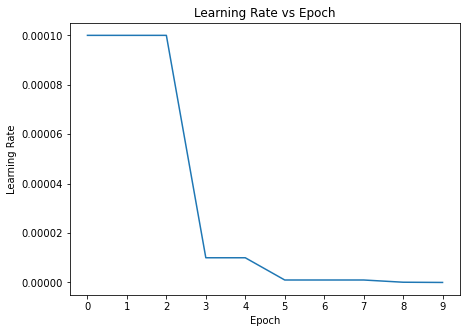

In [18]:
plot_learning_rate(history_dict)

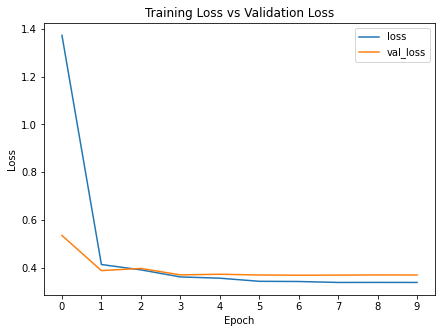

In [19]:
plot_metric(history_dict, 'loss')

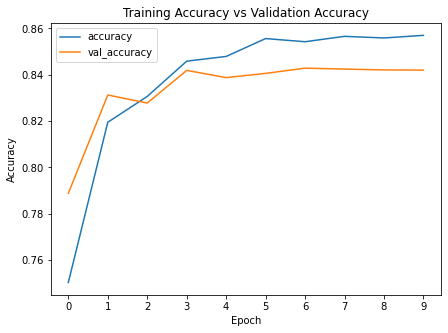

In [20]:
plot_metric(history_dict, 'accuracy')

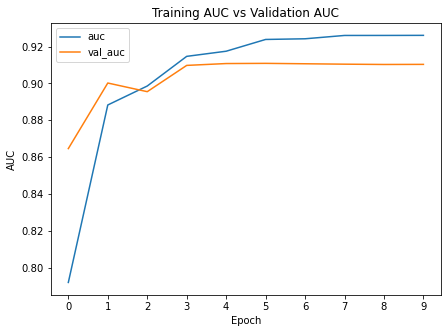

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/258 [..............................] - ETA: 19s - loss: 0.3313 - accuracy: 0.8125 - auc: 0.9219

 18/258 [=>............................] - ETA: 0s - loss: 0.3777 - accuracy: 0.8229 - auc: 0.9038 

 37/258 [===>..........................] - ETA: 0s - loss: 0.3594 - accuracy: 0.8378 - auc: 0.9146

 56/258 [=====>........................] - ETA: 0s - loss: 0.3679 - accuracy: 0.8398 - auc: 0.9106

 74/258 [=======>......................] - ETA: 0s - loss: 0.3686 - accuracy: 0.8391 - auc: 0.9094

 93/258 [=========>....................] - ETA: 0s - loss: 0.3726 - accuracy: 0.8407 - auc: 0.9071

112/258 [============>.................] - ETA: 0s - loss: 0.3744 - accuracy: 0.8396 - auc: 0.9061

131/258 [==============>...............] - ETA: 0s - loss: 0.3741 - accuracy: 0.8395 - auc: 0.9067

150/258 [================>.............] - ETA: 0s - loss: 0.3767 - accuracy: 0.8385 - auc: 0.9056

169/258 [==================>...........] - ETA: 0s - loss: 0.3761 - accuracy: 0.8395 - auc: 0.9060

188/258 [====================>.........] - ETA: 0s - loss: 0.3758 - accuracy: 0.8394 - auc: 0.9065

207/258 [=======================>......] - ETA: 0s - loss: 0.3792 - accuracy: 0.8359 - auc: 0.9047

226/258 [=========================>....] - ETA: 0s - loss: 0.3764 - accuracy: 0.8373 - auc: 0.9063

245/258 [===========================>..] - ETA: 0s - loss: 0.3789 - accuracy: 0.8367 - auc: 0.9056

258/258 [==============================] - 1s 3ms/step - loss: 0.3787 - accuracy: 0.8377 - auc: 0.9056


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---